In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.models as models
from coatnet import coatnet_0


In [2]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        self.indices = range(len(self))  # Length of dataset

    def __getitem__(self, index):
        path, target = self.samples[index]
        t = transforms.ToTensor()  # Transform
        sample = self.loader(path)  # Load image
        return t(sample),  target

    def __len__(self):
        return len(self.samples)


In [3]:
dt_train = CustomImageFolder(
    os.getcwd()+'\\archive\\train_images\\train', transform=None)
dt_val = CustomImageFolder(
    os.getcwd()+'\\archive\\train_images\\valid', transform=None)
dt_test = CustomImageFolder(
    os.getcwd()+'\\archive\\train_images\\test', transform=None)


In [11]:
dl_train = DataLoader(dt_train, batch_size=8, shuffle=True, num_workers=0)
dl_val = DataLoader(dt_val, batch_size=128, shuffle=True, num_workers=0)
dl_test = DataLoader(dt_test, batch_size=16, shuffle=True, num_workers=0)


In [5]:
# Check the content of dataloader
img1 = None

label = None

for image1, labels in dl_train:
    for j in range(image1.shape[0]):
        img1 = image1[j].permute(1, 2, 0)
        label = labels[j].item()

        break
    break


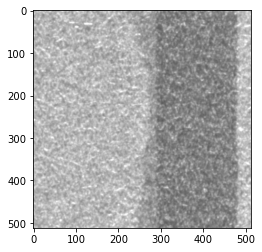

torch.Size([3, 512, 512])


In [6]:
plt.imshow((img1*255.0).int())
plt.show()
print(image1[j].shape)


In [9]:
def Train(train_dataloader, val_dataloader, num_epochs, lr, model_name):
    best_acc = 0
    best_epoch = None
    best_loss = None

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    # Load model with parameters
    model = None
    model_name_pth = None
    if model_name == 'efficientnet':
        model = models.efficientnet_b0()
        model.classifier[1] = nn.Linear(1280, 6)
        model.to(device)
        model_name_pth = 'Best_Efficientnet.pth'
    else:
        model = coatnet_0(512, 512, 6)
        model.to(device)
        model_name_pth = 'Best_CoatNet.pth'

    # Set optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-8)

    # Training

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        accuracy = 0.0
        total = 0.0
        criterion = nn.CrossEntropyLoss()

        for _, (imgs, labels) in enumerate(tqdm(train_dataloader)):
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            # compute the loss based on model output and real labels
            loss = criterion(outputs,  labels)
            # backpropagate the loss
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 1e-3, norm_type=2)
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # extract the loss value
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

        print('[%d] Train_loss: %.3f, Train_acc : %.3f' %
              (epoch + 1, running_loss / total, accuracy / total))

        # torch.cuda.empty_cache()

        # Evaluation

        model.eval()

        with torch.no_grad():
            test_loss = 0.0
            test_accuracy = 0.0
            test_total = 0

            for _, (imgs, labels) in enumerate(tqdm(val_dataloader)):
                img_test = imgs.to(device)
                labels_test = labels.to(device)
                outputs_test = model(img_test)

                # print(pred)
                # print(labels.to(device))
                loss = criterion(outputs_test, labels_test)
                test_loss += loss.item()
                _, predicted_test = torch.max(outputs_test.data, 1)
                test_total += labels_test.size(0)
                test_accuracy += (predicted_test == labels_test).sum().item()

            # print(accuracy)
            # print(len(test_loader.dataset))

            # Save Best model
            if test_accuracy > best_acc:
                best_acc = test_accuracy
                best_epoch = epoch + 1
                best_loss = test_loss / test_total

                torch.save(model.state_dict(), model_name_pth)
            print('[%d] Val_loss: %.3f, Val_acc : %.3f' % (
                epoch + 1, test_loss / test_total, test_accuracy / test_total))

    print('Best acc : %.3f, Epoch : %d, Loss: %.3f' %
          (best_acc/test_total, best_epoch, best_loss))


In [24]:
Train(dl_train, dl_val, 20, 1e-4, 'coatNet')


The model will be running on cuda:0 device


100%|██████████| 885/885 [02:14<00:00,  6.59it/s]


[1] Train_loss: 0.421, Train_acc : 0.709


100%|██████████| 190/190 [00:10<00:00, 17.36it/s]


[1] Val_loss: 0.576, Val_acc : 0.720


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[2] Train_loss: 0.200, Train_acc : 0.868


100%|██████████| 190/190 [00:10<00:00, 17.38it/s]


[2] Val_loss: 0.164, Val_acc : 0.881


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[3] Train_loss: 0.162, Train_acc : 0.908


100%|██████████| 190/190 [00:10<00:00, 17.33it/s]


[3] Val_loss: 0.263, Val_acc : 0.863


100%|██████████| 885/885 [02:14<00:00,  6.57it/s]


[4] Train_loss: 0.146, Train_acc : 0.911


100%|██████████| 190/190 [00:10<00:00, 17.29it/s]


[4] Val_loss: 0.985, Val_acc : 0.736


100%|██████████| 885/885 [02:14<00:00,  6.57it/s]


[5] Train_loss: 0.109, Train_acc : 0.936


100%|██████████| 190/190 [00:10<00:00, 17.38it/s]


[5] Val_loss: 0.446, Val_acc : 0.707


100%|██████████| 885/885 [02:14<00:00,  6.57it/s]


[6] Train_loss: 0.102, Train_acc : 0.930


100%|██████████| 190/190 [00:10<00:00, 17.28it/s]


[6] Val_loss: 0.140, Val_acc : 0.931


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[7] Train_loss: 0.094, Train_acc : 0.941


100%|██████████| 190/190 [00:11<00:00, 17.27it/s]


[7] Val_loss: 0.245, Val_acc : 0.900


100%|██████████| 885/885 [02:14<00:00,  6.59it/s]


[8] Train_loss: 0.089, Train_acc : 0.945


100%|██████████| 190/190 [00:10<00:00, 17.37it/s]


[8] Val_loss: 0.169, Val_acc : 0.897


100%|██████████| 885/885 [02:14<00:00,  6.57it/s]


[9] Train_loss: 0.091, Train_acc : 0.947


100%|██████████| 190/190 [00:10<00:00, 17.38it/s]


[9] Val_loss: 0.177, Val_acc : 0.897


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[10] Train_loss: 0.065, Train_acc : 0.960


100%|██████████| 190/190 [00:10<00:00, 17.31it/s]


[10] Val_loss: 0.465, Val_acc : 0.821


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[11] Train_loss: 0.094, Train_acc : 0.946


100%|██████████| 190/190 [00:10<00:00, 17.32it/s]


[11] Val_loss: 0.198, Val_acc : 0.871


100%|██████████| 885/885 [02:14<00:00,  6.60it/s]


[12] Train_loss: 0.058, Train_acc : 0.969


100%|██████████| 190/190 [00:10<00:00, 17.40it/s]


[12] Val_loss: 0.260, Val_acc : 0.871


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[13] Train_loss: 0.069, Train_acc : 0.956


100%|██████████| 190/190 [00:10<00:00, 17.32it/s]


[13] Val_loss: 0.178, Val_acc : 0.889


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[14] Train_loss: 0.051, Train_acc : 0.969


100%|██████████| 190/190 [00:10<00:00, 17.43it/s]


[14] Val_loss: 0.677, Val_acc : 0.784


100%|██████████| 885/885 [02:14<00:00,  6.60it/s]


[15] Train_loss: 0.060, Train_acc : 0.966


100%|██████████| 190/190 [00:10<00:00, 17.45it/s]


[15] Val_loss: 0.255, Val_acc : 0.871


100%|██████████| 885/885 [02:14<00:00,  6.60it/s]


[16] Train_loss: 0.062, Train_acc : 0.960


100%|██████████| 190/190 [00:10<00:00, 17.42it/s]


[16] Val_loss: 0.122, Val_acc : 0.905


100%|██████████| 885/885 [02:13<00:00,  6.62it/s]


[17] Train_loss: 0.057, Train_acc : 0.965


100%|██████████| 190/190 [00:10<00:00, 17.39it/s]


[17] Val_loss: 0.154, Val_acc : 0.937


100%|██████████| 885/885 [02:14<00:00,  6.59it/s]


[18] Train_loss: 0.035, Train_acc : 0.979


100%|██████████| 190/190 [00:10<00:00, 17.36it/s]


[18] Val_loss: 0.086, Val_acc : 0.945


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[19] Train_loss: 0.040, Train_acc : 0.975


100%|██████████| 190/190 [00:10<00:00, 17.36it/s]


[19] Val_loss: 0.344, Val_acc : 0.884


100%|██████████| 885/885 [02:14<00:00,  6.58it/s]


[20] Train_loss: 0.049, Train_acc : 0.973


100%|██████████| 190/190 [00:10<00:00, 17.32it/s]

[20] Val_loss: 0.411, Val_acc : 0.831
Best acc : 0.945, Epoch : 18, Loss: 0.086


In [10]:
Train(dl_train, dl_val, 20, 1e-4, 'efficientnet')


The model will be running on cuda:0 device


100%|██████████| 222/222 [00:45<00:00,  4.84it/s]


[1] Train_loss: 0.156, Train_acc : 0.532


100%|██████████| 48/48 [00:03<00:00, 12.24it/s]


[1] Val_loss: 0.124, Val_acc : 0.654


100%|██████████| 222/222 [00:45<00:00,  4.86it/s]


[2] Train_loss: 0.120, Train_acc : 0.652


100%|██████████| 48/48 [00:03<00:00, 12.31it/s]


[2] Val_loss: 0.104, Val_acc : 0.712


100%|██████████| 222/222 [00:45<00:00,  4.85it/s]


[3] Train_loss: 0.088, Train_acc : 0.764


100%|██████████| 48/48 [00:03<00:00, 12.26it/s]


[3] Val_loss: 0.055, Val_acc : 0.863


100%|██████████| 222/222 [00:46<00:00,  4.80it/s]


[4] Train_loss: 0.067, Train_acc : 0.814


100%|██████████| 48/48 [00:03<00:00, 12.02it/s]


[4] Val_loss: 0.102, Val_acc : 0.879


100%|██████████| 222/222 [00:46<00:00,  4.76it/s]


[5] Train_loss: 0.064, Train_acc : 0.822


100%|██████████| 48/48 [00:03<00:00, 12.11it/s]


[5] Val_loss: 0.056, Val_acc : 0.844


100%|██████████| 222/222 [00:46<00:00,  4.77it/s]


[6] Train_loss: 0.049, Train_acc : 0.863


100%|██████████| 48/48 [00:03<00:00, 12.14it/s]


[6] Val_loss: 0.043, Val_acc : 0.873


100%|██████████| 222/222 [00:46<00:00,  4.77it/s]


[7] Train_loss: 0.044, Train_acc : 0.882


100%|██████████| 48/48 [00:03<00:00, 12.12it/s]


[7] Val_loss: 0.028, Val_acc : 0.926


100%|██████████| 222/222 [00:46<00:00,  4.78it/s]


[8] Train_loss: 0.037, Train_acc : 0.906


100%|██████████| 48/48 [00:03<00:00, 12.07it/s]


[8] Val_loss: 0.038, Val_acc : 0.916


100%|██████████| 222/222 [00:46<00:00,  4.77it/s]


[9] Train_loss: 0.028, Train_acc : 0.921


100%|██████████| 48/48 [00:03<00:00, 12.08it/s]


[9] Val_loss: 0.041, Val_acc : 0.897


100%|██████████| 222/222 [00:46<00:00,  4.79it/s]


[10] Train_loss: 0.028, Train_acc : 0.927


100%|██████████| 48/48 [00:03<00:00, 12.11it/s]


[10] Val_loss: 0.021, Val_acc : 0.945


100%|██████████| 222/222 [00:46<00:00,  4.79it/s]


[11] Train_loss: 0.027, Train_acc : 0.937


100%|██████████| 48/48 [00:03<00:00, 12.01it/s]


[11] Val_loss: 0.016, Val_acc : 0.960


100%|██████████| 222/222 [00:46<00:00,  4.78it/s]


[12] Train_loss: 0.020, Train_acc : 0.952


100%|██████████| 48/48 [00:03<00:00, 12.13it/s]


[12] Val_loss: 0.015, Val_acc : 0.958


100%|██████████| 222/222 [00:46<00:00,  4.79it/s]


[13] Train_loss: 0.018, Train_acc : 0.953


100%|██████████| 48/48 [00:03<00:00, 12.02it/s]


[13] Val_loss: 0.007, Val_acc : 0.987


100%|██████████| 222/222 [00:46<00:00,  4.78it/s]


[14] Train_loss: 0.018, Train_acc : 0.960


100%|██████████| 48/48 [00:03<00:00, 12.14it/s]


[14] Val_loss: 0.016, Val_acc : 0.966


100%|██████████| 222/222 [00:46<00:00,  4.76it/s]


[15] Train_loss: 0.012, Train_acc : 0.972


100%|██████████| 48/48 [00:03<00:00, 12.12it/s]


[15] Val_loss: 0.009, Val_acc : 0.984


100%|██████████| 222/222 [00:46<00:00,  4.76it/s]


[16] Train_loss: 0.019, Train_acc : 0.958


100%|██████████| 48/48 [00:03<00:00, 12.07it/s]


[16] Val_loss: 0.015, Val_acc : 0.960


100%|██████████| 222/222 [00:46<00:00,  4.76it/s]


[17] Train_loss: 0.011, Train_acc : 0.973


100%|██████████| 48/48 [00:03<00:00, 12.10it/s]


[17] Val_loss: 0.008, Val_acc : 0.982


100%|██████████| 222/222 [00:46<00:00,  4.75it/s]


[18] Train_loss: 0.010, Train_acc : 0.977


100%|██████████| 48/48 [00:03<00:00, 12.12it/s]


[18] Val_loss: 0.017, Val_acc : 0.974


100%|██████████| 222/222 [00:46<00:00,  4.74it/s]


[19] Train_loss: 0.013, Train_acc : 0.972


100%|██████████| 48/48 [00:03<00:00, 12.07it/s]


[19] Val_loss: 0.006, Val_acc : 0.979


100%|██████████| 222/222 [00:46<00:00,  4.75it/s]


[20] Train_loss: 0.008, Train_acc : 0.984


100%|██████████| 48/48 [00:03<00:00, 12.12it/s]

[20] Val_loss: 0.004, Val_acc : 0.995
Best acc : 0.995, Epoch : 20, Loss: 0.004


#### Test

In [27]:
def Prediction(pred_dataloader, model_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    # Load model
    model = None

    if model_name == 'efficientnet':
        model = models.efficientnet_b0()
        model.classifier[1] = nn.Linear(1280, 6)
        model.load_state_dict(torch.load('Best_Efficientnet_0.995.pth'))
        model.to(device)
    else:
        model = coatnet_0(512, 512, 6)
        model.load_state_dict(torch.load('Best_CoatNet_0.984.pth'))
        model.to(device)

    # Predict
    model.eval()
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        pred_loss = 0.0
        pred_accuracy = 0.0
        pred_total = 0

        pred_labels = []

        target_labels = []

        for _, (img, labels) in enumerate(tqdm(pred_dataloader)):

            img_test = img.to(device)
            labels = labels.to(device)
            outputs_test = model(img_test)

            loss = criterion(outputs_test, labels)
            pred_loss += loss.item()
            _, preds = torch.max(outputs_test.data, 1)
            pred_total += labels.size(0)
            pred_accuracy += (preds == labels).sum().item()

            pred_labels.extend(preds.tolist())
            target_labels.extend(labels.tolist())

        print('Loss : %.3f' % (pred_loss/pred_total))
        print('Accuracy : %.3f' % (pred_accuracy/pred_total))


In [25]:
Prediction(dl_test, 'efficientnet')


The model will be running on cuda:0 device


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

Loss : 0.002
Accuracy : 0.987


In [28]:
Prediction(dl_test, 'coatnet')


The model will be running on cuda:0 device


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

Loss : 0.002
Accuracy : 0.984


### Ensemble Efficientnet

In [5]:
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(1280, 6)
# model.load_state_dict(torch.load('Best_Efficientnet_0.995.pth'))


#### Voting Classifier

In [6]:
from torchensemble import VotingClassifier
from torchensemble.utils.logging import set_logger

In [7]:
for i in range(2, 4):
    logger = set_logger('FastGeometricClassifier_Efficientnet')
    print('------------Estimator : {}------------'.format(i))

    ensemble = VotingClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,                        # number of base estimators
    )

    ensemble.set_optimizer(
        "Adam",                                 # type of parameter optimizer
        lr=1e-4,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer
        
    )

    ensemble.fit(
    train_loader=dl_train,
    epochs=30,                         # number of training epochs
    log_interval=500,
    test_loader=dl_test
    )

    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))
    



Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Create folder 'logs/'
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\FastGeometricClassifier_Efficientnet-2022_06_14_15_21.log...
------------Estimator : 2------------
Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 1.81502 | Correct: 4/16
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 1.93366 | Correct: 1/16


2022-06-14 15:23:28,761 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:23:28,860 - INFO: Epoch: 000 | Validation Acc: 64.474 % | Historical Best: 64.474 %


Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.92464 | Correct: 10/16
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 1.34845 | Correct: 8/16


2022-06-14 15:24:59,138 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:24:59,239 - INFO: Epoch: 001 | Validation Acc: 78.684 % | Historical Best: 78.684 %


Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 0.69080 | Correct: 11/16
Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.48190 | Correct: 12/16


2022-06-14 15:26:29,552 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:26:29,650 - INFO: Epoch: 002 | Validation Acc: 87.895 % | Historical Best: 87.895 %


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.72044 | Correct: 9/16
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.25955 | Correct: 14/16


2022-06-14 15:28:00,285 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:28:00,381 - INFO: Epoch: 003 | Validation Acc: 88.421 % | Historical Best: 88.421 %


Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.43036 | Correct: 12/16
Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 1.14223 | Correct: 9/16


2022-06-14 15:29:31,048 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:29:31,147 - INFO: Epoch: 004 | Validation Acc: 89.737 % | Historical Best: 89.737 %


Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.49199 | Correct: 12/16
Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 0.25142 | Correct: 15/16


2022-06-14 15:31:01,773 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:31:01,928 - INFO: Epoch: 005 | Validation Acc: 90.000 % | Historical Best: 90.000 %


Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.23603 | Correct: 14/16
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.78097 | Correct: 11/16


2022-06-14 15:32:32,637 - INFO: Epoch: 006 | Validation Acc: 88.947 % | Historical Best: 90.000 %


Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 0.17764 | Correct: 16/16
Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 0.19326 | Correct: 15/16


2022-06-14 15:34:02,209 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:34:02,307 - INFO: Epoch: 007 | Validation Acc: 94.474 % | Historical Best: 94.474 %


Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 0.12075 | Correct: 15/16
Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.48701 | Correct: 14/16


2022-06-14 15:35:31,868 - INFO: Epoch: 008 | Validation Acc: 93.947 % | Historical Best: 94.474 %


Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.15734 | Correct: 15/16
Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.49723 | Correct: 13/16


2022-06-14 15:37:01,410 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:37:01,506 - INFO: Epoch: 009 | Validation Acc: 97.368 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 010 | Batch: 000 | Loss: 0.11505 | Correct: 16/16
Estimator: 001 | Epoch: 010 | Batch: 000 | Loss: 0.11081 | Correct: 16/16


2022-06-14 15:38:30,946 - INFO: Epoch: 010 | Validation Acc: 95.526 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 011 | Batch: 000 | Loss: 0.15920 | Correct: 15/16
Estimator: 001 | Epoch: 011 | Batch: 000 | Loss: 0.35161 | Correct: 15/16


2022-06-14 15:40:00,323 - INFO: Epoch: 011 | Validation Acc: 97.105 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 012 | Batch: 000 | Loss: 0.03057 | Correct: 16/16
Estimator: 001 | Epoch: 012 | Batch: 000 | Loss: 0.72437 | Correct: 11/16


2022-06-14 15:41:29,792 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:41:29,890 - INFO: Epoch: 012 | Validation Acc: 97.632 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 013 | Batch: 000 | Loss: 0.12063 | Correct: 15/16
Estimator: 001 | Epoch: 013 | Batch: 000 | Loss: 0.13203 | Correct: 15/16


2022-06-14 15:42:59,336 - INFO: Epoch: 013 | Validation Acc: 97.632 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 014 | Batch: 000 | Loss: 0.43725 | Correct: 14/16
Estimator: 001 | Epoch: 014 | Batch: 000 | Loss: 0.04040 | Correct: 16/16


2022-06-14 15:44:28,992 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:44:29,099 - INFO: Epoch: 014 | Validation Acc: 97.895 % | Historical Best: 97.895 %


Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 0.01871 | Correct: 16/16
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 0.05340 | Correct: 16/16


2022-06-14 15:45:58,546 - INFO: Epoch: 015 | Validation Acc: 97.632 % | Historical Best: 97.895 %


Estimator: 000 | Epoch: 016 | Batch: 000 | Loss: 0.10056 | Correct: 15/16
Estimator: 001 | Epoch: 016 | Batch: 000 | Loss: 0.04559 | Correct: 16/16


2022-06-14 15:47:28,192 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:47:28,291 - INFO: Epoch: 016 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 017 | Batch: 000 | Loss: 0.02140 | Correct: 16/16
Estimator: 001 | Epoch: 017 | Batch: 000 | Loss: 0.04055 | Correct: 16/16


2022-06-14 15:48:58,357 - INFO: Epoch: 017 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 018 | Batch: 000 | Loss: 0.14014 | Correct: 15/16
Estimator: 001 | Epoch: 018 | Batch: 000 | Loss: 0.01106 | Correct: 16/16


2022-06-14 15:50:28,158 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:50:28,255 - INFO: Epoch: 018 | Validation Acc: 99.474 % | Historical Best: 99.474 %


Estimator: 000 | Epoch: 019 | Batch: 000 | Loss: 0.06941 | Correct: 16/16
Estimator: 001 | Epoch: 019 | Batch: 000 | Loss: 0.16846 | Correct: 15/16


2022-06-14 15:51:57,988 - INFO: Epoch: 019 | Validation Acc: 98.947 % | Historical Best: 99.474 %


Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 0.03247 | Correct: 16/16
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 0.14746 | Correct: 15/16


2022-06-14 15:53:27,889 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:53:27,993 - INFO: Epoch: 020 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Estimator: 000 | Epoch: 021 | Batch: 000 | Loss: 0.03634 | Correct: 16/16
Estimator: 001 | Epoch: 021 | Batch: 000 | Loss: 0.01265 | Correct: 16/16


2022-06-14 15:54:57,621 - INFO: Saving the model to `./VotingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 15:54:57,719 - INFO: Epoch: 021 | Validation Acc: 100.000 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 0.01605 | Correct: 16/16
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 0.28108 | Correct: 14/16


2022-06-14 15:56:27,223 - INFO: Epoch: 022 | Validation Acc: 99.474 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 0.13709 | Correct: 15/16
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 0.04763 | Correct: 16/16


2022-06-14 15:57:57,308 - INFO: Epoch: 023 | Validation Acc: 99.737 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 024 | Batch: 000 | Loss: 0.12078 | Correct: 15/16
Estimator: 001 | Epoch: 024 | Batch: 000 | Loss: 0.03216 | Correct: 16/16


2022-06-14 15:59:26,971 - INFO: Epoch: 024 | Validation Acc: 99.474 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 025 | Batch: 000 | Loss: 0.03667 | Correct: 16/16
Estimator: 001 | Epoch: 025 | Batch: 000 | Loss: 0.11262 | Correct: 16/16


2022-06-14 16:00:56,778 - INFO: Epoch: 025 | Validation Acc: 99.737 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 0.06389 | Correct: 16/16
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 0.04896 | Correct: 16/16


2022-06-14 16:02:26,495 - INFO: Epoch: 026 | Validation Acc: 99.737 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 027 | Batch: 000 | Loss: 0.06940 | Correct: 15/16
Estimator: 001 | Epoch: 027 | Batch: 000 | Loss: 0.01843 | Correct: 16/16


2022-06-14 16:03:56,005 - INFO: Epoch: 027 | Validation Acc: 100.000 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 028 | Batch: 000 | Loss: 0.00408 | Correct: 16/16
Estimator: 001 | Epoch: 028 | Batch: 000 | Loss: 0.00654 | Correct: 16/16


2022-06-14 16:05:25,545 - INFO: Epoch: 028 | Validation Acc: 99.737 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 0.00177 | Correct: 16/16
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 0.00617 | Correct: 16/16


2022-06-14 16:06:55,140 - INFO: Epoch: 029 | Validation Acc: 100.000 % | Historical Best: 100.000 %


Acc_Test : 100.0
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\FastGeometricClassifier_Efficientnet-2022_06_14_16_07.log...
------------Estimator : 3------------
Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 1.79450 | Correct: 2/16
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 1.80169 | Correct: 1/16
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 1.79692 | Correct: 0/16


2022-06-14 16:09:10,181 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:09:10,306 - INFO: Epoch: 000 | Validation Acc: 24.211 % | Historical Best: 24.211 %


Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 5.64728 | Correct: 2/16
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 4.70745 | Correct: 5/16
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 4.96745 | Correct: 7/16


2022-06-14 16:11:24,230 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:11:24,364 - INFO: Epoch: 001 | Validation Acc: 58.684 % | Historical Best: 58.684 %


Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 1.12643 | Correct: 12/16
Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 1.19305 | Correct: 9/16
Estimator: 002 | Epoch: 002 | Batch: 000 | Loss: 1.21867 | Correct: 11/16


2022-06-14 16:13:38,332 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:13:38,462 - INFO: Epoch: 002 | Validation Acc: 77.895 % | Historical Best: 77.895 %


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.52214 | Correct: 14/16
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 1.10211 | Correct: 9/16
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 1.09378 | Correct: 10/16


2022-06-14 16:15:52,216 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:15:52,402 - INFO: Epoch: 003 | Validation Acc: 83.158 % | Historical Best: 83.158 %


Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.56641 | Correct: 13/16
Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 0.84251 | Correct: 9/16
Estimator: 002 | Epoch: 004 | Batch: 000 | Loss: 0.65586 | Correct: 12/16


2022-06-14 16:18:06,332 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:18:06,460 - INFO: Epoch: 004 | Validation Acc: 87.895 % | Historical Best: 87.895 %


Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.83790 | Correct: 11/16
Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 0.37938 | Correct: 15/16
Estimator: 002 | Epoch: 005 | Batch: 000 | Loss: 0.43524 | Correct: 14/16


2022-06-14 16:20:20,452 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:20:20,582 - INFO: Epoch: 005 | Validation Acc: 90.000 % | Historical Best: 90.000 %


Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.56565 | Correct: 13/16
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.59143 | Correct: 14/16
Estimator: 002 | Epoch: 006 | Batch: 000 | Loss: 0.83801 | Correct: 10/16


2022-06-14 16:22:35,301 - INFO: Epoch: 006 | Validation Acc: 86.316 % | Historical Best: 90.000 %


Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 0.55748 | Correct: 12/16
Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 0.46295 | Correct: 12/16
Estimator: 002 | Epoch: 007 | Batch: 000 | Loss: 0.53964 | Correct: 12/16


2022-06-14 16:24:49,437 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:24:49,575 - INFO: Epoch: 007 | Validation Acc: 93.947 % | Historical Best: 93.947 %


Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 0.36271 | Correct: 14/16
Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.49030 | Correct: 13/16
Estimator: 002 | Epoch: 008 | Batch: 000 | Loss: 0.09244 | Correct: 16/16


2022-06-14 16:27:03,523 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:27:03,657 - INFO: Epoch: 008 | Validation Acc: 94.737 % | Historical Best: 94.737 %


Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.17197 | Correct: 15/16
Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.21752 | Correct: 16/16
Estimator: 002 | Epoch: 009 | Batch: 000 | Loss: 0.76934 | Correct: 11/16


2022-06-14 16:29:17,461 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:29:17,589 - INFO: Epoch: 009 | Validation Acc: 96.579 % | Historical Best: 96.579 %


Estimator: 000 | Epoch: 010 | Batch: 000 | Loss: 0.38999 | Correct: 12/16
Estimator: 001 | Epoch: 010 | Batch: 000 | Loss: 0.15378 | Correct: 15/16
Estimator: 002 | Epoch: 010 | Batch: 000 | Loss: 0.35335 | Correct: 14/16


2022-06-14 16:31:31,366 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:31:31,504 - INFO: Epoch: 010 | Validation Acc: 96.842 % | Historical Best: 96.842 %


Estimator: 000 | Epoch: 011 | Batch: 000 | Loss: 0.22719 | Correct: 15/16
Estimator: 001 | Epoch: 011 | Batch: 000 | Loss: 0.23374 | Correct: 14/16
Estimator: 002 | Epoch: 011 | Batch: 000 | Loss: 0.11357 | Correct: 15/16


2022-06-14 16:33:45,140 - INFO: Epoch: 011 | Validation Acc: 95.789 % | Historical Best: 96.842 %


Estimator: 000 | Epoch: 012 | Batch: 000 | Loss: 0.14371 | Correct: 16/16
Estimator: 001 | Epoch: 012 | Batch: 000 | Loss: 0.29607 | Correct: 14/16
Estimator: 002 | Epoch: 012 | Batch: 000 | Loss: 0.39391 | Correct: 14/16


2022-06-14 16:35:59,185 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:35:59,313 - INFO: Epoch: 012 | Validation Acc: 97.105 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 013 | Batch: 000 | Loss: 0.19966 | Correct: 15/16
Estimator: 001 | Epoch: 013 | Batch: 000 | Loss: 0.27306 | Correct: 15/16
Estimator: 002 | Epoch: 013 | Batch: 000 | Loss: 0.12951 | Correct: 15/16


2022-06-14 16:38:13,198 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:38:13,337 - INFO: Epoch: 013 | Validation Acc: 98.947 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 014 | Batch: 000 | Loss: 0.22289 | Correct: 14/16
Estimator: 001 | Epoch: 014 | Batch: 000 | Loss: 0.14242 | Correct: 15/16
Estimator: 002 | Epoch: 014 | Batch: 000 | Loss: 0.21275 | Correct: 15/16


2022-06-14 16:40:27,455 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:40:27,583 - INFO: Epoch: 014 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 0.04941 | Correct: 16/16
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 0.07931 | Correct: 16/16
Estimator: 002 | Epoch: 015 | Batch: 000 | Loss: 0.03508 | Correct: 16/16


2022-06-14 16:42:41,598 - INFO: Epoch: 015 | Validation Acc: 98.947 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 016 | Batch: 000 | Loss: 0.05862 | Correct: 16/16
Estimator: 001 | Epoch: 016 | Batch: 000 | Loss: 0.01699 | Correct: 16/16
Estimator: 002 | Epoch: 016 | Batch: 000 | Loss: 0.02436 | Correct: 16/16


2022-06-14 16:44:55,301 - INFO: Epoch: 016 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 017 | Batch: 000 | Loss: 0.08406 | Correct: 16/16
Estimator: 001 | Epoch: 017 | Batch: 000 | Loss: 0.01957 | Correct: 16/16
Estimator: 002 | Epoch: 017 | Batch: 000 | Loss: 0.36159 | Correct: 15/16


2022-06-14 16:47:09,360 - INFO: Epoch: 017 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 018 | Batch: 000 | Loss: 0.54827 | Correct: 12/16
Estimator: 001 | Epoch: 018 | Batch: 000 | Loss: 0.03465 | Correct: 16/16
Estimator: 002 | Epoch: 018 | Batch: 000 | Loss: 0.15583 | Correct: 15/16


2022-06-14 16:49:23,570 - INFO: Epoch: 018 | Validation Acc: 99.211 % | Historical Best: 99.211 %


Estimator: 000 | Epoch: 019 | Batch: 000 | Loss: 0.03002 | Correct: 16/16
Estimator: 001 | Epoch: 019 | Batch: 000 | Loss: 0.26939 | Correct: 15/16
Estimator: 002 | Epoch: 019 | Batch: 000 | Loss: 0.00932 | Correct: 16/16


2022-06-14 16:51:37,894 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:51:38,023 - INFO: Epoch: 019 | Validation Acc: 99.474 % | Historical Best: 99.474 %


Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 0.14724 | Correct: 15/16
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 0.02191 | Correct: 16/16
Estimator: 002 | Epoch: 020 | Batch: 000 | Loss: 0.27967 | Correct: 15/16


2022-06-14 16:53:52,846 - INFO: Epoch: 020 | Validation Acc: 99.474 % | Historical Best: 99.474 %


Estimator: 000 | Epoch: 021 | Batch: 000 | Loss: 0.11204 | Correct: 15/16
Estimator: 001 | Epoch: 021 | Batch: 000 | Loss: 0.06234 | Correct: 16/16
Estimator: 002 | Epoch: 021 | Batch: 000 | Loss: 0.01150 | Correct: 16/16


2022-06-14 16:56:07,588 - INFO: Epoch: 021 | Validation Acc: 98.947 % | Historical Best: 99.474 %


Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 0.03662 | Correct: 16/16
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 0.15201 | Correct: 15/16
Estimator: 002 | Epoch: 022 | Batch: 000 | Loss: 0.01571 | Correct: 16/16


2022-06-14 16:58:22,113 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 16:58:22,241 - INFO: Epoch: 022 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 0.01222 | Correct: 16/16
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 0.07655 | Correct: 16/16
Estimator: 002 | Epoch: 023 | Batch: 000 | Loss: 0.02045 | Correct: 16/16


2022-06-14 17:00:36,944 - INFO: Epoch: 023 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Estimator: 000 | Epoch: 024 | Batch: 000 | Loss: 0.20533 | Correct: 15/16
Estimator: 001 | Epoch: 024 | Batch: 000 | Loss: 0.05364 | Correct: 16/16
Estimator: 002 | Epoch: 024 | Batch: 000 | Loss: 0.00695 | Correct: 16/16


2022-06-14 17:02:52,074 - INFO: Epoch: 024 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Estimator: 000 | Epoch: 025 | Batch: 000 | Loss: 0.03337 | Correct: 16/16
Estimator: 001 | Epoch: 025 | Batch: 000 | Loss: 0.17487 | Correct: 15/16
Estimator: 002 | Epoch: 025 | Batch: 000 | Loss: 0.01031 | Correct: 16/16


2022-06-14 17:05:06,603 - INFO: Epoch: 025 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 0.03302 | Correct: 16/16
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 0.02107 | Correct: 16/16
Estimator: 002 | Epoch: 026 | Batch: 000 | Loss: 0.41455 | Correct: 15/16


2022-06-14 17:07:21,179 - INFO: Saving the model to `./VotingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 17:07:21,308 - INFO: Epoch: 026 | Validation Acc: 100.000 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 027 | Batch: 000 | Loss: 0.03323 | Correct: 16/16
Estimator: 001 | Epoch: 027 | Batch: 000 | Loss: 0.02911 | Correct: 16/16
Estimator: 002 | Epoch: 027 | Batch: 000 | Loss: 0.01263 | Correct: 16/16


2022-06-14 17:09:35,924 - INFO: Epoch: 027 | Validation Acc: 99.474 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 028 | Batch: 000 | Loss: 0.00607 | Correct: 16/16
Estimator: 001 | Epoch: 028 | Batch: 000 | Loss: 0.00467 | Correct: 16/16
Estimator: 002 | Epoch: 028 | Batch: 000 | Loss: 0.01938 | Correct: 16/16


2022-06-14 17:11:50,327 - INFO: Epoch: 028 | Validation Acc: 99.474 % | Historical Best: 100.000 %


Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 0.03872 | Correct: 16/16
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 0.00385 | Correct: 16/16
Estimator: 002 | Epoch: 029 | Batch: 000 | Loss: 0.01047 | Correct: 16/16


2022-06-14 17:14:04,984 - INFO: Epoch: 029 | Validation Acc: 99.474 % | Historical Best: 100.000 %


Acc_Test : 99.47368421052632


#### Sof Gradient Boosting Classifier

In [7]:
from torchensemble import SoftGradientBoostingClassifier


In [9]:
for i in range(2, 4):
    logger = set_logger('SoftGradientBoostingClassifier')
    print('------------Estimator : {}------------'.format(i))

    ensemble = SoftGradientBoostingClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,
        n_jobs=1                      # number of base estimators
    )

    ensemble.set_optimizer(
        "AdamW",                                 # type of parameter optimizer
        lr=1e-4,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer

    )

    ensemble.fit(
        train_loader=dl_train,
        epochs=50,                         # number of training epochs
        log_interval=500,
        test_loader=dl_test
    )

    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))


Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SoftGradientBoostingClassifier-2022_06_14_20_20.log...
------------Estimator : 2------------


2022-06-14 20:20:33,369 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 8.17361
2022-06-14 20:21:56,980 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 3.17304
2022-06-14 20:22:17,538 - INFO: Epoch: 000 | Validation Acc: 72.632 % | Historical Best: 72.632 %
2022-06-14 20:22:17,545 - INFO: Saving the model to `./SoftGradientBoostingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 20:22:17,819 - INFO: Epoch: 001 | Batch: 000 | RegLoss: 2.56622
2022-06-14 20:23:41,477 - INFO: Epoch: 001 | Batch: 500 | RegLoss: 1.64786
2022-06-14 20:24:01,945 - INFO: Epoch: 001 | Validation Acc: 75.263 % | Historical Best: 75.263 %
2022-06-14 20:24:01,952 - INFO: Saving the model to `./SoftGradientBoostingClassifier_EfficientNet_2_ckpt.pth`
2022-06-14 20:24:02,230 - INFO: Epoch: 002 | Batch: 000 | RegLoss: 3.68756
2022-06-14 20:25:26,017 - INFO: Epoch: 002 | Batch: 500 | RegLoss: 1.14255
2022-06-14 20:25:46,476 - INFO: Epoch: 002 | Validation Acc: 80.000 % | Historical Best: 80.000 %
2022-06-14 20:25:46,483 - INFO: Sa

Acc_Test : 97.89473684210526
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SoftGradientBoostingClassifier-2022_06_14_21_47.log...
------------Estimator : 3------------


2022-06-14 21:47:36,719 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 13.51597
2022-06-14 21:49:35,453 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 4.70999
2022-06-14 21:50:03,693 - INFO: Epoch: 000 | Validation Acc: 66.579 % | Historical Best: 66.579 %
2022-06-14 21:50:03,701 - INFO: Saving the model to `./SoftGradientBoostingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 21:50:04,069 - INFO: Epoch: 001 | Batch: 000 | RegLoss: 3.07503
2022-06-14 21:52:02,916 - INFO: Epoch: 001 | Batch: 500 | RegLoss: 4.95910
2022-06-14 21:52:31,125 - INFO: Epoch: 001 | Validation Acc: 74.474 % | Historical Best: 74.474 %
2022-06-14 21:52:31,134 - INFO: Saving the model to `./SoftGradientBoostingClassifier_EfficientNet_3_ckpt.pth`
2022-06-14 21:52:31,504 - INFO: Epoch: 002 | Batch: 000 | RegLoss: 5.98950
2022-06-14 21:54:30,506 - INFO: Epoch: 002 | Batch: 500 | RegLoss: 3.12833
2022-06-14 21:54:58,861 - INFO: Epoch: 002 | Validation Acc: 84.474 % | Historical Best: 84.474 %
2022-06-14 21:54:58,870 - INFO: S

Acc_Test : 98.6842105263158


#### Snapshot Ensemble Classifier

In [10]:
from torchensemble import SnapshotEnsembleClassifier


In [14]:
for i in range(2, 4):
    logger = set_logger('SnapshotEnsembleClassifier')
    print('------------Estimator : {}------------'.format(i))
   

    ensemble = SnapshotEnsembleClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,
    )

    ensemble.set_optimizer(
        "AdamW",                                 # type of parameter optimizer
        lr=1e-2,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer

    )

    ensemble.fit(
        train_loader=dl_train,
        epochs=150,                         # number of training epochs
        log_interval=500,
        test_loader=dl_test
    )

    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))
  


2022-06-15 12:42:04,766 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 000 | Loss: 1.64958 | Correct: 1/3
2022-06-15 12:42:04,766 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 000 | Loss: 1.64958 | Correct: 1/3


Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SnapshotEnsembleClassifier-2022_06_15_12_42.log...
------------Estimator : 2------------
None


2022-06-15 12:42:52,423 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 500 | Loss: 1.24082 | Correct: 1/3
2022-06-15 12:42:52,423 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 500 | Loss: 1.24082 | Correct: 1/3


None


2022-06-15 12:43:00,763 - INFO: lr: 0.01000 | Epoch: 001 | Batch: 000 | Loss: 3.34650 | Correct: 0/3
2022-06-15 12:43:00,763 - INFO: lr: 0.01000 | Epoch: 001 | Batch: 000 | Loss: 3.34650 | Correct: 0/3


None


2022-06-15 12:43:47,632 - INFO: lr: 0.00999 | Epoch: 001 | Batch: 500 | Loss: 1.76021 | Correct: 0/3
2022-06-15 12:43:47,632 - INFO: lr: 0.00999 | Epoch: 001 | Batch: 500 | Loss: 1.76021 | Correct: 0/3


None


2022-06-15 12:43:56,022 - INFO: lr: 0.00998 | Epoch: 002 | Batch: 000 | Loss: 1.17128 | Correct: 2/3
2022-06-15 12:43:56,022 - INFO: lr: 0.00998 | Epoch: 002 | Batch: 000 | Loss: 1.17128 | Correct: 2/3


None


2022-06-15 12:44:42,702 - INFO: lr: 0.00996 | Epoch: 002 | Batch: 500 | Loss: 0.59020 | Correct: 3/3
2022-06-15 12:44:42,702 - INFO: lr: 0.00996 | Epoch: 002 | Batch: 500 | Loss: 0.59020 | Correct: 3/3


None


2022-06-15 12:44:51,067 - INFO: lr: 0.00996 | Epoch: 003 | Batch: 000 | Loss: 1.41795 | Correct: 0/3
2022-06-15 12:44:51,067 - INFO: lr: 0.00996 | Epoch: 003 | Batch: 000 | Loss: 1.41795 | Correct: 0/3


None


2022-06-15 12:45:37,675 - INFO: lr: 0.00994 | Epoch: 003 | Batch: 500 | Loss: 0.85210 | Correct: 2/3
2022-06-15 12:45:37,675 - INFO: lr: 0.00994 | Epoch: 003 | Batch: 500 | Loss: 0.85210 | Correct: 2/3


None


2022-06-15 12:45:46,068 - INFO: lr: 0.00993 | Epoch: 004 | Batch: 000 | Loss: 1.23436 | Correct: 1/3
2022-06-15 12:45:46,068 - INFO: lr: 0.00993 | Epoch: 004 | Batch: 000 | Loss: 1.23436 | Correct: 1/3


None


2022-06-15 12:46:32,732 - INFO: lr: 0.00990 | Epoch: 004 | Batch: 500 | Loss: 1.89630 | Correct: 1/3
2022-06-15 12:46:32,732 - INFO: lr: 0.00990 | Epoch: 004 | Batch: 500 | Loss: 1.89630 | Correct: 1/3


None


2022-06-15 12:46:41,110 - INFO: lr: 0.00989 | Epoch: 005 | Batch: 000 | Loss: 0.57258 | Correct: 2/3
2022-06-15 12:46:41,110 - INFO: lr: 0.00989 | Epoch: 005 | Batch: 000 | Loss: 0.57258 | Correct: 2/3


None


2022-06-15 12:47:27,831 - INFO: lr: 0.00985 | Epoch: 005 | Batch: 500 | Loss: 0.76016 | Correct: 2/3
2022-06-15 12:47:27,831 - INFO: lr: 0.00985 | Epoch: 005 | Batch: 500 | Loss: 0.76016 | Correct: 2/3


None


2022-06-15 12:47:36,254 - INFO: lr: 0.00984 | Epoch: 006 | Batch: 000 | Loss: 0.97873 | Correct: 2/3
2022-06-15 12:47:36,254 - INFO: lr: 0.00984 | Epoch: 006 | Batch: 000 | Loss: 0.97873 | Correct: 2/3


None


2022-06-15 12:48:23,022 - INFO: lr: 0.00980 | Epoch: 006 | Batch: 500 | Loss: 0.72638 | Correct: 2/3
2022-06-15 12:48:23,022 - INFO: lr: 0.00980 | Epoch: 006 | Batch: 500 | Loss: 0.72638 | Correct: 2/3


None


2022-06-15 12:48:31,383 - INFO: lr: 0.00979 | Epoch: 007 | Batch: 000 | Loss: 0.38248 | Correct: 3/3
2022-06-15 12:48:31,383 - INFO: lr: 0.00979 | Epoch: 007 | Batch: 000 | Loss: 0.38248 | Correct: 3/3


None


2022-06-15 12:49:17,954 - INFO: lr: 0.00973 | Epoch: 007 | Batch: 500 | Loss: 0.32150 | Correct: 3/3
2022-06-15 12:49:17,954 - INFO: lr: 0.00973 | Epoch: 007 | Batch: 500 | Loss: 0.32150 | Correct: 3/3


None


2022-06-15 12:49:26,313 - INFO: lr: 0.00972 | Epoch: 008 | Batch: 000 | Loss: 0.31134 | Correct: 3/3
2022-06-15 12:49:26,313 - INFO: lr: 0.00972 | Epoch: 008 | Batch: 000 | Loss: 0.31134 | Correct: 3/3


None


2022-06-15 12:50:12,803 - INFO: lr: 0.00966 | Epoch: 008 | Batch: 500 | Loss: 0.16596 | Correct: 3/3
2022-06-15 12:50:12,803 - INFO: lr: 0.00966 | Epoch: 008 | Batch: 500 | Loss: 0.16596 | Correct: 3/3


None


2022-06-15 12:50:21,162 - INFO: lr: 0.00965 | Epoch: 009 | Batch: 000 | Loss: 0.16769 | Correct: 3/3
2022-06-15 12:50:21,162 - INFO: lr: 0.00965 | Epoch: 009 | Batch: 000 | Loss: 0.16769 | Correct: 3/3


None


2022-06-15 12:51:07,662 - INFO: lr: 0.00958 | Epoch: 009 | Batch: 500 | Loss: 0.02812 | Correct: 3/3
2022-06-15 12:51:07,662 - INFO: lr: 0.00958 | Epoch: 009 | Batch: 500 | Loss: 0.02812 | Correct: 3/3


None


2022-06-15 12:51:15,986 - INFO: lr: 0.00957 | Epoch: 010 | Batch: 000 | Loss: 0.07988 | Correct: 3/3
2022-06-15 12:51:15,986 - INFO: lr: 0.00957 | Epoch: 010 | Batch: 000 | Loss: 0.07988 | Correct: 3/3


None


2022-06-15 12:52:02,444 - INFO: lr: 0.00949 | Epoch: 010 | Batch: 500 | Loss: 0.58576 | Correct: 1/3
2022-06-15 12:52:02,444 - INFO: lr: 0.00949 | Epoch: 010 | Batch: 500 | Loss: 0.58576 | Correct: 1/3


None


2022-06-15 12:52:10,752 - INFO: lr: 0.00948 | Epoch: 011 | Batch: 000 | Loss: 0.14502 | Correct: 3/3
2022-06-15 12:52:10,752 - INFO: lr: 0.00948 | Epoch: 011 | Batch: 000 | Loss: 0.14502 | Correct: 3/3


None


2022-06-15 12:52:57,159 - INFO: lr: 0.00940 | Epoch: 011 | Batch: 500 | Loss: 0.36003 | Correct: 2/3
2022-06-15 12:52:57,159 - INFO: lr: 0.00940 | Epoch: 011 | Batch: 500 | Loss: 0.36003 | Correct: 2/3


None


2022-06-15 12:53:05,538 - INFO: lr: 0.00938 | Epoch: 012 | Batch: 000 | Loss: 0.22184 | Correct: 3/3
2022-06-15 12:53:05,538 - INFO: lr: 0.00938 | Epoch: 012 | Batch: 000 | Loss: 0.22184 | Correct: 3/3


None


2022-06-15 12:53:51,932 - INFO: lr: 0.00929 | Epoch: 012 | Batch: 500 | Loss: 0.05565 | Correct: 3/3
2022-06-15 12:53:51,932 - INFO: lr: 0.00929 | Epoch: 012 | Batch: 500 | Loss: 0.05565 | Correct: 3/3


None


2022-06-15 12:54:00,255 - INFO: lr: 0.00928 | Epoch: 013 | Batch: 000 | Loss: 0.03005 | Correct: 3/3
2022-06-15 12:54:00,255 - INFO: lr: 0.00928 | Epoch: 013 | Batch: 000 | Loss: 0.03005 | Correct: 3/3


None


2022-06-15 12:54:46,896 - INFO: lr: 0.00918 | Epoch: 013 | Batch: 500 | Loss: 0.35445 | Correct: 2/3
2022-06-15 12:54:46,896 - INFO: lr: 0.00918 | Epoch: 013 | Batch: 500 | Loss: 0.35445 | Correct: 2/3


None


2022-06-15 12:54:55,249 - INFO: lr: 0.00916 | Epoch: 014 | Batch: 000 | Loss: 0.04385 | Correct: 3/3
2022-06-15 12:54:55,249 - INFO: lr: 0.00916 | Epoch: 014 | Batch: 000 | Loss: 0.04385 | Correct: 3/3


None


2022-06-15 12:55:42,049 - INFO: lr: 0.00906 | Epoch: 014 | Batch: 500 | Loss: 0.59668 | Correct: 2/3
2022-06-15 12:55:42,049 - INFO: lr: 0.00906 | Epoch: 014 | Batch: 500 | Loss: 0.59668 | Correct: 2/3


None


2022-06-15 12:55:50,396 - INFO: lr: 0.00905 | Epoch: 015 | Batch: 000 | Loss: 0.02365 | Correct: 3/3
2022-06-15 12:55:50,396 - INFO: lr: 0.00905 | Epoch: 015 | Batch: 000 | Loss: 0.02365 | Correct: 3/3


None


2022-06-15 12:56:37,320 - INFO: lr: 0.00894 | Epoch: 015 | Batch: 500 | Loss: 0.03453 | Correct: 3/3
2022-06-15 12:56:37,320 - INFO: lr: 0.00894 | Epoch: 015 | Batch: 500 | Loss: 0.03453 | Correct: 3/3


None


2022-06-15 12:56:45,632 - INFO: lr: 0.00892 | Epoch: 016 | Batch: 000 | Loss: 0.01177 | Correct: 3/3
2022-06-15 12:56:45,632 - INFO: lr: 0.00892 | Epoch: 016 | Batch: 000 | Loss: 0.01177 | Correct: 3/3


None


2022-06-15 12:57:32,518 - INFO: lr: 0.00881 | Epoch: 016 | Batch: 500 | Loss: 0.04303 | Correct: 3/3
2022-06-15 12:57:32,518 - INFO: lr: 0.00881 | Epoch: 016 | Batch: 500 | Loss: 0.04303 | Correct: 3/3


None


2022-06-15 12:57:40,851 - INFO: lr: 0.00878 | Epoch: 017 | Batch: 000 | Loss: 0.91387 | Correct: 2/3
2022-06-15 12:57:40,851 - INFO: lr: 0.00878 | Epoch: 017 | Batch: 000 | Loss: 0.91387 | Correct: 2/3


None


2022-06-15 12:58:27,651 - INFO: lr: 0.00867 | Epoch: 017 | Batch: 500 | Loss: 0.63512 | Correct: 2/3
2022-06-15 12:58:27,651 - INFO: lr: 0.00867 | Epoch: 017 | Batch: 500 | Loss: 0.63512 | Correct: 2/3


None


2022-06-15 12:58:36,008 - INFO: lr: 0.00864 | Epoch: 018 | Batch: 000 | Loss: 0.17522 | Correct: 3/3
2022-06-15 12:58:36,008 - INFO: lr: 0.00864 | Epoch: 018 | Batch: 000 | Loss: 0.17522 | Correct: 3/3


None


2022-06-15 12:59:22,681 - INFO: lr: 0.00852 | Epoch: 018 | Batch: 500 | Loss: 0.22481 | Correct: 3/3
2022-06-15 12:59:22,681 - INFO: lr: 0.00852 | Epoch: 018 | Batch: 500 | Loss: 0.22481 | Correct: 3/3


None


2022-06-15 12:59:31,016 - INFO: lr: 0.00850 | Epoch: 019 | Batch: 000 | Loss: 0.01561 | Correct: 3/3
2022-06-15 12:59:31,016 - INFO: lr: 0.00850 | Epoch: 019 | Batch: 000 | Loss: 0.01561 | Correct: 3/3


None


2022-06-15 13:00:17,691 - INFO: lr: 0.00837 | Epoch: 019 | Batch: 500 | Loss: 0.00864 | Correct: 3/3
2022-06-15 13:00:17,691 - INFO: lr: 0.00837 | Epoch: 019 | Batch: 500 | Loss: 0.00864 | Correct: 3/3


None


2022-06-15 13:00:26,004 - INFO: lr: 0.00835 | Epoch: 020 | Batch: 000 | Loss: 0.31851 | Correct: 2/3
2022-06-15 13:00:26,004 - INFO: lr: 0.00835 | Epoch: 020 | Batch: 000 | Loss: 0.31851 | Correct: 2/3


None


2022-06-15 13:01:12,625 - INFO: lr: 0.00821 | Epoch: 020 | Batch: 500 | Loss: 0.14280 | Correct: 3/3
2022-06-15 13:01:12,625 - INFO: lr: 0.00821 | Epoch: 020 | Batch: 500 | Loss: 0.14280 | Correct: 3/3


None


2022-06-15 13:01:20,971 - INFO: lr: 0.00819 | Epoch: 021 | Batch: 000 | Loss: 0.03077 | Correct: 3/3
2022-06-15 13:01:20,971 - INFO: lr: 0.00819 | Epoch: 021 | Batch: 000 | Loss: 0.03077 | Correct: 3/3


None


2022-06-15 13:02:07,897 - INFO: lr: 0.00805 | Epoch: 021 | Batch: 500 | Loss: 0.01882 | Correct: 3/3
2022-06-15 13:02:07,897 - INFO: lr: 0.00805 | Epoch: 021 | Batch: 500 | Loss: 0.01882 | Correct: 3/3


None


2022-06-15 13:02:16,236 - INFO: lr: 0.00802 | Epoch: 022 | Batch: 000 | Loss: 1.87867 | Correct: 2/3
2022-06-15 13:02:16,236 - INFO: lr: 0.00802 | Epoch: 022 | Batch: 000 | Loss: 1.87867 | Correct: 2/3


None


2022-06-15 13:03:02,994 - INFO: lr: 0.00788 | Epoch: 022 | Batch: 500 | Loss: 0.00249 | Correct: 3/3
2022-06-15 13:03:02,994 - INFO: lr: 0.00788 | Epoch: 022 | Batch: 500 | Loss: 0.00249 | Correct: 3/3


None


2022-06-15 13:03:11,351 - INFO: lr: 0.00785 | Epoch: 023 | Batch: 000 | Loss: 0.02242 | Correct: 3/3
2022-06-15 13:03:11,351 - INFO: lr: 0.00785 | Epoch: 023 | Batch: 000 | Loss: 0.02242 | Correct: 3/3


None


2022-06-15 13:03:58,039 - INFO: lr: 0.00771 | Epoch: 023 | Batch: 500 | Loss: 0.79270 | Correct: 2/3
2022-06-15 13:03:58,039 - INFO: lr: 0.00771 | Epoch: 023 | Batch: 500 | Loss: 0.79270 | Correct: 2/3


None


2022-06-15 13:04:06,424 - INFO: lr: 0.00768 | Epoch: 024 | Batch: 000 | Loss: 0.01849 | Correct: 3/3
2022-06-15 13:04:06,424 - INFO: lr: 0.00768 | Epoch: 024 | Batch: 000 | Loss: 0.01849 | Correct: 3/3


None


2022-06-15 13:04:53,172 - INFO: lr: 0.00753 | Epoch: 024 | Batch: 500 | Loss: 0.00182 | Correct: 3/3
2022-06-15 13:04:53,172 - INFO: lr: 0.00753 | Epoch: 024 | Batch: 500 | Loss: 0.00182 | Correct: 3/3


None


2022-06-15 13:05:01,572 - INFO: lr: 0.00750 | Epoch: 025 | Batch: 000 | Loss: 1.81243 | Correct: 1/3
2022-06-15 13:05:01,572 - INFO: lr: 0.00750 | Epoch: 025 | Batch: 000 | Loss: 1.81243 | Correct: 1/3


None


2022-06-15 13:05:48,175 - INFO: lr: 0.00734 | Epoch: 025 | Batch: 500 | Loss: 0.01367 | Correct: 3/3
2022-06-15 13:05:48,175 - INFO: lr: 0.00734 | Epoch: 025 | Batch: 500 | Loss: 0.01367 | Correct: 3/3


None


2022-06-15 13:05:56,531 - INFO: lr: 0.00732 | Epoch: 026 | Batch: 000 | Loss: 0.00163 | Correct: 3/3
2022-06-15 13:05:56,531 - INFO: lr: 0.00732 | Epoch: 026 | Batch: 000 | Loss: 0.00163 | Correct: 3/3


None


2022-06-15 13:06:42,933 - INFO: lr: 0.00716 | Epoch: 026 | Batch: 500 | Loss: 0.00585 | Correct: 3/3
2022-06-15 13:06:42,933 - INFO: lr: 0.00716 | Epoch: 026 | Batch: 500 | Loss: 0.00585 | Correct: 3/3


None


2022-06-15 13:06:51,337 - INFO: lr: 0.00713 | Epoch: 027 | Batch: 000 | Loss: 0.00942 | Correct: 3/3
2022-06-15 13:06:51,337 - INFO: lr: 0.00713 | Epoch: 027 | Batch: 000 | Loss: 0.00942 | Correct: 3/3


None


2022-06-15 13:07:37,810 - INFO: lr: 0.00697 | Epoch: 027 | Batch: 500 | Loss: 0.02312 | Correct: 3/3
2022-06-15 13:07:37,810 - INFO: lr: 0.00697 | Epoch: 027 | Batch: 500 | Loss: 0.02312 | Correct: 3/3


None


2022-06-15 13:07:46,201 - INFO: lr: 0.00694 | Epoch: 028 | Batch: 000 | Loss: 0.00074 | Correct: 3/3
2022-06-15 13:07:46,201 - INFO: lr: 0.00694 | Epoch: 028 | Batch: 000 | Loss: 0.00074 | Correct: 3/3


None


2022-06-15 13:08:32,662 - INFO: lr: 0.00677 | Epoch: 028 | Batch: 500 | Loss: 0.38648 | Correct: 2/3
2022-06-15 13:08:32,662 - INFO: lr: 0.00677 | Epoch: 028 | Batch: 500 | Loss: 0.38648 | Correct: 2/3


None


2022-06-15 13:08:41,027 - INFO: lr: 0.00674 | Epoch: 029 | Batch: 000 | Loss: 0.00373 | Correct: 3/3
2022-06-15 13:08:41,027 - INFO: lr: 0.00674 | Epoch: 029 | Batch: 000 | Loss: 0.00373 | Correct: 3/3


None


2022-06-15 13:09:27,471 - INFO: lr: 0.00658 | Epoch: 029 | Batch: 500 | Loss: 0.00844 | Correct: 3/3
2022-06-15 13:09:27,471 - INFO: lr: 0.00658 | Epoch: 029 | Batch: 500 | Loss: 0.00844 | Correct: 3/3


None


2022-06-15 13:09:35,823 - INFO: lr: 0.00655 | Epoch: 030 | Batch: 000 | Loss: 0.00098 | Correct: 3/3
2022-06-15 13:09:35,823 - INFO: lr: 0.00655 | Epoch: 030 | Batch: 000 | Loss: 0.00098 | Correct: 3/3


None


2022-06-15 13:10:22,198 - INFO: lr: 0.00638 | Epoch: 030 | Batch: 500 | Loss: 0.00203 | Correct: 3/3
2022-06-15 13:10:22,198 - INFO: lr: 0.00638 | Epoch: 030 | Batch: 500 | Loss: 0.00203 | Correct: 3/3


None


2022-06-15 13:10:30,567 - INFO: lr: 0.00634 | Epoch: 031 | Batch: 000 | Loss: 0.00131 | Correct: 3/3
2022-06-15 13:10:30,567 - INFO: lr: 0.00634 | Epoch: 031 | Batch: 000 | Loss: 0.00131 | Correct: 3/3


None


2022-06-15 13:11:17,003 - INFO: lr: 0.00617 | Epoch: 031 | Batch: 500 | Loss: 0.00223 | Correct: 3/3
2022-06-15 13:11:17,003 - INFO: lr: 0.00617 | Epoch: 031 | Batch: 500 | Loss: 0.00223 | Correct: 3/3


None


2022-06-15 13:11:25,378 - INFO: lr: 0.00614 | Epoch: 032 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
2022-06-15 13:11:25,378 - INFO: lr: 0.00614 | Epoch: 032 | Batch: 000 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 13:12:12,232 - INFO: lr: 0.00597 | Epoch: 032 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:12:12,232 - INFO: lr: 0.00597 | Epoch: 032 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:12:20,579 - INFO: lr: 0.00594 | Epoch: 033 | Batch: 000 | Loss: 0.04329 | Correct: 3/3
2022-06-15 13:12:20,579 - INFO: lr: 0.00594 | Epoch: 033 | Batch: 000 | Loss: 0.04329 | Correct: 3/3


None


2022-06-15 13:13:07,368 - INFO: lr: 0.00576 | Epoch: 033 | Batch: 500 | Loss: 0.01967 | Correct: 3/3
2022-06-15 13:13:07,368 - INFO: lr: 0.00576 | Epoch: 033 | Batch: 500 | Loss: 0.01967 | Correct: 3/3


None


2022-06-15 13:13:15,703 - INFO: lr: 0.00573 | Epoch: 034 | Batch: 000 | Loss: 0.00095 | Correct: 3/3
2022-06-15 13:13:15,703 - INFO: lr: 0.00573 | Epoch: 034 | Batch: 000 | Loss: 0.00095 | Correct: 3/3


None


2022-06-15 13:14:02,576 - INFO: lr: 0.00555 | Epoch: 034 | Batch: 500 | Loss: 0.00111 | Correct: 3/3
2022-06-15 13:14:02,576 - INFO: lr: 0.00555 | Epoch: 034 | Batch: 500 | Loss: 0.00111 | Correct: 3/3


None


2022-06-15 13:14:10,906 - INFO: lr: 0.00552 | Epoch: 035 | Batch: 000 | Loss: 0.01072 | Correct: 3/3
2022-06-15 13:14:10,906 - INFO: lr: 0.00552 | Epoch: 035 | Batch: 000 | Loss: 0.01072 | Correct: 3/3


None


2022-06-15 13:14:57,639 - INFO: lr: 0.00535 | Epoch: 035 | Batch: 500 | Loss: 0.00019 | Correct: 3/3
2022-06-15 13:14:57,639 - INFO: lr: 0.00535 | Epoch: 035 | Batch: 500 | Loss: 0.00019 | Correct: 3/3


None


2022-06-15 13:15:06,023 - INFO: lr: 0.00531 | Epoch: 036 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 13:15:06,023 - INFO: lr: 0.00531 | Epoch: 036 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 13:15:52,650 - INFO: lr: 0.00514 | Epoch: 036 | Batch: 500 | Loss: 0.00215 | Correct: 3/3
2022-06-15 13:15:52,650 - INFO: lr: 0.00514 | Epoch: 036 | Batch: 500 | Loss: 0.00215 | Correct: 3/3


None


2022-06-15 13:16:01,006 - INFO: lr: 0.00510 | Epoch: 037 | Batch: 000 | Loss: 0.02421 | Correct: 3/3
2022-06-15 13:16:01,006 - INFO: lr: 0.00510 | Epoch: 037 | Batch: 000 | Loss: 0.02421 | Correct: 3/3


None


2022-06-15 13:16:47,631 - INFO: lr: 0.00493 | Epoch: 037 | Batch: 500 | Loss: 0.00497 | Correct: 3/3
2022-06-15 13:16:47,631 - INFO: lr: 0.00493 | Epoch: 037 | Batch: 500 | Loss: 0.00497 | Correct: 3/3


None


2022-06-15 13:16:56,012 - INFO: lr: 0.00490 | Epoch: 038 | Batch: 000 | Loss: 0.00256 | Correct: 3/3
2022-06-15 13:16:56,012 - INFO: lr: 0.00490 | Epoch: 038 | Batch: 000 | Loss: 0.00256 | Correct: 3/3


None


2022-06-15 13:17:42,672 - INFO: lr: 0.00472 | Epoch: 038 | Batch: 500 | Loss: 0.00052 | Correct: 3/3
2022-06-15 13:17:42,672 - INFO: lr: 0.00472 | Epoch: 038 | Batch: 500 | Loss: 0.00052 | Correct: 3/3


None


2022-06-15 13:17:51,028 - INFO: lr: 0.00469 | Epoch: 039 | Batch: 000 | Loss: 0.33341 | Correct: 2/3
2022-06-15 13:17:51,028 - INFO: lr: 0.00469 | Epoch: 039 | Batch: 000 | Loss: 0.33341 | Correct: 2/3


None


2022-06-15 13:18:37,521 - INFO: lr: 0.00451 | Epoch: 039 | Batch: 500 | Loss: 0.00147 | Correct: 3/3
2022-06-15 13:18:37,521 - INFO: lr: 0.00451 | Epoch: 039 | Batch: 500 | Loss: 0.00147 | Correct: 3/3


None


2022-06-15 13:18:45,895 - INFO: lr: 0.00448 | Epoch: 040 | Batch: 000 | Loss: 0.16244 | Correct: 3/3
2022-06-15 13:18:45,895 - INFO: lr: 0.00448 | Epoch: 040 | Batch: 000 | Loss: 0.16244 | Correct: 3/3


None


2022-06-15 13:19:32,396 - INFO: lr: 0.00430 | Epoch: 040 | Batch: 500 | Loss: 0.02227 | Correct: 3/3
2022-06-15 13:19:32,396 - INFO: lr: 0.00430 | Epoch: 040 | Batch: 500 | Loss: 0.02227 | Correct: 3/3


None


2022-06-15 13:19:40,772 - INFO: lr: 0.00427 | Epoch: 041 | Batch: 000 | Loss: 0.00070 | Correct: 3/3
2022-06-15 13:19:40,772 - INFO: lr: 0.00427 | Epoch: 041 | Batch: 000 | Loss: 0.00070 | Correct: 3/3


None


2022-06-15 13:20:27,218 - INFO: lr: 0.00409 | Epoch: 041 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:20:27,218 - INFO: lr: 0.00409 | Epoch: 041 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:20:35,577 - INFO: lr: 0.00406 | Epoch: 042 | Batch: 000 | Loss: 0.05619 | Correct: 3/3
2022-06-15 13:20:35,577 - INFO: lr: 0.00406 | Epoch: 042 | Batch: 000 | Loss: 0.05619 | Correct: 3/3


None


2022-06-15 13:21:21,996 - INFO: lr: 0.00389 | Epoch: 042 | Batch: 500 | Loss: 0.00013 | Correct: 3/3
2022-06-15 13:21:21,996 - INFO: lr: 0.00389 | Epoch: 042 | Batch: 500 | Loss: 0.00013 | Correct: 3/3


None


2022-06-15 13:21:30,348 - INFO: lr: 0.00386 | Epoch: 043 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
2022-06-15 13:21:30,348 - INFO: lr: 0.00386 | Epoch: 043 | Batch: 000 | Loss: 0.00009 | Correct: 3/3


None


2022-06-15 13:22:16,834 - INFO: lr: 0.00369 | Epoch: 043 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 13:22:16,834 - INFO: lr: 0.00369 | Epoch: 043 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 13:22:25,199 - INFO: lr: 0.00366 | Epoch: 044 | Batch: 000 | Loss: 0.00025 | Correct: 3/3
2022-06-15 13:22:25,199 - INFO: lr: 0.00366 | Epoch: 044 | Batch: 000 | Loss: 0.00025 | Correct: 3/3


None


2022-06-15 13:23:11,784 - INFO: lr: 0.00349 | Epoch: 044 | Batch: 500 | Loss: 0.00670 | Correct: 3/3
2022-06-15 13:23:11,784 - INFO: lr: 0.00349 | Epoch: 044 | Batch: 500 | Loss: 0.00670 | Correct: 3/3


None


2022-06-15 13:23:20,171 - INFO: lr: 0.00345 | Epoch: 045 | Batch: 000 | Loss: 0.97641 | Correct: 2/3
2022-06-15 13:23:20,171 - INFO: lr: 0.00345 | Epoch: 045 | Batch: 000 | Loss: 0.97641 | Correct: 2/3


None


2022-06-15 13:24:06,816 - INFO: lr: 0.00329 | Epoch: 045 | Batch: 500 | Loss: 0.00037 | Correct: 3/3
2022-06-15 13:24:06,816 - INFO: lr: 0.00329 | Epoch: 045 | Batch: 500 | Loss: 0.00037 | Correct: 3/3


None


2022-06-15 13:24:15,131 - INFO: lr: 0.00326 | Epoch: 046 | Batch: 000 | Loss: 0.01556 | Correct: 3/3
2022-06-15 13:24:15,131 - INFO: lr: 0.00326 | Epoch: 046 | Batch: 000 | Loss: 0.01556 | Correct: 3/3


None


2022-06-15 13:25:01,896 - INFO: lr: 0.00309 | Epoch: 046 | Batch: 500 | Loss: 0.06956 | Correct: 3/3
2022-06-15 13:25:01,896 - INFO: lr: 0.00309 | Epoch: 046 | Batch: 500 | Loss: 0.06956 | Correct: 3/3


None


2022-06-15 13:25:10,234 - INFO: lr: 0.00306 | Epoch: 047 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 13:25:10,234 - INFO: lr: 0.00306 | Epoch: 047 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 13:25:57,056 - INFO: lr: 0.00290 | Epoch: 047 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:25:57,056 - INFO: lr: 0.00290 | Epoch: 047 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:26:05,376 - INFO: lr: 0.00287 | Epoch: 048 | Batch: 000 | Loss: 0.00034 | Correct: 3/3
2022-06-15 13:26:05,376 - INFO: lr: 0.00287 | Epoch: 048 | Batch: 000 | Loss: 0.00034 | Correct: 3/3


None


2022-06-15 13:26:52,170 - INFO: lr: 0.00271 | Epoch: 048 | Batch: 500 | Loss: 0.00413 | Correct: 3/3
2022-06-15 13:26:52,170 - INFO: lr: 0.00271 | Epoch: 048 | Batch: 500 | Loss: 0.00413 | Correct: 3/3


None


2022-06-15 13:27:00,511 - INFO: lr: 0.00268 | Epoch: 049 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 13:27:00,511 - INFO: lr: 0.00268 | Epoch: 049 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 13:27:47,232 - INFO: lr: 0.00253 | Epoch: 049 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 13:27:47,232 - INFO: lr: 0.00253 | Epoch: 049 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 13:27:55,581 - INFO: lr: 0.00250 | Epoch: 050 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
2022-06-15 13:27:55,581 - INFO: lr: 0.00250 | Epoch: 050 | Batch: 000 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 13:28:42,360 - INFO: lr: 0.00235 | Epoch: 050 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 13:28:42,360 - INFO: lr: 0.00235 | Epoch: 050 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 13:28:50,746 - INFO: lr: 0.00232 | Epoch: 051 | Batch: 000 | Loss: 0.00039 | Correct: 3/3
2022-06-15 13:28:50,746 - INFO: lr: 0.00232 | Epoch: 051 | Batch: 000 | Loss: 0.00039 | Correct: 3/3


None


2022-06-15 13:29:37,545 - INFO: lr: 0.00217 | Epoch: 051 | Batch: 500 | Loss: 0.00043 | Correct: 3/3
2022-06-15 13:29:37,545 - INFO: lr: 0.00217 | Epoch: 051 | Batch: 500 | Loss: 0.00043 | Correct: 3/3


None


2022-06-15 13:29:45,933 - INFO: lr: 0.00215 | Epoch: 052 | Batch: 000 | Loss: 0.01165 | Correct: 3/3
2022-06-15 13:29:45,933 - INFO: lr: 0.00215 | Epoch: 052 | Batch: 000 | Loss: 0.01165 | Correct: 3/3


None


2022-06-15 13:30:33,507 - INFO: lr: 0.00200 | Epoch: 052 | Batch: 500 | Loss: 0.00013 | Correct: 3/3
2022-06-15 13:30:33,507 - INFO: lr: 0.00200 | Epoch: 052 | Batch: 500 | Loss: 0.00013 | Correct: 3/3


None


2022-06-15 13:30:41,990 - INFO: lr: 0.00198 | Epoch: 053 | Batch: 000 | Loss: 0.00070 | Correct: 3/3
2022-06-15 13:30:41,990 - INFO: lr: 0.00198 | Epoch: 053 | Batch: 000 | Loss: 0.00070 | Correct: 3/3


None


2022-06-15 13:31:29,616 - INFO: lr: 0.00184 | Epoch: 053 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
2022-06-15 13:31:29,616 - INFO: lr: 0.00184 | Epoch: 053 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 13:31:38,095 - INFO: lr: 0.00181 | Epoch: 054 | Batch: 000 | Loss: 0.00021 | Correct: 3/3
2022-06-15 13:31:38,095 - INFO: lr: 0.00181 | Epoch: 054 | Batch: 000 | Loss: 0.00021 | Correct: 3/3


None


2022-06-15 13:32:25,742 - INFO: lr: 0.00168 | Epoch: 054 | Batch: 500 | Loss: 0.00007 | Correct: 3/3
2022-06-15 13:32:25,742 - INFO: lr: 0.00168 | Epoch: 054 | Batch: 500 | Loss: 0.00007 | Correct: 3/3


None


2022-06-15 13:32:34,224 - INFO: lr: 0.00165 | Epoch: 055 | Batch: 000 | Loss: 0.00111 | Correct: 3/3
2022-06-15 13:32:34,224 - INFO: lr: 0.00165 | Epoch: 055 | Batch: 000 | Loss: 0.00111 | Correct: 3/3


None


2022-06-15 13:33:21,501 - INFO: lr: 0.00152 | Epoch: 055 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:33:21,501 - INFO: lr: 0.00152 | Epoch: 055 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:33:30,050 - INFO: lr: 0.00150 | Epoch: 056 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
2022-06-15 13:33:30,050 - INFO: lr: 0.00150 | Epoch: 056 | Batch: 000 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 13:34:17,560 - INFO: lr: 0.00138 | Epoch: 056 | Batch: 500 | Loss: 0.02555 | Correct: 3/3
2022-06-15 13:34:17,560 - INFO: lr: 0.00138 | Epoch: 056 | Batch: 500 | Loss: 0.02555 | Correct: 3/3


None


2022-06-15 13:34:26,024 - INFO: lr: 0.00136 | Epoch: 057 | Batch: 000 | Loss: 0.09664 | Correct: 3/3
2022-06-15 13:34:26,024 - INFO: lr: 0.00136 | Epoch: 057 | Batch: 000 | Loss: 0.09664 | Correct: 3/3


None


2022-06-15 13:35:13,568 - INFO: lr: 0.00124 | Epoch: 057 | Batch: 500 | Loss: 0.00071 | Correct: 3/3
2022-06-15 13:35:13,568 - INFO: lr: 0.00124 | Epoch: 057 | Batch: 500 | Loss: 0.00071 | Correct: 3/3


None


2022-06-15 13:35:22,047 - INFO: lr: 0.00122 | Epoch: 058 | Batch: 000 | Loss: 0.07382 | Correct: 3/3
2022-06-15 13:35:22,047 - INFO: lr: 0.00122 | Epoch: 058 | Batch: 000 | Loss: 0.07382 | Correct: 3/3


None


2022-06-15 13:36:09,555 - INFO: lr: 0.00110 | Epoch: 058 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
2022-06-15 13:36:09,555 - INFO: lr: 0.00110 | Epoch: 058 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 13:36:18,027 - INFO: lr: 0.00108 | Epoch: 059 | Batch: 000 | Loss: 0.00160 | Correct: 3/3
2022-06-15 13:36:18,027 - INFO: lr: 0.00108 | Epoch: 059 | Batch: 000 | Loss: 0.00160 | Correct: 3/3


None


2022-06-15 13:37:05,667 - INFO: lr: 0.00097 | Epoch: 059 | Batch: 500 | Loss: 0.00064 | Correct: 3/3
2022-06-15 13:37:05,667 - INFO: lr: 0.00097 | Epoch: 059 | Batch: 500 | Loss: 0.00064 | Correct: 3/3


None


2022-06-15 13:37:14,123 - INFO: lr: 0.00095 | Epoch: 060 | Batch: 000 | Loss: 0.00414 | Correct: 3/3
2022-06-15 13:37:14,123 - INFO: lr: 0.00095 | Epoch: 060 | Batch: 000 | Loss: 0.00414 | Correct: 3/3


None


2022-06-15 13:38:01,729 - INFO: lr: 0.00085 | Epoch: 060 | Batch: 500 | Loss: 0.00069 | Correct: 3/3
2022-06-15 13:38:01,729 - INFO: lr: 0.00085 | Epoch: 060 | Batch: 500 | Loss: 0.00069 | Correct: 3/3


None


2022-06-15 13:38:10,214 - INFO: lr: 0.00084 | Epoch: 061 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 13:38:10,214 - INFO: lr: 0.00084 | Epoch: 061 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 13:38:57,801 - INFO: lr: 0.00074 | Epoch: 061 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 13:38:57,801 - INFO: lr: 0.00074 | Epoch: 061 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 13:39:06,322 - INFO: lr: 0.00072 | Epoch: 062 | Batch: 000 | Loss: 0.00033 | Correct: 3/3
2022-06-15 13:39:06,322 - INFO: lr: 0.00072 | Epoch: 062 | Batch: 000 | Loss: 0.00033 | Correct: 3/3


None


2022-06-15 13:39:53,983 - INFO: lr: 0.00063 | Epoch: 062 | Batch: 500 | Loss: 0.00641 | Correct: 3/3
2022-06-15 13:39:53,983 - INFO: lr: 0.00063 | Epoch: 062 | Batch: 500 | Loss: 0.00641 | Correct: 3/3


None


2022-06-15 13:40:02,453 - INFO: lr: 0.00062 | Epoch: 063 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:40:02,453 - INFO: lr: 0.00062 | Epoch: 063 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:40:50,068 - INFO: lr: 0.00054 | Epoch: 063 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 13:40:50,068 - INFO: lr: 0.00054 | Epoch: 063 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 13:40:58,574 - INFO: lr: 0.00052 | Epoch: 064 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
2022-06-15 13:40:58,574 - INFO: lr: 0.00052 | Epoch: 064 | Batch: 000 | Loss: 0.00016 | Correct: 3/3


None


2022-06-15 13:41:46,175 - INFO: lr: 0.00045 | Epoch: 064 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 13:41:46,175 - INFO: lr: 0.00045 | Epoch: 064 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 13:41:54,654 - INFO: lr: 0.00043 | Epoch: 065 | Batch: 000 | Loss: 0.00971 | Correct: 3/3
2022-06-15 13:41:54,654 - INFO: lr: 0.00043 | Epoch: 065 | Batch: 000 | Loss: 0.00971 | Correct: 3/3


None


2022-06-15 13:42:42,300 - INFO: lr: 0.00036 | Epoch: 065 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:42:42,300 - INFO: lr: 0.00036 | Epoch: 065 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:42:50,819 - INFO: lr: 0.00035 | Epoch: 066 | Batch: 000 | Loss: 0.00025 | Correct: 3/3
2022-06-15 13:42:50,819 - INFO: lr: 0.00035 | Epoch: 066 | Batch: 000 | Loss: 0.00025 | Correct: 3/3


None


2022-06-15 13:43:38,353 - INFO: lr: 0.00029 | Epoch: 066 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 13:43:38,353 - INFO: lr: 0.00029 | Epoch: 066 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 13:43:46,893 - INFO: lr: 0.00028 | Epoch: 067 | Batch: 000 | Loss: 0.00011 | Correct: 3/3
2022-06-15 13:43:46,893 - INFO: lr: 0.00028 | Epoch: 067 | Batch: 000 | Loss: 0.00011 | Correct: 3/3


None


2022-06-15 13:44:34,372 - INFO: lr: 0.00022 | Epoch: 067 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
2022-06-15 13:44:34,372 - INFO: lr: 0.00022 | Epoch: 067 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 13:44:42,843 - INFO: lr: 0.00021 | Epoch: 068 | Batch: 000 | Loss: 0.02792 | Correct: 3/3
2022-06-15 13:44:42,843 - INFO: lr: 0.00021 | Epoch: 068 | Batch: 000 | Loss: 0.02792 | Correct: 3/3


None


2022-06-15 13:45:30,456 - INFO: lr: 0.00017 | Epoch: 068 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
2022-06-15 13:45:30,456 - INFO: lr: 0.00017 | Epoch: 068 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 13:45:38,948 - INFO: lr: 0.00016 | Epoch: 069 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:45:38,948 - INFO: lr: 0.00016 | Epoch: 069 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:46:26,546 - INFO: lr: 0.00012 | Epoch: 069 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:46:26,546 - INFO: lr: 0.00012 | Epoch: 069 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:46:35,014 - INFO: lr: 0.00011 | Epoch: 070 | Batch: 000 | Loss: 0.00019 | Correct: 3/3
2022-06-15 13:46:35,014 - INFO: lr: 0.00011 | Epoch: 070 | Batch: 000 | Loss: 0.00019 | Correct: 3/3


None


2022-06-15 13:47:22,574 - INFO: lr: 0.00008 | Epoch: 070 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 13:47:22,574 - INFO: lr: 0.00008 | Epoch: 070 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 13:47:31,028 - INFO: lr: 0.00007 | Epoch: 071 | Batch: 000 | Loss: 0.00022 | Correct: 3/3
2022-06-15 13:47:31,028 - INFO: lr: 0.00007 | Epoch: 071 | Batch: 000 | Loss: 0.00022 | Correct: 3/3


None


2022-06-15 13:48:18,631 - INFO: lr: 0.00004 | Epoch: 071 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:48:18,631 - INFO: lr: 0.00004 | Epoch: 071 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:48:27,071 - INFO: lr: 0.00004 | Epoch: 072 | Batch: 000 | Loss: 0.00044 | Correct: 3/3
2022-06-15 13:48:27,071 - INFO: lr: 0.00004 | Epoch: 072 | Batch: 000 | Loss: 0.00044 | Correct: 3/3


None


2022-06-15 13:49:14,675 - INFO: lr: 0.00002 | Epoch: 072 | Batch: 500 | Loss: 0.00296 | Correct: 3/3
2022-06-15 13:49:14,675 - INFO: lr: 0.00002 | Epoch: 072 | Batch: 500 | Loss: 0.00296 | Correct: 3/3


None


2022-06-15 13:49:23,195 - INFO: lr: 0.00002 | Epoch: 073 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:49:23,195 - INFO: lr: 0.00002 | Epoch: 073 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:50:10,900 - INFO: lr: 0.00001 | Epoch: 073 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:50:10,900 - INFO: lr: 0.00001 | Epoch: 073 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:50:19,357 - INFO: lr: 0.00000 | Epoch: 074 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
2022-06-15 13:50:19,357 - INFO: lr: 0.00000 | Epoch: 074 | Batch: 000 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 13:51:06,995 - INFO: lr: 0.00000 | Epoch: 074 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:51:06,995 - INFO: lr: 0.00000 | Epoch: 074 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:51:15,429 - INFO: Save the snapshot model with index: 0
2022-06-15 13:51:15,429 - INFO: Save the snapshot model with index: 0
2022-06-15 13:51:19,473 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_2_ckpt.pth`
2022-06-15 13:51:19,473 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_2_ckpt.pth`
2022-06-15 13:51:19,541 - INFO: n_estimators: 1 | Validation Acc: 96.842 % | Historical Best: 96.842 %
2022-06-15 13:51:19,541 - INFO: n_estimators: 1 | Validation Acc: 96.842 % | Historical Best: 96.842 %
2022-06-15 13:51:19,646 - INFO: lr: 0.01000 | Epoch: 075 | Batch: 000 | Loss: 0.02011 | Correct: 3/3
2022-06-15 13:51:19,646 - INFO: lr: 0.01000 | Epoch: 075 | Batch: 000 | Loss: 0.02011 | Correct: 3/3


None


2022-06-15 13:52:07,297 - INFO: lr: 0.01000 | Epoch: 075 | Batch: 500 | Loss: 0.15458 | Correct: 3/3
2022-06-15 13:52:07,297 - INFO: lr: 0.01000 | Epoch: 075 | Batch: 500 | Loss: 0.15458 | Correct: 3/3


None


2022-06-15 13:52:15,827 - INFO: lr: 0.01000 | Epoch: 076 | Batch: 000 | Loss: 0.67489 | Correct: 2/3
2022-06-15 13:52:15,827 - INFO: lr: 0.01000 | Epoch: 076 | Batch: 000 | Loss: 0.67489 | Correct: 2/3


None


2022-06-15 13:53:03,371 - INFO: lr: 0.00999 | Epoch: 076 | Batch: 500 | Loss: 0.10132 | Correct: 3/3
2022-06-15 13:53:03,371 - INFO: lr: 0.00999 | Epoch: 076 | Batch: 500 | Loss: 0.10132 | Correct: 3/3


None


2022-06-15 13:53:11,880 - INFO: lr: 0.00998 | Epoch: 077 | Batch: 000 | Loss: 0.08456 | Correct: 3/3
2022-06-15 13:53:11,880 - INFO: lr: 0.00998 | Epoch: 077 | Batch: 000 | Loss: 0.08456 | Correct: 3/3


None


2022-06-15 13:53:59,370 - INFO: lr: 0.00996 | Epoch: 077 | Batch: 500 | Loss: 0.00122 | Correct: 3/3
2022-06-15 13:53:59,370 - INFO: lr: 0.00996 | Epoch: 077 | Batch: 500 | Loss: 0.00122 | Correct: 3/3


None


2022-06-15 13:54:07,860 - INFO: lr: 0.00996 | Epoch: 078 | Batch: 000 | Loss: 0.00020 | Correct: 3/3
2022-06-15 13:54:07,860 - INFO: lr: 0.00996 | Epoch: 078 | Batch: 000 | Loss: 0.00020 | Correct: 3/3


None


2022-06-15 13:54:55,501 - INFO: lr: 0.00994 | Epoch: 078 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 13:54:55,501 - INFO: lr: 0.00994 | Epoch: 078 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 13:55:04,009 - INFO: lr: 0.00993 | Epoch: 079 | Batch: 000 | Loss: 0.99636 | Correct: 2/3
2022-06-15 13:55:04,009 - INFO: lr: 0.00993 | Epoch: 079 | Batch: 000 | Loss: 0.99636 | Correct: 2/3


None


2022-06-15 13:55:51,663 - INFO: lr: 0.00990 | Epoch: 079 | Batch: 500 | Loss: 0.00203 | Correct: 3/3
2022-06-15 13:55:51,663 - INFO: lr: 0.00990 | Epoch: 079 | Batch: 500 | Loss: 0.00203 | Correct: 3/3


None


2022-06-15 13:56:00,132 - INFO: lr: 0.00989 | Epoch: 080 | Batch: 000 | Loss: 0.28648 | Correct: 3/3
2022-06-15 13:56:00,132 - INFO: lr: 0.00989 | Epoch: 080 | Batch: 000 | Loss: 0.28648 | Correct: 3/3


None


2022-06-15 13:56:47,728 - INFO: lr: 0.00985 | Epoch: 080 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 13:56:47,728 - INFO: lr: 0.00985 | Epoch: 080 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 13:56:56,197 - INFO: lr: 0.00984 | Epoch: 081 | Batch: 000 | Loss: 0.18916 | Correct: 3/3
2022-06-15 13:56:56,197 - INFO: lr: 0.00984 | Epoch: 081 | Batch: 000 | Loss: 0.18916 | Correct: 3/3


None


2022-06-15 13:57:43,794 - INFO: lr: 0.00980 | Epoch: 081 | Batch: 500 | Loss: 0.01114 | Correct: 3/3
2022-06-15 13:57:43,794 - INFO: lr: 0.00980 | Epoch: 081 | Batch: 500 | Loss: 0.01114 | Correct: 3/3


None


2022-06-15 13:57:52,266 - INFO: lr: 0.00979 | Epoch: 082 | Batch: 000 | Loss: 0.00091 | Correct: 3/3
2022-06-15 13:57:52,266 - INFO: lr: 0.00979 | Epoch: 082 | Batch: 000 | Loss: 0.00091 | Correct: 3/3


None


2022-06-15 13:58:39,816 - INFO: lr: 0.00973 | Epoch: 082 | Batch: 500 | Loss: 0.00061 | Correct: 3/3
2022-06-15 13:58:39,816 - INFO: lr: 0.00973 | Epoch: 082 | Batch: 500 | Loss: 0.00061 | Correct: 3/3


None


2022-06-15 13:58:48,326 - INFO: lr: 0.00972 | Epoch: 083 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
2022-06-15 13:58:48,326 - INFO: lr: 0.00972 | Epoch: 083 | Batch: 000 | Loss: 0.00009 | Correct: 3/3


None


2022-06-15 13:59:35,922 - INFO: lr: 0.00966 | Epoch: 083 | Batch: 500 | Loss: 0.83320 | Correct: 2/3
2022-06-15 13:59:35,922 - INFO: lr: 0.00966 | Epoch: 083 | Batch: 500 | Loss: 0.83320 | Correct: 2/3


None


2022-06-15 13:59:44,521 - INFO: lr: 0.00965 | Epoch: 084 | Batch: 000 | Loss: 0.00116 | Correct: 3/3
2022-06-15 13:59:44,521 - INFO: lr: 0.00965 | Epoch: 084 | Batch: 000 | Loss: 0.00116 | Correct: 3/3


None


2022-06-15 14:00:32,154 - INFO: lr: 0.00958 | Epoch: 084 | Batch: 500 | Loss: 0.55282 | Correct: 2/3
2022-06-15 14:00:32,154 - INFO: lr: 0.00958 | Epoch: 084 | Batch: 500 | Loss: 0.55282 | Correct: 2/3


None


2022-06-15 14:00:40,620 - INFO: lr: 0.00957 | Epoch: 085 | Batch: 000 | Loss: 0.00964 | Correct: 3/3
2022-06-15 14:00:40,620 - INFO: lr: 0.00957 | Epoch: 085 | Batch: 000 | Loss: 0.00964 | Correct: 3/3


None


2022-06-15 14:01:28,285 - INFO: lr: 0.00949 | Epoch: 085 | Batch: 500 | Loss: 0.00464 | Correct: 3/3
2022-06-15 14:01:28,285 - INFO: lr: 0.00949 | Epoch: 085 | Batch: 500 | Loss: 0.00464 | Correct: 3/3


None


2022-06-15 14:01:36,780 - INFO: lr: 0.00948 | Epoch: 086 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 14:01:36,780 - INFO: lr: 0.00948 | Epoch: 086 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 14:02:24,118 - INFO: lr: 0.00940 | Epoch: 086 | Batch: 500 | Loss: 0.02371 | Correct: 3/3
2022-06-15 14:02:24,118 - INFO: lr: 0.00940 | Epoch: 086 | Batch: 500 | Loss: 0.02371 | Correct: 3/3


None


2022-06-15 14:02:32,658 - INFO: lr: 0.00938 | Epoch: 087 | Batch: 000 | Loss: 0.00807 | Correct: 3/3
2022-06-15 14:02:32,658 - INFO: lr: 0.00938 | Epoch: 087 | Batch: 000 | Loss: 0.00807 | Correct: 3/3


None


2022-06-15 14:03:20,286 - INFO: lr: 0.00929 | Epoch: 087 | Batch: 500 | Loss: 0.01099 | Correct: 3/3
2022-06-15 14:03:20,286 - INFO: lr: 0.00929 | Epoch: 087 | Batch: 500 | Loss: 0.01099 | Correct: 3/3


None


2022-06-15 14:03:28,792 - INFO: lr: 0.00928 | Epoch: 088 | Batch: 000 | Loss: 0.43697 | Correct: 2/3
2022-06-15 14:03:28,792 - INFO: lr: 0.00928 | Epoch: 088 | Batch: 000 | Loss: 0.43697 | Correct: 2/3


None


2022-06-15 14:04:16,382 - INFO: lr: 0.00918 | Epoch: 088 | Batch: 500 | Loss: 0.00138 | Correct: 3/3
2022-06-15 14:04:16,382 - INFO: lr: 0.00918 | Epoch: 088 | Batch: 500 | Loss: 0.00138 | Correct: 3/3


None


2022-06-15 14:04:24,883 - INFO: lr: 0.00916 | Epoch: 089 | Batch: 000 | Loss: 0.11743 | Correct: 3/3
2022-06-15 14:04:24,883 - INFO: lr: 0.00916 | Epoch: 089 | Batch: 000 | Loss: 0.11743 | Correct: 3/3


None


2022-06-15 14:05:12,654 - INFO: lr: 0.00906 | Epoch: 089 | Batch: 500 | Loss: 0.01401 | Correct: 3/3
2022-06-15 14:05:12,654 - INFO: lr: 0.00906 | Epoch: 089 | Batch: 500 | Loss: 0.01401 | Correct: 3/3


None


2022-06-15 14:05:21,166 - INFO: lr: 0.00905 | Epoch: 090 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
2022-06-15 14:05:21,166 - INFO: lr: 0.00905 | Epoch: 090 | Batch: 000 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 14:06:08,803 - INFO: lr: 0.00894 | Epoch: 090 | Batch: 500 | Loss: 0.00232 | Correct: 3/3
2022-06-15 14:06:08,803 - INFO: lr: 0.00894 | Epoch: 090 | Batch: 500 | Loss: 0.00232 | Correct: 3/3


None


2022-06-15 14:06:17,318 - INFO: lr: 0.00892 | Epoch: 091 | Batch: 000 | Loss: 0.01260 | Correct: 3/3
2022-06-15 14:06:17,318 - INFO: lr: 0.00892 | Epoch: 091 | Batch: 000 | Loss: 0.01260 | Correct: 3/3


None


2022-06-15 14:07:05,024 - INFO: lr: 0.00881 | Epoch: 091 | Batch: 500 | Loss: 0.00263 | Correct: 3/3
2022-06-15 14:07:05,024 - INFO: lr: 0.00881 | Epoch: 091 | Batch: 500 | Loss: 0.00263 | Correct: 3/3


None


2022-06-15 14:07:13,525 - INFO: lr: 0.00878 | Epoch: 092 | Batch: 000 | Loss: 0.04938 | Correct: 3/3
2022-06-15 14:07:13,525 - INFO: lr: 0.00878 | Epoch: 092 | Batch: 000 | Loss: 0.04938 | Correct: 3/3


None


2022-06-15 14:08:01,082 - INFO: lr: 0.00867 | Epoch: 092 | Batch: 500 | Loss: 0.54840 | Correct: 2/3
2022-06-15 14:08:01,082 - INFO: lr: 0.00867 | Epoch: 092 | Batch: 500 | Loss: 0.54840 | Correct: 2/3


None


2022-06-15 14:08:09,571 - INFO: lr: 0.00864 | Epoch: 093 | Batch: 000 | Loss: 0.14414 | Correct: 3/3
2022-06-15 14:08:09,571 - INFO: lr: 0.00864 | Epoch: 093 | Batch: 000 | Loss: 0.14414 | Correct: 3/3


None


2022-06-15 14:08:57,112 - INFO: lr: 0.00852 | Epoch: 093 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 14:08:57,112 - INFO: lr: 0.00852 | Epoch: 093 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 14:09:05,582 - INFO: lr: 0.00850 | Epoch: 094 | Batch: 000 | Loss: 0.00031 | Correct: 3/3
2022-06-15 14:09:05,582 - INFO: lr: 0.00850 | Epoch: 094 | Batch: 000 | Loss: 0.00031 | Correct: 3/3


None


2022-06-15 14:09:53,173 - INFO: lr: 0.00837 | Epoch: 094 | Batch: 500 | Loss: 0.01801 | Correct: 3/3
2022-06-15 14:09:53,173 - INFO: lr: 0.00837 | Epoch: 094 | Batch: 500 | Loss: 0.01801 | Correct: 3/3


None


2022-06-15 14:10:01,689 - INFO: lr: 0.00835 | Epoch: 095 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:10:01,689 - INFO: lr: 0.00835 | Epoch: 095 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:10:49,252 - INFO: lr: 0.00821 | Epoch: 095 | Batch: 500 | Loss: 0.00022 | Correct: 3/3
2022-06-15 14:10:49,252 - INFO: lr: 0.00821 | Epoch: 095 | Batch: 500 | Loss: 0.00022 | Correct: 3/3


None


2022-06-15 14:10:57,715 - INFO: lr: 0.00819 | Epoch: 096 | Batch: 000 | Loss: 0.00045 | Correct: 3/3
2022-06-15 14:10:57,715 - INFO: lr: 0.00819 | Epoch: 096 | Batch: 000 | Loss: 0.00045 | Correct: 3/3


None


2022-06-15 14:11:45,265 - INFO: lr: 0.00805 | Epoch: 096 | Batch: 500 | Loss: 0.19420 | Correct: 3/3
2022-06-15 14:11:45,265 - INFO: lr: 0.00805 | Epoch: 096 | Batch: 500 | Loss: 0.19420 | Correct: 3/3


None


2022-06-15 14:11:53,825 - INFO: lr: 0.00802 | Epoch: 097 | Batch: 000 | Loss: 0.00467 | Correct: 3/3
2022-06-15 14:11:53,825 - INFO: lr: 0.00802 | Epoch: 097 | Batch: 000 | Loss: 0.00467 | Correct: 3/3


None


2022-06-15 14:12:41,400 - INFO: lr: 0.00788 | Epoch: 097 | Batch: 500 | Loss: 0.00019 | Correct: 3/3
2022-06-15 14:12:41,400 - INFO: lr: 0.00788 | Epoch: 097 | Batch: 500 | Loss: 0.00019 | Correct: 3/3


None


2022-06-15 14:12:49,898 - INFO: lr: 0.00785 | Epoch: 098 | Batch: 000 | Loss: 0.00196 | Correct: 3/3
2022-06-15 14:12:49,898 - INFO: lr: 0.00785 | Epoch: 098 | Batch: 000 | Loss: 0.00196 | Correct: 3/3


None


2022-06-15 14:13:37,463 - INFO: lr: 0.00771 | Epoch: 098 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:13:37,463 - INFO: lr: 0.00771 | Epoch: 098 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:13:45,933 - INFO: lr: 0.00768 | Epoch: 099 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:13:45,933 - INFO: lr: 0.00768 | Epoch: 099 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:14:33,476 - INFO: lr: 0.00753 | Epoch: 099 | Batch: 500 | Loss: 0.00283 | Correct: 3/3
2022-06-15 14:14:33,476 - INFO: lr: 0.00753 | Epoch: 099 | Batch: 500 | Loss: 0.00283 | Correct: 3/3


None


2022-06-15 14:14:41,997 - INFO: lr: 0.00750 | Epoch: 100 | Batch: 000 | Loss: 0.02192 | Correct: 3/3
2022-06-15 14:14:41,997 - INFO: lr: 0.00750 | Epoch: 100 | Batch: 000 | Loss: 0.02192 | Correct: 3/3


None


2022-06-15 14:15:29,566 - INFO: lr: 0.00734 | Epoch: 100 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:15:29,566 - INFO: lr: 0.00734 | Epoch: 100 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:15:38,036 - INFO: lr: 0.00732 | Epoch: 101 | Batch: 000 | Loss: 0.43050 | Correct: 2/3
2022-06-15 14:15:38,036 - INFO: lr: 0.00732 | Epoch: 101 | Batch: 000 | Loss: 0.43050 | Correct: 2/3


None


2022-06-15 14:16:25,694 - INFO: lr: 0.00716 | Epoch: 101 | Batch: 500 | Loss: 0.00129 | Correct: 3/3
2022-06-15 14:16:25,694 - INFO: lr: 0.00716 | Epoch: 101 | Batch: 500 | Loss: 0.00129 | Correct: 3/3


None


2022-06-15 14:16:34,174 - INFO: lr: 0.00713 | Epoch: 102 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:16:34,174 - INFO: lr: 0.00713 | Epoch: 102 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:17:21,907 - INFO: lr: 0.00697 | Epoch: 102 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:17:21,907 - INFO: lr: 0.00697 | Epoch: 102 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:17:30,408 - INFO: lr: 0.00694 | Epoch: 103 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:17:30,408 - INFO: lr: 0.00694 | Epoch: 103 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:18:17,990 - INFO: lr: 0.00677 | Epoch: 103 | Batch: 500 | Loss: 0.00134 | Correct: 3/3
2022-06-15 14:18:17,990 - INFO: lr: 0.00677 | Epoch: 103 | Batch: 500 | Loss: 0.00134 | Correct: 3/3


None


2022-06-15 14:18:26,507 - INFO: lr: 0.00674 | Epoch: 104 | Batch: 000 | Loss: 0.00971 | Correct: 3/3
2022-06-15 14:18:26,507 - INFO: lr: 0.00674 | Epoch: 104 | Batch: 000 | Loss: 0.00971 | Correct: 3/3


None


2022-06-15 14:19:14,071 - INFO: lr: 0.00658 | Epoch: 104 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
2022-06-15 14:19:14,071 - INFO: lr: 0.00658 | Epoch: 104 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 14:19:22,567 - INFO: lr: 0.00655 | Epoch: 105 | Batch: 000 | Loss: 0.02043 | Correct: 3/3
2022-06-15 14:19:22,567 - INFO: lr: 0.00655 | Epoch: 105 | Batch: 000 | Loss: 0.02043 | Correct: 3/3


None


2022-06-15 14:20:10,258 - INFO: lr: 0.00638 | Epoch: 105 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:20:10,258 - INFO: lr: 0.00638 | Epoch: 105 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:20:18,759 - INFO: lr: 0.00634 | Epoch: 106 | Batch: 000 | Loss: 0.47369 | Correct: 2/3
2022-06-15 14:20:18,759 - INFO: lr: 0.00634 | Epoch: 106 | Batch: 000 | Loss: 0.47369 | Correct: 2/3


None


2022-06-15 14:21:06,330 - INFO: lr: 0.00617 | Epoch: 106 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:21:06,330 - INFO: lr: 0.00617 | Epoch: 106 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:21:14,829 - INFO: lr: 0.00614 | Epoch: 107 | Batch: 000 | Loss: 0.08597 | Correct: 3/3
2022-06-15 14:21:14,829 - INFO: lr: 0.00614 | Epoch: 107 | Batch: 000 | Loss: 0.08597 | Correct: 3/3


None


2022-06-15 14:22:02,434 - INFO: lr: 0.00597 | Epoch: 107 | Batch: 500 | Loss: 0.44574 | Correct: 2/3
2022-06-15 14:22:02,434 - INFO: lr: 0.00597 | Epoch: 107 | Batch: 500 | Loss: 0.44574 | Correct: 2/3


None


2022-06-15 14:22:10,893 - INFO: lr: 0.00594 | Epoch: 108 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:22:10,893 - INFO: lr: 0.00594 | Epoch: 108 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:22:58,449 - INFO: lr: 0.00576 | Epoch: 108 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:22:58,449 - INFO: lr: 0.00576 | Epoch: 108 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:23:06,985 - INFO: lr: 0.00573 | Epoch: 109 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
2022-06-15 14:23:06,985 - INFO: lr: 0.00573 | Epoch: 109 | Batch: 000 | Loss: 0.00007 | Correct: 3/3


None


2022-06-15 14:23:54,667 - INFO: lr: 0.00555 | Epoch: 109 | Batch: 500 | Loss: 0.01891 | Correct: 3/3
2022-06-15 14:23:54,667 - INFO: lr: 0.00555 | Epoch: 109 | Batch: 500 | Loss: 0.01891 | Correct: 3/3


None


2022-06-15 14:24:03,147 - INFO: lr: 0.00552 | Epoch: 110 | Batch: 000 | Loss: 0.00082 | Correct: 3/3
2022-06-15 14:24:03,147 - INFO: lr: 0.00552 | Epoch: 110 | Batch: 000 | Loss: 0.00082 | Correct: 3/3


None


2022-06-15 14:24:50,681 - INFO: lr: 0.00535 | Epoch: 110 | Batch: 500 | Loss: 0.00010 | Correct: 3/3
2022-06-15 14:24:50,681 - INFO: lr: 0.00535 | Epoch: 110 | Batch: 500 | Loss: 0.00010 | Correct: 3/3


None


2022-06-15 14:24:59,191 - INFO: lr: 0.00531 | Epoch: 111 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 14:24:59,191 - INFO: lr: 0.00531 | Epoch: 111 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 14:25:46,777 - INFO: lr: 0.00514 | Epoch: 111 | Batch: 500 | Loss: 0.00031 | Correct: 3/3
2022-06-15 14:25:46,777 - INFO: lr: 0.00514 | Epoch: 111 | Batch: 500 | Loss: 0.00031 | Correct: 3/3


None


2022-06-15 14:25:55,270 - INFO: lr: 0.00510 | Epoch: 112 | Batch: 000 | Loss: 0.04251 | Correct: 3/3
2022-06-15 14:25:55,270 - INFO: lr: 0.00510 | Epoch: 112 | Batch: 000 | Loss: 0.04251 | Correct: 3/3


None


2022-06-15 14:26:42,989 - INFO: lr: 0.00493 | Epoch: 112 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:26:42,989 - INFO: lr: 0.00493 | Epoch: 112 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:26:51,449 - INFO: lr: 0.00490 | Epoch: 113 | Batch: 000 | Loss: 0.00092 | Correct: 3/3
2022-06-15 14:26:51,449 - INFO: lr: 0.00490 | Epoch: 113 | Batch: 000 | Loss: 0.00092 | Correct: 3/3


None


2022-06-15 14:27:39,158 - INFO: lr: 0.00472 | Epoch: 113 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:27:39,158 - INFO: lr: 0.00472 | Epoch: 113 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:27:47,652 - INFO: lr: 0.00469 | Epoch: 114 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:27:47,652 - INFO: lr: 0.00469 | Epoch: 114 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:28:35,215 - INFO: lr: 0.00451 | Epoch: 114 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:28:35,215 - INFO: lr: 0.00451 | Epoch: 114 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:28:43,732 - INFO: lr: 0.00448 | Epoch: 115 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:28:43,732 - INFO: lr: 0.00448 | Epoch: 115 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:29:31,418 - INFO: lr: 0.00430 | Epoch: 115 | Batch: 500 | Loss: 0.00006 | Correct: 3/3
2022-06-15 14:29:31,418 - INFO: lr: 0.00430 | Epoch: 115 | Batch: 500 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 14:29:39,914 - INFO: lr: 0.00427 | Epoch: 116 | Batch: 000 | Loss: 0.00022 | Correct: 3/3
2022-06-15 14:29:39,914 - INFO: lr: 0.00427 | Epoch: 116 | Batch: 000 | Loss: 0.00022 | Correct: 3/3


None


2022-06-15 14:30:27,369 - INFO: lr: 0.00409 | Epoch: 116 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:30:27,369 - INFO: lr: 0.00409 | Epoch: 116 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:30:35,836 - INFO: lr: 0.00406 | Epoch: 117 | Batch: 000 | Loss: 0.00593 | Correct: 3/3
2022-06-15 14:30:35,836 - INFO: lr: 0.00406 | Epoch: 117 | Batch: 000 | Loss: 0.00593 | Correct: 3/3


None


2022-06-15 14:31:23,365 - INFO: lr: 0.00389 | Epoch: 117 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 14:31:23,365 - INFO: lr: 0.00389 | Epoch: 117 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 14:31:31,851 - INFO: lr: 0.00386 | Epoch: 118 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:31:31,851 - INFO: lr: 0.00386 | Epoch: 118 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:32:19,420 - INFO: lr: 0.00369 | Epoch: 118 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 14:32:19,420 - INFO: lr: 0.00369 | Epoch: 118 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 14:32:27,926 - INFO: lr: 0.00366 | Epoch: 119 | Batch: 000 | Loss: 0.00011 | Correct: 3/3
2022-06-15 14:32:27,926 - INFO: lr: 0.00366 | Epoch: 119 | Batch: 000 | Loss: 0.00011 | Correct: 3/3


None


2022-06-15 14:33:15,624 - INFO: lr: 0.00349 | Epoch: 119 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:33:15,624 - INFO: lr: 0.00349 | Epoch: 119 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:33:24,101 - INFO: lr: 0.00345 | Epoch: 120 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:33:24,101 - INFO: lr: 0.00345 | Epoch: 120 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:34:11,672 - INFO: lr: 0.00329 | Epoch: 120 | Batch: 500 | Loss: 1.70991 | Correct: 2/3
2022-06-15 14:34:11,672 - INFO: lr: 0.00329 | Epoch: 120 | Batch: 500 | Loss: 1.70991 | Correct: 2/3


None


2022-06-15 14:34:20,197 - INFO: lr: 0.00326 | Epoch: 121 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:34:20,197 - INFO: lr: 0.00326 | Epoch: 121 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:35:07,887 - INFO: lr: 0.00309 | Epoch: 121 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:35:07,887 - INFO: lr: 0.00309 | Epoch: 121 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:35:16,363 - INFO: lr: 0.00306 | Epoch: 122 | Batch: 000 | Loss: 0.00257 | Correct: 3/3
2022-06-15 14:35:16,363 - INFO: lr: 0.00306 | Epoch: 122 | Batch: 000 | Loss: 0.00257 | Correct: 3/3


None


2022-06-15 14:36:04,021 - INFO: lr: 0.00290 | Epoch: 122 | Batch: 500 | Loss: 0.01320 | Correct: 3/3
2022-06-15 14:36:04,021 - INFO: lr: 0.00290 | Epoch: 122 | Batch: 500 | Loss: 0.01320 | Correct: 3/3


None


2022-06-15 14:36:12,518 - INFO: lr: 0.00287 | Epoch: 123 | Batch: 000 | Loss: 0.00033 | Correct: 3/3
2022-06-15 14:36:12,518 - INFO: lr: 0.00287 | Epoch: 123 | Batch: 000 | Loss: 0.00033 | Correct: 3/3


None


2022-06-15 14:37:00,104 - INFO: lr: 0.00271 | Epoch: 123 | Batch: 500 | Loss: 0.00420 | Correct: 3/3
2022-06-15 14:37:00,104 - INFO: lr: 0.00271 | Epoch: 123 | Batch: 500 | Loss: 0.00420 | Correct: 3/3


None


2022-06-15 14:37:08,602 - INFO: lr: 0.00268 | Epoch: 124 | Batch: 000 | Loss: 0.00036 | Correct: 3/3
2022-06-15 14:37:08,602 - INFO: lr: 0.00268 | Epoch: 124 | Batch: 000 | Loss: 0.00036 | Correct: 3/3


None


2022-06-15 14:37:56,294 - INFO: lr: 0.00253 | Epoch: 124 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:37:56,294 - INFO: lr: 0.00253 | Epoch: 124 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:38:04,761 - INFO: lr: 0.00250 | Epoch: 125 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:38:04,761 - INFO: lr: 0.00250 | Epoch: 125 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:38:52,393 - INFO: lr: 0.00235 | Epoch: 125 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:38:52,393 - INFO: lr: 0.00235 | Epoch: 125 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:39:00,927 - INFO: lr: 0.00232 | Epoch: 126 | Batch: 000 | Loss: 0.00105 | Correct: 3/3
2022-06-15 14:39:00,927 - INFO: lr: 0.00232 | Epoch: 126 | Batch: 000 | Loss: 0.00105 | Correct: 3/3


None


2022-06-15 14:39:48,738 - INFO: lr: 0.00217 | Epoch: 126 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:39:48,738 - INFO: lr: 0.00217 | Epoch: 126 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:39:57,292 - INFO: lr: 0.00215 | Epoch: 127 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:39:57,292 - INFO: lr: 0.00215 | Epoch: 127 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:40:45,169 - INFO: lr: 0.00200 | Epoch: 127 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:40:45,169 - INFO: lr: 0.00200 | Epoch: 127 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:40:53,782 - INFO: lr: 0.00198 | Epoch: 128 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:40:53,782 - INFO: lr: 0.00198 | Epoch: 128 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:41:41,498 - INFO: lr: 0.00184 | Epoch: 128 | Batch: 500 | Loss: 0.00013 | Correct: 3/3
2022-06-15 14:41:41,498 - INFO: lr: 0.00184 | Epoch: 128 | Batch: 500 | Loss: 0.00013 | Correct: 3/3


None


2022-06-15 14:41:50,068 - INFO: lr: 0.00181 | Epoch: 129 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
2022-06-15 14:41:50,068 - INFO: lr: 0.00181 | Epoch: 129 | Batch: 000 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 14:42:37,791 - INFO: lr: 0.00168 | Epoch: 129 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:42:37,791 - INFO: lr: 0.00168 | Epoch: 129 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:42:46,376 - INFO: lr: 0.00165 | Epoch: 130 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
2022-06-15 14:42:46,376 - INFO: lr: 0.00165 | Epoch: 130 | Batch: 000 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 14:43:34,227 - INFO: lr: 0.00152 | Epoch: 130 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:43:34,227 - INFO: lr: 0.00152 | Epoch: 130 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:43:42,827 - INFO: lr: 0.00150 | Epoch: 131 | Batch: 000 | Loss: 0.00010 | Correct: 3/3
2022-06-15 14:43:42,827 - INFO: lr: 0.00150 | Epoch: 131 | Batch: 000 | Loss: 0.00010 | Correct: 3/3


None


2022-06-15 14:44:30,657 - INFO: lr: 0.00138 | Epoch: 131 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:44:30,657 - INFO: lr: 0.00138 | Epoch: 131 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:44:39,153 - INFO: lr: 0.00136 | Epoch: 132 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:44:39,153 - INFO: lr: 0.00136 | Epoch: 132 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:45:26,762 - INFO: lr: 0.00124 | Epoch: 132 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:45:26,762 - INFO: lr: 0.00124 | Epoch: 132 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:45:35,262 - INFO: lr: 0.00122 | Epoch: 133 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:45:35,262 - INFO: lr: 0.00122 | Epoch: 133 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:46:22,911 - INFO: lr: 0.00110 | Epoch: 133 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:46:22,911 - INFO: lr: 0.00110 | Epoch: 133 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:46:31,511 - INFO: lr: 0.00108 | Epoch: 134 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:46:31,511 - INFO: lr: 0.00108 | Epoch: 134 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:47:19,204 - INFO: lr: 0.00097 | Epoch: 134 | Batch: 500 | Loss: 0.00020 | Correct: 3/3
2022-06-15 14:47:19,204 - INFO: lr: 0.00097 | Epoch: 134 | Batch: 500 | Loss: 0.00020 | Correct: 3/3


None


2022-06-15 14:47:27,737 - INFO: lr: 0.00095 | Epoch: 135 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:47:27,737 - INFO: lr: 0.00095 | Epoch: 135 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:48:15,451 - INFO: lr: 0.00085 | Epoch: 135 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:48:15,451 - INFO: lr: 0.00085 | Epoch: 135 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:48:24,038 - INFO: lr: 0.00084 | Epoch: 136 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:48:24,038 - INFO: lr: 0.00084 | Epoch: 136 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:49:11,883 - INFO: lr: 0.00074 | Epoch: 136 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:49:11,883 - INFO: lr: 0.00074 | Epoch: 136 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:49:20,493 - INFO: lr: 0.00072 | Epoch: 137 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:49:20,493 - INFO: lr: 0.00072 | Epoch: 137 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:50:08,328 - INFO: lr: 0.00063 | Epoch: 137 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:50:08,328 - INFO: lr: 0.00063 | Epoch: 137 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:50:16,911 - INFO: lr: 0.00062 | Epoch: 138 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:50:16,911 - INFO: lr: 0.00062 | Epoch: 138 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:51:04,645 - INFO: lr: 0.00054 | Epoch: 138 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:51:04,645 - INFO: lr: 0.00054 | Epoch: 138 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:51:13,221 - INFO: lr: 0.00052 | Epoch: 139 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:51:13,221 - INFO: lr: 0.00052 | Epoch: 139 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:52:00,932 - INFO: lr: 0.00045 | Epoch: 139 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:52:00,932 - INFO: lr: 0.00045 | Epoch: 139 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:52:09,561 - INFO: lr: 0.00043 | Epoch: 140 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:52:09,561 - INFO: lr: 0.00043 | Epoch: 140 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:52:57,269 - INFO: lr: 0.00036 | Epoch: 140 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:52:57,269 - INFO: lr: 0.00036 | Epoch: 140 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:53:05,860 - INFO: lr: 0.00035 | Epoch: 141 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:53:05,860 - INFO: lr: 0.00035 | Epoch: 141 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:53:53,657 - INFO: lr: 0.00029 | Epoch: 141 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:53:53,657 - INFO: lr: 0.00029 | Epoch: 141 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:54:02,239 - INFO: lr: 0.00028 | Epoch: 142 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:54:02,239 - INFO: lr: 0.00028 | Epoch: 142 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:54:49,843 - INFO: lr: 0.00022 | Epoch: 142 | Batch: 500 | Loss: 0.00308 | Correct: 3/3
2022-06-15 14:54:49,843 - INFO: lr: 0.00022 | Epoch: 142 | Batch: 500 | Loss: 0.00308 | Correct: 3/3


None


2022-06-15 14:54:58,359 - INFO: lr: 0.00021 | Epoch: 143 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:54:58,359 - INFO: lr: 0.00021 | Epoch: 143 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:55:46,161 - INFO: lr: 0.00017 | Epoch: 143 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:55:46,161 - INFO: lr: 0.00017 | Epoch: 143 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:55:54,763 - INFO: lr: 0.00016 | Epoch: 144 | Batch: 000 | Loss: 0.00059 | Correct: 3/3
2022-06-15 14:55:54,763 - INFO: lr: 0.00016 | Epoch: 144 | Batch: 000 | Loss: 0.00059 | Correct: 3/3


None


2022-06-15 14:56:42,494 - INFO: lr: 0.00012 | Epoch: 144 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:56:42,494 - INFO: lr: 0.00012 | Epoch: 144 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:56:51,091 - INFO: lr: 0.00011 | Epoch: 145 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:56:51,091 - INFO: lr: 0.00011 | Epoch: 145 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:57:38,954 - INFO: lr: 0.00008 | Epoch: 145 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:57:38,954 - INFO: lr: 0.00008 | Epoch: 145 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:57:47,540 - INFO: lr: 0.00007 | Epoch: 146 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:57:47,540 - INFO: lr: 0.00007 | Epoch: 146 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:58:35,188 - INFO: lr: 0.00004 | Epoch: 146 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:58:35,188 - INFO: lr: 0.00004 | Epoch: 146 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 14:58:43,768 - INFO: lr: 0.00004 | Epoch: 147 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 14:58:43,768 - INFO: lr: 0.00004 | Epoch: 147 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 14:59:31,415 - INFO: lr: 0.00002 | Epoch: 147 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 14:59:31,415 - INFO: lr: 0.00002 | Epoch: 147 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 14:59:39,990 - INFO: lr: 0.00002 | Epoch: 148 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 14:59:39,990 - INFO: lr: 0.00002 | Epoch: 148 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 15:00:27,859 - INFO: lr: 0.00001 | Epoch: 148 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 15:00:27,859 - INFO: lr: 0.00001 | Epoch: 148 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 15:00:36,443 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 15:00:36,443 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 15:01:24,075 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 15:01:24,075 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 15:01:32,680 - INFO: Save the snapshot model with index: 1
2022-06-15 15:01:32,680 - INFO: Save the snapshot model with index: 1
2022-06-15 15:01:38,306 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_2_ckpt.pth`
2022-06-15 15:01:38,306 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_2_ckpt.pth`
2022-06-15 15:01:38,399 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-15 15:01:38,399 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-15 15:01:44,151 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 000 | Loss: 1.87523 | Correct: 0/3
2022-06-15 15:01:44,151 - INFO: lr: 0.01000 | Epoch: 000 | Batch: 000 | Loss: 1.87523 | Correct: 0/3


Acc_Test : 99.21052631578948
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SnapshotEnsembleClassifier-2022_06_15_15_01.log...
------------Estimator : 3------------
None


2022-06-15 15:02:31,920 - INFO: lr: 0.00999 | Epoch: 000 | Batch: 500 | Loss: 0.94678 | Correct: 3/3
2022-06-15 15:02:31,920 - INFO: lr: 0.00999 | Epoch: 000 | Batch: 500 | Loss: 0.94678 | Correct: 3/3


None


2022-06-15 15:02:40,495 - INFO: lr: 0.00999 | Epoch: 001 | Batch: 000 | Loss: 1.35942 | Correct: 2/3
2022-06-15 15:02:40,495 - INFO: lr: 0.00999 | Epoch: 001 | Batch: 000 | Loss: 1.35942 | Correct: 2/3


None


2022-06-15 15:03:28,186 - INFO: lr: 0.00997 | Epoch: 001 | Batch: 500 | Loss: 1.66093 | Correct: 1/3
2022-06-15 15:03:28,186 - INFO: lr: 0.00997 | Epoch: 001 | Batch: 500 | Loss: 1.66093 | Correct: 1/3


None


2022-06-15 15:03:36,756 - INFO: lr: 0.00996 | Epoch: 002 | Batch: 000 | Loss: 2.20283 | Correct: 0/3
2022-06-15 15:03:36,756 - INFO: lr: 0.00996 | Epoch: 002 | Batch: 000 | Loss: 2.20283 | Correct: 0/3


None


2022-06-15 15:04:24,456 - INFO: lr: 0.00992 | Epoch: 002 | Batch: 500 | Loss: 1.26426 | Correct: 1/3
2022-06-15 15:04:24,456 - INFO: lr: 0.00992 | Epoch: 002 | Batch: 500 | Loss: 1.26426 | Correct: 1/3


None


2022-06-15 15:04:33,097 - INFO: lr: 0.00991 | Epoch: 003 | Batch: 000 | Loss: 1.14696 | Correct: 2/3
2022-06-15 15:04:33,097 - INFO: lr: 0.00991 | Epoch: 003 | Batch: 000 | Loss: 1.14696 | Correct: 2/3


None


2022-06-15 15:05:20,888 - INFO: lr: 0.00985 | Epoch: 003 | Batch: 500 | Loss: 0.99166 | Correct: 2/3
2022-06-15 15:05:20,888 - INFO: lr: 0.00985 | Epoch: 003 | Batch: 500 | Loss: 0.99166 | Correct: 2/3


None


2022-06-15 15:05:29,451 - INFO: lr: 0.00984 | Epoch: 004 | Batch: 000 | Loss: 0.86823 | Correct: 1/3
2022-06-15 15:05:29,451 - INFO: lr: 0.00984 | Epoch: 004 | Batch: 000 | Loss: 0.86823 | Correct: 1/3


None


2022-06-15 15:06:17,179 - INFO: lr: 0.00977 | Epoch: 004 | Batch: 500 | Loss: 0.65141 | Correct: 2/3
2022-06-15 15:06:17,179 - INFO: lr: 0.00977 | Epoch: 004 | Batch: 500 | Loss: 0.65141 | Correct: 2/3


None


2022-06-15 15:06:25,765 - INFO: lr: 0.00976 | Epoch: 005 | Batch: 000 | Loss: 0.86292 | Correct: 2/3
2022-06-15 15:06:25,765 - INFO: lr: 0.00976 | Epoch: 005 | Batch: 000 | Loss: 0.86292 | Correct: 2/3


None


2022-06-15 15:07:13,417 - INFO: lr: 0.00967 | Epoch: 005 | Batch: 500 | Loss: 0.52348 | Correct: 3/3
2022-06-15 15:07:13,417 - INFO: lr: 0.00967 | Epoch: 005 | Batch: 500 | Loss: 0.52348 | Correct: 3/3


None


2022-06-15 15:07:22,000 - INFO: lr: 0.00965 | Epoch: 006 | Batch: 000 | Loss: 0.74686 | Correct: 2/3
2022-06-15 15:07:22,000 - INFO: lr: 0.00965 | Epoch: 006 | Batch: 000 | Loss: 0.74686 | Correct: 2/3


None


2022-06-15 15:08:09,832 - INFO: lr: 0.00954 | Epoch: 006 | Batch: 500 | Loss: 0.47445 | Correct: 3/3
2022-06-15 15:08:09,832 - INFO: lr: 0.00954 | Epoch: 006 | Batch: 500 | Loss: 0.47445 | Correct: 3/3


None


2022-06-15 15:08:18,383 - INFO: lr: 0.00952 | Epoch: 007 | Batch: 000 | Loss: 0.41667 | Correct: 3/3
2022-06-15 15:08:18,383 - INFO: lr: 0.00952 | Epoch: 007 | Batch: 000 | Loss: 0.41667 | Correct: 3/3


None


2022-06-15 15:09:06,055 - INFO: lr: 0.00940 | Epoch: 007 | Batch: 500 | Loss: 0.29604 | Correct: 3/3
2022-06-15 15:09:06,055 - INFO: lr: 0.00940 | Epoch: 007 | Batch: 500 | Loss: 0.29604 | Correct: 3/3


None


2022-06-15 15:09:14,574 - INFO: lr: 0.00938 | Epoch: 008 | Batch: 000 | Loss: 0.32837 | Correct: 3/3
2022-06-15 15:09:14,574 - INFO: lr: 0.00938 | Epoch: 008 | Batch: 000 | Loss: 0.32837 | Correct: 3/3


None


2022-06-15 15:10:02,304 - INFO: lr: 0.00925 | Epoch: 008 | Batch: 500 | Loss: 0.79533 | Correct: 2/3
2022-06-15 15:10:02,304 - INFO: lr: 0.00925 | Epoch: 008 | Batch: 500 | Loss: 0.79533 | Correct: 2/3


None


2022-06-15 15:10:10,938 - INFO: lr: 0.00922 | Epoch: 009 | Batch: 000 | Loss: 0.14620 | Correct: 3/3
2022-06-15 15:10:10,938 - INFO: lr: 0.00922 | Epoch: 009 | Batch: 000 | Loss: 0.14620 | Correct: 3/3


None


2022-06-15 15:10:58,688 - INFO: lr: 0.00907 | Epoch: 009 | Batch: 500 | Loss: 0.81858 | Correct: 1/3
2022-06-15 15:10:58,688 - INFO: lr: 0.00907 | Epoch: 009 | Batch: 500 | Loss: 0.81858 | Correct: 1/3


None


2022-06-15 15:11:07,283 - INFO: lr: 0.00905 | Epoch: 010 | Batch: 000 | Loss: 1.43196 | Correct: 2/3
2022-06-15 15:11:07,283 - INFO: lr: 0.00905 | Epoch: 010 | Batch: 000 | Loss: 1.43196 | Correct: 2/3


None


2022-06-15 15:11:54,939 - INFO: lr: 0.00888 | Epoch: 010 | Batch: 500 | Loss: 0.53890 | Correct: 2/3
2022-06-15 15:11:54,939 - INFO: lr: 0.00888 | Epoch: 010 | Batch: 500 | Loss: 0.53890 | Correct: 2/3


None


2022-06-15 15:12:03,602 - INFO: lr: 0.00885 | Epoch: 011 | Batch: 000 | Loss: 0.09325 | Correct: 3/3
2022-06-15 15:12:03,602 - INFO: lr: 0.00885 | Epoch: 011 | Batch: 000 | Loss: 0.09325 | Correct: 3/3


None


2022-06-15 15:12:51,365 - INFO: lr: 0.00868 | Epoch: 011 | Batch: 500 | Loss: 0.37994 | Correct: 3/3
2022-06-15 15:12:51,365 - INFO: lr: 0.00868 | Epoch: 011 | Batch: 500 | Loss: 0.37994 | Correct: 3/3


None


2022-06-15 15:12:59,957 - INFO: lr: 0.00864 | Epoch: 012 | Batch: 000 | Loss: 1.41661 | Correct: 2/3
2022-06-15 15:12:59,957 - INFO: lr: 0.00864 | Epoch: 012 | Batch: 000 | Loss: 1.41661 | Correct: 2/3


None


2022-06-15 15:13:47,786 - INFO: lr: 0.00846 | Epoch: 012 | Batch: 500 | Loss: 0.15386 | Correct: 3/3
2022-06-15 15:13:47,786 - INFO: lr: 0.00846 | Epoch: 012 | Batch: 500 | Loss: 0.15386 | Correct: 3/3


None


2022-06-15 15:13:56,386 - INFO: lr: 0.00842 | Epoch: 013 | Batch: 000 | Loss: 0.11550 | Correct: 3/3
2022-06-15 15:13:56,386 - INFO: lr: 0.00842 | Epoch: 013 | Batch: 000 | Loss: 0.11550 | Correct: 3/3


None


2022-06-15 15:14:44,136 - INFO: lr: 0.00822 | Epoch: 013 | Batch: 500 | Loss: 0.04304 | Correct: 3/3
2022-06-15 15:14:44,136 - INFO: lr: 0.00822 | Epoch: 013 | Batch: 500 | Loss: 0.04304 | Correct: 3/3


None


2022-06-15 15:14:52,707 - INFO: lr: 0.00819 | Epoch: 014 | Batch: 000 | Loss: 0.46967 | Correct: 3/3
2022-06-15 15:14:52,707 - INFO: lr: 0.00819 | Epoch: 014 | Batch: 000 | Loss: 0.46967 | Correct: 3/3


None


2022-06-15 15:15:40,479 - INFO: lr: 0.00798 | Epoch: 014 | Batch: 500 | Loss: 1.25761 | Correct: 2/3
2022-06-15 15:15:40,479 - INFO: lr: 0.00798 | Epoch: 014 | Batch: 500 | Loss: 1.25761 | Correct: 2/3


None


2022-06-15 15:15:49,113 - INFO: lr: 0.00794 | Epoch: 015 | Batch: 000 | Loss: 0.06802 | Correct: 3/3
2022-06-15 15:15:49,113 - INFO: lr: 0.00794 | Epoch: 015 | Batch: 000 | Loss: 0.06802 | Correct: 3/3


None


2022-06-15 15:16:36,949 - INFO: lr: 0.00772 | Epoch: 015 | Batch: 500 | Loss: 0.03400 | Correct: 3/3
2022-06-15 15:16:36,949 - INFO: lr: 0.00772 | Epoch: 015 | Batch: 500 | Loss: 0.03400 | Correct: 3/3


None


2022-06-15 15:16:45,592 - INFO: lr: 0.00768 | Epoch: 016 | Batch: 000 | Loss: 0.00523 | Correct: 3/3
2022-06-15 15:16:45,592 - INFO: lr: 0.00768 | Epoch: 016 | Batch: 000 | Loss: 0.00523 | Correct: 3/3


None


2022-06-15 15:17:33,320 - INFO: lr: 0.00745 | Epoch: 016 | Batch: 500 | Loss: 0.00565 | Correct: 3/3
2022-06-15 15:17:33,320 - INFO: lr: 0.00745 | Epoch: 016 | Batch: 500 | Loss: 0.00565 | Correct: 3/3


None


2022-06-15 15:17:41,938 - INFO: lr: 0.00741 | Epoch: 017 | Batch: 000 | Loss: 0.49061 | Correct: 2/3
2022-06-15 15:17:41,938 - INFO: lr: 0.00741 | Epoch: 017 | Batch: 000 | Loss: 0.49061 | Correct: 2/3


None


2022-06-15 15:18:29,779 - INFO: lr: 0.00717 | Epoch: 017 | Batch: 500 | Loss: 0.00998 | Correct: 3/3
2022-06-15 15:18:29,779 - INFO: lr: 0.00717 | Epoch: 017 | Batch: 500 | Loss: 0.00998 | Correct: 3/3


None


2022-06-15 15:18:38,336 - INFO: lr: 0.00713 | Epoch: 018 | Batch: 000 | Loss: 0.03212 | Correct: 3/3
2022-06-15 15:18:38,336 - INFO: lr: 0.00713 | Epoch: 018 | Batch: 000 | Loss: 0.03212 | Correct: 3/3


None


2022-06-15 15:19:26,161 - INFO: lr: 0.00689 | Epoch: 018 | Batch: 500 | Loss: 0.12293 | Correct: 3/3
2022-06-15 15:19:26,161 - INFO: lr: 0.00689 | Epoch: 018 | Batch: 500 | Loss: 0.12293 | Correct: 3/3


None


2022-06-15 15:19:34,809 - INFO: lr: 0.00684 | Epoch: 019 | Batch: 000 | Loss: 0.80756 | Correct: 2/3
2022-06-15 15:19:34,809 - INFO: lr: 0.00684 | Epoch: 019 | Batch: 000 | Loss: 0.80756 | Correct: 2/3


None


2022-06-15 15:20:22,577 - INFO: lr: 0.00659 | Epoch: 019 | Batch: 500 | Loss: 0.10233 | Correct: 3/3
2022-06-15 15:20:22,577 - INFO: lr: 0.00659 | Epoch: 019 | Batch: 500 | Loss: 0.10233 | Correct: 3/3


None


2022-06-15 15:20:31,143 - INFO: lr: 0.00655 | Epoch: 020 | Batch: 000 | Loss: 0.13000 | Correct: 3/3
2022-06-15 15:20:31,143 - INFO: lr: 0.00655 | Epoch: 020 | Batch: 000 | Loss: 0.13000 | Correct: 3/3


None


2022-06-15 15:21:18,900 - INFO: lr: 0.00629 | Epoch: 020 | Batch: 500 | Loss: 0.00120 | Correct: 3/3
2022-06-15 15:21:18,900 - INFO: lr: 0.00629 | Epoch: 020 | Batch: 500 | Loss: 0.00120 | Correct: 3/3


None


2022-06-15 15:21:27,485 - INFO: lr: 0.00624 | Epoch: 021 | Batch: 000 | Loss: 0.02218 | Correct: 3/3
2022-06-15 15:21:27,485 - INFO: lr: 0.00624 | Epoch: 021 | Batch: 000 | Loss: 0.02218 | Correct: 3/3


None


2022-06-15 15:22:15,293 - INFO: lr: 0.00598 | Epoch: 021 | Batch: 500 | Loss: 0.01904 | Correct: 3/3
2022-06-15 15:22:15,293 - INFO: lr: 0.00598 | Epoch: 021 | Batch: 500 | Loss: 0.01904 | Correct: 3/3


None


2022-06-15 15:22:23,883 - INFO: lr: 0.00594 | Epoch: 022 | Batch: 000 | Loss: 0.04064 | Correct: 3/3
2022-06-15 15:22:23,883 - INFO: lr: 0.00594 | Epoch: 022 | Batch: 000 | Loss: 0.04064 | Correct: 3/3


None


2022-06-15 15:23:11,692 - INFO: lr: 0.00567 | Epoch: 022 | Batch: 500 | Loss: 0.13443 | Correct: 3/3
2022-06-15 15:23:11,692 - INFO: lr: 0.00567 | Epoch: 022 | Batch: 500 | Loss: 0.13443 | Correct: 3/3


None


2022-06-15 15:23:20,340 - INFO: lr: 0.00563 | Epoch: 023 | Batch: 000 | Loss: 0.01607 | Correct: 3/3
2022-06-15 15:23:20,340 - INFO: lr: 0.00563 | Epoch: 023 | Batch: 000 | Loss: 0.01607 | Correct: 3/3


None


2022-06-15 15:24:08,151 - INFO: lr: 0.00536 | Epoch: 023 | Batch: 500 | Loss: 0.00121 | Correct: 3/3
2022-06-15 15:24:08,151 - INFO: lr: 0.00536 | Epoch: 023 | Batch: 500 | Loss: 0.00121 | Correct: 3/3


None


2022-06-15 15:24:16,727 - INFO: lr: 0.00531 | Epoch: 024 | Batch: 000 | Loss: 0.00873 | Correct: 3/3
2022-06-15 15:24:16,727 - INFO: lr: 0.00531 | Epoch: 024 | Batch: 000 | Loss: 0.00873 | Correct: 3/3


None


2022-06-15 15:25:04,522 - INFO: lr: 0.00505 | Epoch: 024 | Batch: 500 | Loss: 0.00640 | Correct: 3/3
2022-06-15 15:25:04,522 - INFO: lr: 0.00505 | Epoch: 024 | Batch: 500 | Loss: 0.00640 | Correct: 3/3


None


2022-06-15 15:25:13,220 - INFO: lr: 0.00500 | Epoch: 025 | Batch: 000 | Loss: 0.00030 | Correct: 3/3
2022-06-15 15:25:13,220 - INFO: lr: 0.00500 | Epoch: 025 | Batch: 000 | Loss: 0.00030 | Correct: 3/3


None


2022-06-15 15:26:01,008 - INFO: lr: 0.00473 | Epoch: 025 | Batch: 500 | Loss: 0.03816 | Correct: 3/3
2022-06-15 15:26:01,008 - INFO: lr: 0.00473 | Epoch: 025 | Batch: 500 | Loss: 0.03816 | Correct: 3/3


None


2022-06-15 15:26:09,554 - INFO: lr: 0.00469 | Epoch: 026 | Batch: 000 | Loss: 0.03579 | Correct: 3/3
2022-06-15 15:26:09,554 - INFO: lr: 0.00469 | Epoch: 026 | Batch: 000 | Loss: 0.03579 | Correct: 3/3


None


2022-06-15 15:26:57,288 - INFO: lr: 0.00442 | Epoch: 026 | Batch: 500 | Loss: 0.00406 | Correct: 3/3
2022-06-15 15:26:57,288 - INFO: lr: 0.00442 | Epoch: 026 | Batch: 500 | Loss: 0.00406 | Correct: 3/3


None


2022-06-15 15:27:05,855 - INFO: lr: 0.00437 | Epoch: 027 | Batch: 000 | Loss: 0.78881 | Correct: 2/3
2022-06-15 15:27:05,855 - INFO: lr: 0.00437 | Epoch: 027 | Batch: 000 | Loss: 0.78881 | Correct: 2/3


None


2022-06-15 15:27:53,611 - INFO: lr: 0.00411 | Epoch: 027 | Batch: 500 | Loss: 0.01717 | Correct: 3/3
2022-06-15 15:27:53,611 - INFO: lr: 0.00411 | Epoch: 027 | Batch: 500 | Loss: 0.01717 | Correct: 3/3


None


2022-06-15 15:28:02,098 - INFO: lr: 0.00406 | Epoch: 028 | Batch: 000 | Loss: 0.00822 | Correct: 3/3
2022-06-15 15:28:02,098 - INFO: lr: 0.00406 | Epoch: 028 | Batch: 000 | Loss: 0.00822 | Correct: 3/3


None


2022-06-15 15:28:49,473 - INFO: lr: 0.00380 | Epoch: 028 | Batch: 500 | Loss: 0.00230 | Correct: 3/3
2022-06-15 15:28:49,473 - INFO: lr: 0.00380 | Epoch: 028 | Batch: 500 | Loss: 0.00230 | Correct: 3/3


None


2022-06-15 15:28:58,006 - INFO: lr: 0.00376 | Epoch: 029 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 15:28:58,006 - INFO: lr: 0.00376 | Epoch: 029 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 15:29:45,851 - INFO: lr: 0.00350 | Epoch: 029 | Batch: 500 | Loss: 0.11807 | Correct: 3/3
2022-06-15 15:29:45,851 - INFO: lr: 0.00350 | Epoch: 029 | Batch: 500 | Loss: 0.11807 | Correct: 3/3


None


2022-06-15 15:29:54,488 - INFO: lr: 0.00345 | Epoch: 030 | Batch: 000 | Loss: 0.00089 | Correct: 3/3
2022-06-15 15:29:54,488 - INFO: lr: 0.00345 | Epoch: 030 | Batch: 000 | Loss: 0.00089 | Correct: 3/3


None


2022-06-15 15:30:42,320 - INFO: lr: 0.00320 | Epoch: 030 | Batch: 500 | Loss: 0.01466 | Correct: 3/3
2022-06-15 15:30:42,320 - INFO: lr: 0.00320 | Epoch: 030 | Batch: 500 | Loss: 0.01466 | Correct: 3/3


None


2022-06-15 15:30:50,863 - INFO: lr: 0.00316 | Epoch: 031 | Batch: 000 | Loss: 0.01085 | Correct: 3/3
2022-06-15 15:30:50,863 - INFO: lr: 0.00316 | Epoch: 031 | Batch: 000 | Loss: 0.01085 | Correct: 3/3


None


2022-06-15 15:31:38,485 - INFO: lr: 0.00291 | Epoch: 031 | Batch: 500 | Loss: 0.00092 | Correct: 3/3
2022-06-15 15:31:38,485 - INFO: lr: 0.00291 | Epoch: 031 | Batch: 500 | Loss: 0.00092 | Correct: 3/3


None


2022-06-15 15:31:47,060 - INFO: lr: 0.00287 | Epoch: 032 | Batch: 000 | Loss: 0.00204 | Correct: 3/3
2022-06-15 15:31:47,060 - INFO: lr: 0.00287 | Epoch: 032 | Batch: 000 | Loss: 0.00204 | Correct: 3/3


None


2022-06-15 15:32:34,664 - INFO: lr: 0.00263 | Epoch: 032 | Batch: 500 | Loss: 0.01298 | Correct: 3/3
2022-06-15 15:32:34,664 - INFO: lr: 0.00263 | Epoch: 032 | Batch: 500 | Loss: 0.01298 | Correct: 3/3


None


2022-06-15 15:32:43,197 - INFO: lr: 0.00259 | Epoch: 033 | Batch: 000 | Loss: 0.00676 | Correct: 3/3
2022-06-15 15:32:43,197 - INFO: lr: 0.00259 | Epoch: 033 | Batch: 000 | Loss: 0.00676 | Correct: 3/3


None


2022-06-15 15:33:30,538 - INFO: lr: 0.00236 | Epoch: 033 | Batch: 500 | Loss: 0.02224 | Correct: 3/3
2022-06-15 15:33:30,538 - INFO: lr: 0.00236 | Epoch: 033 | Batch: 500 | Loss: 0.02224 | Correct: 3/3


None


2022-06-15 15:33:39,002 - INFO: lr: 0.00232 | Epoch: 034 | Batch: 000 | Loss: 0.02511 | Correct: 3/3
2022-06-15 15:33:39,002 - INFO: lr: 0.00232 | Epoch: 034 | Batch: 000 | Loss: 0.02511 | Correct: 3/3


None


2022-06-15 15:34:26,234 - INFO: lr: 0.00210 | Epoch: 034 | Batch: 500 | Loss: 0.00151 | Correct: 3/3
2022-06-15 15:34:26,234 - INFO: lr: 0.00210 | Epoch: 034 | Batch: 500 | Loss: 0.00151 | Correct: 3/3


None


2022-06-15 15:34:34,762 - INFO: lr: 0.00206 | Epoch: 035 | Batch: 000 | Loss: 0.00293 | Correct: 3/3
2022-06-15 15:34:34,762 - INFO: lr: 0.00206 | Epoch: 035 | Batch: 000 | Loss: 0.00293 | Correct: 3/3


None


2022-06-15 15:35:22,323 - INFO: lr: 0.00185 | Epoch: 035 | Batch: 500 | Loss: 0.00051 | Correct: 3/3
2022-06-15 15:35:22,323 - INFO: lr: 0.00185 | Epoch: 035 | Batch: 500 | Loss: 0.00051 | Correct: 3/3


None


2022-06-15 15:35:30,800 - INFO: lr: 0.00181 | Epoch: 036 | Batch: 000 | Loss: 0.00316 | Correct: 3/3
2022-06-15 15:35:30,800 - INFO: lr: 0.00181 | Epoch: 036 | Batch: 000 | Loss: 0.00316 | Correct: 3/3


None


2022-06-15 15:36:18,037 - INFO: lr: 0.00161 | Epoch: 036 | Batch: 500 | Loss: 0.00442 | Correct: 3/3
2022-06-15 15:36:18,037 - INFO: lr: 0.00161 | Epoch: 036 | Batch: 500 | Loss: 0.00442 | Correct: 3/3


None


2022-06-15 15:36:26,545 - INFO: lr: 0.00158 | Epoch: 037 | Batch: 000 | Loss: 0.00079 | Correct: 3/3
2022-06-15 15:36:26,545 - INFO: lr: 0.00158 | Epoch: 037 | Batch: 000 | Loss: 0.00079 | Correct: 3/3


None


2022-06-15 15:37:13,851 - INFO: lr: 0.00139 | Epoch: 037 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 15:37:13,851 - INFO: lr: 0.00139 | Epoch: 037 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 15:37:22,323 - INFO: lr: 0.00136 | Epoch: 038 | Batch: 000 | Loss: 0.00188 | Correct: 3/3
2022-06-15 15:37:22,323 - INFO: lr: 0.00136 | Epoch: 038 | Batch: 000 | Loss: 0.00188 | Correct: 3/3


None


2022-06-15 15:38:09,569 - INFO: lr: 0.00118 | Epoch: 038 | Batch: 500 | Loss: 0.00015 | Correct: 3/3
2022-06-15 15:38:09,569 - INFO: lr: 0.00118 | Epoch: 038 | Batch: 500 | Loss: 0.00015 | Correct: 3/3


None


2022-06-15 15:38:18,034 - INFO: lr: 0.00115 | Epoch: 039 | Batch: 000 | Loss: 0.00439 | Correct: 3/3
2022-06-15 15:38:18,034 - INFO: lr: 0.00115 | Epoch: 039 | Batch: 000 | Loss: 0.00439 | Correct: 3/3


None


2022-06-15 15:39:05,050 - INFO: lr: 0.00098 | Epoch: 039 | Batch: 500 | Loss: 0.00129 | Correct: 3/3
2022-06-15 15:39:05,050 - INFO: lr: 0.00098 | Epoch: 039 | Batch: 500 | Loss: 0.00129 | Correct: 3/3


None


2022-06-15 15:39:13,383 - INFO: lr: 0.00095 | Epoch: 040 | Batch: 000 | Loss: 0.00611 | Correct: 3/3
2022-06-15 15:39:13,383 - INFO: lr: 0.00095 | Epoch: 040 | Batch: 000 | Loss: 0.00611 | Correct: 3/3


None


2022-06-15 15:40:00,306 - INFO: lr: 0.00080 | Epoch: 040 | Batch: 500 | Loss: 0.17496 | Correct: 3/3
2022-06-15 15:40:00,306 - INFO: lr: 0.00080 | Epoch: 040 | Batch: 500 | Loss: 0.17496 | Correct: 3/3


None


2022-06-15 15:40:08,745 - INFO: lr: 0.00078 | Epoch: 041 | Batch: 000 | Loss: 0.00036 | Correct: 3/3
2022-06-15 15:40:08,745 - INFO: lr: 0.00078 | Epoch: 041 | Batch: 000 | Loss: 0.00036 | Correct: 3/3


None


2022-06-15 15:40:56,269 - INFO: lr: 0.00064 | Epoch: 041 | Batch: 500 | Loss: 0.00789 | Correct: 3/3
2022-06-15 15:40:56,269 - INFO: lr: 0.00064 | Epoch: 041 | Batch: 500 | Loss: 0.00789 | Correct: 3/3


None


2022-06-15 15:41:04,805 - INFO: lr: 0.00062 | Epoch: 042 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 15:41:04,805 - INFO: lr: 0.00062 | Epoch: 042 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 15:41:52,289 - INFO: lr: 0.00050 | Epoch: 042 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 15:41:52,289 - INFO: lr: 0.00050 | Epoch: 042 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 15:42:00,826 - INFO: lr: 0.00048 | Epoch: 043 | Batch: 000 | Loss: 0.01197 | Correct: 3/3
2022-06-15 15:42:00,826 - INFO: lr: 0.00048 | Epoch: 043 | Batch: 000 | Loss: 0.01197 | Correct: 3/3


None


2022-06-15 15:42:48,456 - INFO: lr: 0.00037 | Epoch: 043 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 15:42:48,456 - INFO: lr: 0.00037 | Epoch: 043 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 15:42:56,992 - INFO: lr: 0.00035 | Epoch: 044 | Batch: 000 | Loss: 0.00396 | Correct: 3/3
2022-06-15 15:42:56,992 - INFO: lr: 0.00035 | Epoch: 044 | Batch: 000 | Loss: 0.00396 | Correct: 3/3


None


2022-06-15 15:43:44,564 - INFO: lr: 0.00026 | Epoch: 044 | Batch: 500 | Loss: 0.18800 | Correct: 3/3
2022-06-15 15:43:44,564 - INFO: lr: 0.00026 | Epoch: 044 | Batch: 500 | Loss: 0.18800 | Correct: 3/3


None


2022-06-15 15:43:53,161 - INFO: lr: 0.00024 | Epoch: 045 | Batch: 000 | Loss: 0.00023 | Correct: 3/3
2022-06-15 15:43:53,161 - INFO: lr: 0.00024 | Epoch: 045 | Batch: 000 | Loss: 0.00023 | Correct: 3/3


None


2022-06-15 15:44:40,822 - INFO: lr: 0.00017 | Epoch: 045 | Batch: 500 | Loss: 0.00011 | Correct: 3/3
2022-06-15 15:44:40,822 - INFO: lr: 0.00017 | Epoch: 045 | Batch: 500 | Loss: 0.00011 | Correct: 3/3


None


2022-06-15 15:44:49,447 - INFO: lr: 0.00016 | Epoch: 046 | Batch: 000 | Loss: 0.00116 | Correct: 3/3
2022-06-15 15:44:49,447 - INFO: lr: 0.00016 | Epoch: 046 | Batch: 000 | Loss: 0.00116 | Correct: 3/3


None


2022-06-15 15:45:36,926 - INFO: lr: 0.00010 | Epoch: 046 | Batch: 500 | Loss: 0.04036 | Correct: 3/3
2022-06-15 15:45:36,926 - INFO: lr: 0.00010 | Epoch: 046 | Batch: 500 | Loss: 0.04036 | Correct: 3/3


None


2022-06-15 15:45:45,484 - INFO: lr: 0.00009 | Epoch: 047 | Batch: 000 | Loss: 0.00355 | Correct: 3/3
2022-06-15 15:45:45,484 - INFO: lr: 0.00009 | Epoch: 047 | Batch: 000 | Loss: 0.00355 | Correct: 3/3


None


2022-06-15 15:46:33,284 - INFO: lr: 0.00005 | Epoch: 047 | Batch: 500 | Loss: 0.00082 | Correct: 3/3
2022-06-15 15:46:33,284 - INFO: lr: 0.00005 | Epoch: 047 | Batch: 500 | Loss: 0.00082 | Correct: 3/3


None


2022-06-15 15:46:41,815 - INFO: lr: 0.00004 | Epoch: 048 | Batch: 000 | Loss: 0.00214 | Correct: 3/3
2022-06-15 15:46:41,815 - INFO: lr: 0.00004 | Epoch: 048 | Batch: 000 | Loss: 0.00214 | Correct: 3/3


None


2022-06-15 15:47:29,379 - INFO: lr: 0.00001 | Epoch: 048 | Batch: 500 | Loss: 0.00098 | Correct: 3/3
2022-06-15 15:47:29,379 - INFO: lr: 0.00001 | Epoch: 048 | Batch: 500 | Loss: 0.00098 | Correct: 3/3


None


2022-06-15 15:47:37,901 - INFO: lr: 0.00001 | Epoch: 049 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
2022-06-15 15:47:37,901 - INFO: lr: 0.00001 | Epoch: 049 | Batch: 000 | Loss: 0.00009 | Correct: 3/3


None


2022-06-15 15:48:25,327 - INFO: lr: 0.00000 | Epoch: 049 | Batch: 500 | Loss: 0.03816 | Correct: 3/3
2022-06-15 15:48:25,327 - INFO: lr: 0.00000 | Epoch: 049 | Batch: 500 | Loss: 0.03816 | Correct: 3/3


None


2022-06-15 15:48:33,892 - INFO: Save the snapshot model with index: 0
2022-06-15 15:48:33,892 - INFO: Save the snapshot model with index: 0
2022-06-15 15:48:37,909 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_3_ckpt.pth`
2022-06-15 15:48:37,909 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_3_ckpt.pth`
2022-06-15 15:48:37,979 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-15 15:48:37,979 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-15 15:48:38,086 - INFO: lr: 0.01000 | Epoch: 050 | Batch: 000 | Loss: 0.00013 | Correct: 3/3
2022-06-15 15:48:38,086 - INFO: lr: 0.01000 | Epoch: 050 | Batch: 000 | Loss: 0.00013 | Correct: 3/3


None


2022-06-15 15:49:24,258 - INFO: lr: 0.00999 | Epoch: 050 | Batch: 500 | Loss: 0.08148 | Correct: 3/3
2022-06-15 15:49:24,258 - INFO: lr: 0.00999 | Epoch: 050 | Batch: 500 | Loss: 0.08148 | Correct: 3/3


None


2022-06-15 15:49:32,295 - INFO: lr: 0.00999 | Epoch: 051 | Batch: 000 | Loss: 0.45602 | Correct: 2/3
2022-06-15 15:49:32,295 - INFO: lr: 0.00999 | Epoch: 051 | Batch: 000 | Loss: 0.45602 | Correct: 2/3


None


2022-06-15 15:50:17,353 - INFO: lr: 0.00997 | Epoch: 051 | Batch: 500 | Loss: 0.00056 | Correct: 3/3
2022-06-15 15:50:17,353 - INFO: lr: 0.00997 | Epoch: 051 | Batch: 500 | Loss: 0.00056 | Correct: 3/3


None


2022-06-15 15:50:25,793 - INFO: lr: 0.00996 | Epoch: 052 | Batch: 000 | Loss: 0.00289 | Correct: 3/3
2022-06-15 15:50:25,793 - INFO: lr: 0.00996 | Epoch: 052 | Batch: 000 | Loss: 0.00289 | Correct: 3/3


None


2022-06-15 15:51:12,987 - INFO: lr: 0.00992 | Epoch: 052 | Batch: 500 | Loss: 0.02808 | Correct: 3/3
2022-06-15 15:51:12,987 - INFO: lr: 0.00992 | Epoch: 052 | Batch: 500 | Loss: 0.02808 | Correct: 3/3


None


2022-06-15 15:51:21,467 - INFO: lr: 0.00991 | Epoch: 053 | Batch: 000 | Loss: 0.00867 | Correct: 3/3
2022-06-15 15:51:21,467 - INFO: lr: 0.00991 | Epoch: 053 | Batch: 000 | Loss: 0.00867 | Correct: 3/3


None


2022-06-15 15:52:08,652 - INFO: lr: 0.00985 | Epoch: 053 | Batch: 500 | Loss: 0.54685 | Correct: 2/3
2022-06-15 15:52:08,652 - INFO: lr: 0.00985 | Epoch: 053 | Batch: 500 | Loss: 0.54685 | Correct: 2/3


None


2022-06-15 15:52:17,143 - INFO: lr: 0.00984 | Epoch: 054 | Batch: 000 | Loss: 0.37309 | Correct: 2/3
2022-06-15 15:52:17,143 - INFO: lr: 0.00984 | Epoch: 054 | Batch: 000 | Loss: 0.37309 | Correct: 2/3


None


2022-06-15 15:53:04,345 - INFO: lr: 0.00977 | Epoch: 054 | Batch: 500 | Loss: 0.16855 | Correct: 3/3
2022-06-15 15:53:04,345 - INFO: lr: 0.00977 | Epoch: 054 | Batch: 500 | Loss: 0.16855 | Correct: 3/3


None


2022-06-15 15:53:12,786 - INFO: lr: 0.00976 | Epoch: 055 | Batch: 000 | Loss: 0.44953 | Correct: 2/3
2022-06-15 15:53:12,786 - INFO: lr: 0.00976 | Epoch: 055 | Batch: 000 | Loss: 0.44953 | Correct: 2/3


None


2022-06-15 15:53:59,952 - INFO: lr: 0.00967 | Epoch: 055 | Batch: 500 | Loss: 0.00217 | Correct: 3/3
2022-06-15 15:53:59,952 - INFO: lr: 0.00967 | Epoch: 055 | Batch: 500 | Loss: 0.00217 | Correct: 3/3


None


2022-06-15 15:54:08,444 - INFO: lr: 0.00965 | Epoch: 056 | Batch: 000 | Loss: 0.00717 | Correct: 3/3
2022-06-15 15:54:08,444 - INFO: lr: 0.00965 | Epoch: 056 | Batch: 000 | Loss: 0.00717 | Correct: 3/3


None


2022-06-15 15:54:55,574 - INFO: lr: 0.00954 | Epoch: 056 | Batch: 500 | Loss: 0.02561 | Correct: 3/3
2022-06-15 15:54:55,574 - INFO: lr: 0.00954 | Epoch: 056 | Batch: 500 | Loss: 0.02561 | Correct: 3/3


None


2022-06-15 15:55:04,078 - INFO: lr: 0.00952 | Epoch: 057 | Batch: 000 | Loss: 0.22154 | Correct: 3/3
2022-06-15 15:55:04,078 - INFO: lr: 0.00952 | Epoch: 057 | Batch: 000 | Loss: 0.22154 | Correct: 3/3


None


2022-06-15 15:55:50,788 - INFO: lr: 0.00940 | Epoch: 057 | Batch: 500 | Loss: 0.00039 | Correct: 3/3
2022-06-15 15:55:50,788 - INFO: lr: 0.00940 | Epoch: 057 | Batch: 500 | Loss: 0.00039 | Correct: 3/3


None


2022-06-15 15:55:59,298 - INFO: lr: 0.00938 | Epoch: 058 | Batch: 000 | Loss: 0.01153 | Correct: 3/3
2022-06-15 15:55:59,298 - INFO: lr: 0.00938 | Epoch: 058 | Batch: 000 | Loss: 0.01153 | Correct: 3/3


None


2022-06-15 15:56:46,466 - INFO: lr: 0.00925 | Epoch: 058 | Batch: 500 | Loss: 0.00239 | Correct: 3/3
2022-06-15 15:56:46,466 - INFO: lr: 0.00925 | Epoch: 058 | Batch: 500 | Loss: 0.00239 | Correct: 3/3


None


2022-06-15 15:56:54,913 - INFO: lr: 0.00922 | Epoch: 059 | Batch: 000 | Loss: 0.27067 | Correct: 2/3
2022-06-15 15:56:54,913 - INFO: lr: 0.00922 | Epoch: 059 | Batch: 000 | Loss: 0.27067 | Correct: 2/3


None


2022-06-15 15:57:42,302 - INFO: lr: 0.00907 | Epoch: 059 | Batch: 500 | Loss: 0.00840 | Correct: 3/3
2022-06-15 15:57:42,302 - INFO: lr: 0.00907 | Epoch: 059 | Batch: 500 | Loss: 0.00840 | Correct: 3/3


None


2022-06-15 15:57:50,742 - INFO: lr: 0.00905 | Epoch: 060 | Batch: 000 | Loss: 0.31248 | Correct: 2/3
2022-06-15 15:57:50,742 - INFO: lr: 0.00905 | Epoch: 060 | Batch: 000 | Loss: 0.31248 | Correct: 2/3


None


2022-06-15 15:58:37,901 - INFO: lr: 0.00888 | Epoch: 060 | Batch: 500 | Loss: 0.00201 | Correct: 3/3
2022-06-15 15:58:37,901 - INFO: lr: 0.00888 | Epoch: 060 | Batch: 500 | Loss: 0.00201 | Correct: 3/3


None


2022-06-15 15:58:46,347 - INFO: lr: 0.00885 | Epoch: 061 | Batch: 000 | Loss: 0.06261 | Correct: 3/3
2022-06-15 15:58:46,347 - INFO: lr: 0.00885 | Epoch: 061 | Batch: 000 | Loss: 0.06261 | Correct: 3/3


None


2022-06-15 15:59:33,580 - INFO: lr: 0.00868 | Epoch: 061 | Batch: 500 | Loss: 0.18978 | Correct: 3/3
2022-06-15 15:59:33,580 - INFO: lr: 0.00868 | Epoch: 061 | Batch: 500 | Loss: 0.18978 | Correct: 3/3


None


2022-06-15 15:59:42,007 - INFO: lr: 0.00864 | Epoch: 062 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 15:59:42,007 - INFO: lr: 0.00864 | Epoch: 062 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:00:29,313 - INFO: lr: 0.00846 | Epoch: 062 | Batch: 500 | Loss: 0.00610 | Correct: 3/3
2022-06-15 16:00:29,313 - INFO: lr: 0.00846 | Epoch: 062 | Batch: 500 | Loss: 0.00610 | Correct: 3/3


None


2022-06-15 16:00:37,781 - INFO: lr: 0.00842 | Epoch: 063 | Batch: 000 | Loss: 0.00127 | Correct: 3/3
2022-06-15 16:00:37,781 - INFO: lr: 0.00842 | Epoch: 063 | Batch: 000 | Loss: 0.00127 | Correct: 3/3


None


2022-06-15 16:01:25,095 - INFO: lr: 0.00822 | Epoch: 063 | Batch: 500 | Loss: 0.05596 | Correct: 3/3
2022-06-15 16:01:25,095 - INFO: lr: 0.00822 | Epoch: 063 | Batch: 500 | Loss: 0.05596 | Correct: 3/3


None


2022-06-15 16:01:33,578 - INFO: lr: 0.00819 | Epoch: 064 | Batch: 000 | Loss: 0.00767 | Correct: 3/3
2022-06-15 16:01:33,578 - INFO: lr: 0.00819 | Epoch: 064 | Batch: 000 | Loss: 0.00767 | Correct: 3/3


None


2022-06-15 16:02:20,832 - INFO: lr: 0.00798 | Epoch: 064 | Batch: 500 | Loss: 0.69279 | Correct: 2/3
2022-06-15 16:02:20,832 - INFO: lr: 0.00798 | Epoch: 064 | Batch: 500 | Loss: 0.69279 | Correct: 2/3


None


2022-06-15 16:02:29,327 - INFO: lr: 0.00794 | Epoch: 065 | Batch: 000 | Loss: 0.06411 | Correct: 3/3
2022-06-15 16:02:29,327 - INFO: lr: 0.00794 | Epoch: 065 | Batch: 000 | Loss: 0.06411 | Correct: 3/3


None


2022-06-15 16:03:16,618 - INFO: lr: 0.00772 | Epoch: 065 | Batch: 500 | Loss: 0.00020 | Correct: 3/3
2022-06-15 16:03:16,618 - INFO: lr: 0.00772 | Epoch: 065 | Batch: 500 | Loss: 0.00020 | Correct: 3/3


None


2022-06-15 16:03:25,086 - INFO: lr: 0.00768 | Epoch: 066 | Batch: 000 | Loss: 0.00718 | Correct: 3/3
2022-06-15 16:03:25,086 - INFO: lr: 0.00768 | Epoch: 066 | Batch: 000 | Loss: 0.00718 | Correct: 3/3


None


2022-06-15 16:04:12,309 - INFO: lr: 0.00745 | Epoch: 066 | Batch: 500 | Loss: 0.02246 | Correct: 3/3
2022-06-15 16:04:12,309 - INFO: lr: 0.00745 | Epoch: 066 | Batch: 500 | Loss: 0.02246 | Correct: 3/3


None


2022-06-15 16:04:20,847 - INFO: lr: 0.00741 | Epoch: 067 | Batch: 000 | Loss: 0.00171 | Correct: 3/3
2022-06-15 16:04:20,847 - INFO: lr: 0.00741 | Epoch: 067 | Batch: 000 | Loss: 0.00171 | Correct: 3/3


None


2022-06-15 16:05:08,231 - INFO: lr: 0.00717 | Epoch: 067 | Batch: 500 | Loss: 1.36946 | Correct: 2/3
2022-06-15 16:05:08,231 - INFO: lr: 0.00717 | Epoch: 067 | Batch: 500 | Loss: 1.36946 | Correct: 2/3


None


2022-06-15 16:05:16,724 - INFO: lr: 0.00713 | Epoch: 068 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:05:16,724 - INFO: lr: 0.00713 | Epoch: 068 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:06:04,002 - INFO: lr: 0.00689 | Epoch: 068 | Batch: 500 | Loss: 0.01120 | Correct: 3/3
2022-06-15 16:06:04,002 - INFO: lr: 0.00689 | Epoch: 068 | Batch: 500 | Loss: 0.01120 | Correct: 3/3


None


2022-06-15 16:06:12,468 - INFO: lr: 0.00684 | Epoch: 069 | Batch: 000 | Loss: 0.01461 | Correct: 3/3
2022-06-15 16:06:12,468 - INFO: lr: 0.00684 | Epoch: 069 | Batch: 000 | Loss: 0.01461 | Correct: 3/3


None


2022-06-15 16:06:59,800 - INFO: lr: 0.00659 | Epoch: 069 | Batch: 500 | Loss: 0.00099 | Correct: 3/3
2022-06-15 16:06:59,800 - INFO: lr: 0.00659 | Epoch: 069 | Batch: 500 | Loss: 0.00099 | Correct: 3/3


None


2022-06-15 16:07:08,352 - INFO: lr: 0.00655 | Epoch: 070 | Batch: 000 | Loss: 0.06759 | Correct: 3/3
2022-06-15 16:07:08,352 - INFO: lr: 0.00655 | Epoch: 070 | Batch: 000 | Loss: 0.06759 | Correct: 3/3


None


2022-06-15 16:07:55,454 - INFO: lr: 0.00629 | Epoch: 070 | Batch: 500 | Loss: 1.59843 | Correct: 2/3
2022-06-15 16:07:55,454 - INFO: lr: 0.00629 | Epoch: 070 | Batch: 500 | Loss: 1.59843 | Correct: 2/3


None


2022-06-15 16:08:03,955 - INFO: lr: 0.00624 | Epoch: 071 | Batch: 000 | Loss: 0.00047 | Correct: 3/3
2022-06-15 16:08:03,955 - INFO: lr: 0.00624 | Epoch: 071 | Batch: 000 | Loss: 0.00047 | Correct: 3/3


None


2022-06-15 16:08:51,172 - INFO: lr: 0.00598 | Epoch: 071 | Batch: 500 | Loss: 0.00014 | Correct: 3/3
2022-06-15 16:08:51,172 - INFO: lr: 0.00598 | Epoch: 071 | Batch: 500 | Loss: 0.00014 | Correct: 3/3


None


2022-06-15 16:08:59,678 - INFO: lr: 0.00594 | Epoch: 072 | Batch: 000 | Loss: 0.00057 | Correct: 3/3
2022-06-15 16:08:59,678 - INFO: lr: 0.00594 | Epoch: 072 | Batch: 000 | Loss: 0.00057 | Correct: 3/3


None


2022-06-15 16:09:46,952 - INFO: lr: 0.00567 | Epoch: 072 | Batch: 500 | Loss: 0.00066 | Correct: 3/3
2022-06-15 16:09:46,952 - INFO: lr: 0.00567 | Epoch: 072 | Batch: 500 | Loss: 0.00066 | Correct: 3/3


None


2022-06-15 16:09:55,373 - INFO: lr: 0.00563 | Epoch: 073 | Batch: 000 | Loss: 0.07705 | Correct: 3/3
2022-06-15 16:09:55,373 - INFO: lr: 0.00563 | Epoch: 073 | Batch: 000 | Loss: 0.07705 | Correct: 3/3


None


2022-06-15 16:10:42,337 - INFO: lr: 0.00536 | Epoch: 073 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 16:10:42,337 - INFO: lr: 0.00536 | Epoch: 073 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 16:10:50,805 - INFO: lr: 0.00531 | Epoch: 074 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:10:50,805 - INFO: lr: 0.00531 | Epoch: 074 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:11:37,910 - INFO: lr: 0.00505 | Epoch: 074 | Batch: 500 | Loss: 0.00150 | Correct: 3/3
2022-06-15 16:11:37,910 - INFO: lr: 0.00505 | Epoch: 074 | Batch: 500 | Loss: 0.00150 | Correct: 3/3


None


2022-06-15 16:11:46,394 - INFO: lr: 0.00500 | Epoch: 075 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:11:46,394 - INFO: lr: 0.00500 | Epoch: 075 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:12:33,618 - INFO: lr: 0.00473 | Epoch: 075 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:12:33,618 - INFO: lr: 0.00473 | Epoch: 075 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:12:42,071 - INFO: lr: 0.00469 | Epoch: 076 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
2022-06-15 16:12:42,071 - INFO: lr: 0.00469 | Epoch: 076 | Batch: 000 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 16:13:29,411 - INFO: lr: 0.00442 | Epoch: 076 | Batch: 500 | Loss: 0.07197 | Correct: 3/3
2022-06-15 16:13:29,411 - INFO: lr: 0.00442 | Epoch: 076 | Batch: 500 | Loss: 0.07197 | Correct: 3/3


None


2022-06-15 16:13:37,841 - INFO: lr: 0.00437 | Epoch: 077 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:13:37,841 - INFO: lr: 0.00437 | Epoch: 077 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:14:25,055 - INFO: lr: 0.00411 | Epoch: 077 | Batch: 500 | Loss: 0.51965 | Correct: 2/3
2022-06-15 16:14:25,055 - INFO: lr: 0.00411 | Epoch: 077 | Batch: 500 | Loss: 0.51965 | Correct: 2/3


None


2022-06-15 16:14:33,529 - INFO: lr: 0.00406 | Epoch: 078 | Batch: 000 | Loss: 0.00311 | Correct: 3/3
2022-06-15 16:14:33,529 - INFO: lr: 0.00406 | Epoch: 078 | Batch: 000 | Loss: 0.00311 | Correct: 3/3


None


2022-06-15 16:15:20,521 - INFO: lr: 0.00380 | Epoch: 078 | Batch: 500 | Loss: 0.00225 | Correct: 3/3
2022-06-15 16:15:20,521 - INFO: lr: 0.00380 | Epoch: 078 | Batch: 500 | Loss: 0.00225 | Correct: 3/3


None


2022-06-15 16:15:29,019 - INFO: lr: 0.00376 | Epoch: 079 | Batch: 000 | Loss: 0.00864 | Correct: 3/3
2022-06-15 16:15:29,019 - INFO: lr: 0.00376 | Epoch: 079 | Batch: 000 | Loss: 0.00864 | Correct: 3/3


None


2022-06-15 16:16:16,136 - INFO: lr: 0.00350 | Epoch: 079 | Batch: 500 | Loss: 0.06443 | Correct: 3/3
2022-06-15 16:16:16,136 - INFO: lr: 0.00350 | Epoch: 079 | Batch: 500 | Loss: 0.06443 | Correct: 3/3


None


2022-06-15 16:16:24,598 - INFO: lr: 0.00345 | Epoch: 080 | Batch: 000 | Loss: 0.00360 | Correct: 3/3
2022-06-15 16:16:24,598 - INFO: lr: 0.00345 | Epoch: 080 | Batch: 000 | Loss: 0.00360 | Correct: 3/3


None


2022-06-15 16:17:11,957 - INFO: lr: 0.00320 | Epoch: 080 | Batch: 500 | Loss: 0.00152 | Correct: 3/3
2022-06-15 16:17:11,957 - INFO: lr: 0.00320 | Epoch: 080 | Batch: 500 | Loss: 0.00152 | Correct: 3/3


None


2022-06-15 16:17:20,413 - INFO: lr: 0.00316 | Epoch: 081 | Batch: 000 | Loss: 0.00101 | Correct: 3/3
2022-06-15 16:17:20,413 - INFO: lr: 0.00316 | Epoch: 081 | Batch: 000 | Loss: 0.00101 | Correct: 3/3


None


2022-06-15 16:18:07,653 - INFO: lr: 0.00291 | Epoch: 081 | Batch: 500 | Loss: 0.00265 | Correct: 3/3
2022-06-15 16:18:07,653 - INFO: lr: 0.00291 | Epoch: 081 | Batch: 500 | Loss: 0.00265 | Correct: 3/3


None


2022-06-15 16:18:16,086 - INFO: lr: 0.00287 | Epoch: 082 | Batch: 000 | Loss: 0.00023 | Correct: 3/3
2022-06-15 16:18:16,086 - INFO: lr: 0.00287 | Epoch: 082 | Batch: 000 | Loss: 0.00023 | Correct: 3/3


None


2022-06-15 16:19:03,229 - INFO: lr: 0.00263 | Epoch: 082 | Batch: 500 | Loss: 0.00037 | Correct: 3/3
2022-06-15 16:19:03,229 - INFO: lr: 0.00263 | Epoch: 082 | Batch: 500 | Loss: 0.00037 | Correct: 3/3


None


2022-06-15 16:19:11,662 - INFO: lr: 0.00259 | Epoch: 083 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:19:11,662 - INFO: lr: 0.00259 | Epoch: 083 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:19:58,842 - INFO: lr: 0.00236 | Epoch: 083 | Batch: 500 | Loss: 0.00521 | Correct: 3/3
2022-06-15 16:19:58,842 - INFO: lr: 0.00236 | Epoch: 083 | Batch: 500 | Loss: 0.00521 | Correct: 3/3


None


2022-06-15 16:20:07,325 - INFO: lr: 0.00232 | Epoch: 084 | Batch: 000 | Loss: 0.00008 | Correct: 3/3
2022-06-15 16:20:07,325 - INFO: lr: 0.00232 | Epoch: 084 | Batch: 000 | Loss: 0.00008 | Correct: 3/3


None


2022-06-15 16:20:54,556 - INFO: lr: 0.00210 | Epoch: 084 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:20:54,556 - INFO: lr: 0.00210 | Epoch: 084 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:21:03,024 - INFO: lr: 0.00206 | Epoch: 085 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:21:03,024 - INFO: lr: 0.00206 | Epoch: 085 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:21:50,409 - INFO: lr: 0.00185 | Epoch: 085 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:21:50,409 - INFO: lr: 0.00185 | Epoch: 085 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:21:58,867 - INFO: lr: 0.00181 | Epoch: 086 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:21:58,867 - INFO: lr: 0.00181 | Epoch: 086 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:22:46,234 - INFO: lr: 0.00161 | Epoch: 086 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:22:46,234 - INFO: lr: 0.00161 | Epoch: 086 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:22:54,262 - INFO: lr: 0.00158 | Epoch: 087 | Batch: 000 | Loss: 0.00670 | Correct: 3/3
2022-06-15 16:22:54,262 - INFO: lr: 0.00158 | Epoch: 087 | Batch: 000 | Loss: 0.00670 | Correct: 3/3


None


2022-06-15 16:23:38,406 - INFO: lr: 0.00139 | Epoch: 087 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:23:38,406 - INFO: lr: 0.00139 | Epoch: 087 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:23:46,225 - INFO: lr: 0.00136 | Epoch: 088 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:23:46,225 - INFO: lr: 0.00136 | Epoch: 088 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:24:30,106 - INFO: lr: 0.00118 | Epoch: 088 | Batch: 500 | Loss: 0.00093 | Correct: 3/3
2022-06-15 16:24:30,106 - INFO: lr: 0.00118 | Epoch: 088 | Batch: 500 | Loss: 0.00093 | Correct: 3/3


None


2022-06-15 16:24:37,943 - INFO: lr: 0.00115 | Epoch: 089 | Batch: 000 | Loss: 0.00572 | Correct: 3/3
2022-06-15 16:24:37,943 - INFO: lr: 0.00115 | Epoch: 089 | Batch: 000 | Loss: 0.00572 | Correct: 3/3


None


2022-06-15 16:25:24,348 - INFO: lr: 0.00098 | Epoch: 089 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:25:24,348 - INFO: lr: 0.00098 | Epoch: 089 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:25:32,833 - INFO: lr: 0.00095 | Epoch: 090 | Batch: 000 | Loss: 0.00049 | Correct: 3/3
2022-06-15 16:25:32,833 - INFO: lr: 0.00095 | Epoch: 090 | Batch: 000 | Loss: 0.00049 | Correct: 3/3


None


2022-06-15 16:26:20,194 - INFO: lr: 0.00080 | Epoch: 090 | Batch: 500 | Loss: 0.00013 | Correct: 3/3
2022-06-15 16:26:20,194 - INFO: lr: 0.00080 | Epoch: 090 | Batch: 500 | Loss: 0.00013 | Correct: 3/3


None


2022-06-15 16:26:28,623 - INFO: lr: 0.00078 | Epoch: 091 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:26:28,623 - INFO: lr: 0.00078 | Epoch: 091 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:27:15,946 - INFO: lr: 0.00064 | Epoch: 091 | Batch: 500 | Loss: 0.00074 | Correct: 3/3
2022-06-15 16:27:15,946 - INFO: lr: 0.00064 | Epoch: 091 | Batch: 500 | Loss: 0.00074 | Correct: 3/3


None


2022-06-15 16:27:24,397 - INFO: lr: 0.00062 | Epoch: 092 | Batch: 000 | Loss: 0.00128 | Correct: 3/3
2022-06-15 16:27:24,397 - INFO: lr: 0.00062 | Epoch: 092 | Batch: 000 | Loss: 0.00128 | Correct: 3/3


None


2022-06-15 16:28:11,791 - INFO: lr: 0.00050 | Epoch: 092 | Batch: 500 | Loss: 0.01185 | Correct: 3/3
2022-06-15 16:28:11,791 - INFO: lr: 0.00050 | Epoch: 092 | Batch: 500 | Loss: 0.01185 | Correct: 3/3


None


2022-06-15 16:28:20,312 - INFO: lr: 0.00048 | Epoch: 093 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:28:20,312 - INFO: lr: 0.00048 | Epoch: 093 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:29:07,687 - INFO: lr: 0.00037 | Epoch: 093 | Batch: 500 | Loss: 0.00240 | Correct: 3/3
2022-06-15 16:29:07,687 - INFO: lr: 0.00037 | Epoch: 093 | Batch: 500 | Loss: 0.00240 | Correct: 3/3


None


2022-06-15 16:29:16,188 - INFO: lr: 0.00035 | Epoch: 094 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:29:16,188 - INFO: lr: 0.00035 | Epoch: 094 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:30:03,515 - INFO: lr: 0.00026 | Epoch: 094 | Batch: 500 | Loss: 0.00038 | Correct: 3/3
2022-06-15 16:30:03,515 - INFO: lr: 0.00026 | Epoch: 094 | Batch: 500 | Loss: 0.00038 | Correct: 3/3


None


2022-06-15 16:30:12,011 - INFO: lr: 0.00024 | Epoch: 095 | Batch: 000 | Loss: 0.00114 | Correct: 3/3
2022-06-15 16:30:12,011 - INFO: lr: 0.00024 | Epoch: 095 | Batch: 000 | Loss: 0.00114 | Correct: 3/3


None


2022-06-15 16:30:59,377 - INFO: lr: 0.00017 | Epoch: 095 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:30:59,377 - INFO: lr: 0.00017 | Epoch: 095 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:31:07,870 - INFO: lr: 0.00016 | Epoch: 096 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:31:07,870 - INFO: lr: 0.00016 | Epoch: 096 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:31:55,215 - INFO: lr: 0.00010 | Epoch: 096 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 16:31:55,215 - INFO: lr: 0.00010 | Epoch: 096 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 16:32:03,666 - INFO: lr: 0.00009 | Epoch: 097 | Batch: 000 | Loss: 0.00049 | Correct: 3/3
2022-06-15 16:32:03,666 - INFO: lr: 0.00009 | Epoch: 097 | Batch: 000 | Loss: 0.00049 | Correct: 3/3


None


2022-06-15 16:32:50,973 - INFO: lr: 0.00005 | Epoch: 097 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:32:50,973 - INFO: lr: 0.00005 | Epoch: 097 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:32:59,481 - INFO: lr: 0.00004 | Epoch: 098 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:32:59,481 - INFO: lr: 0.00004 | Epoch: 098 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:33:46,671 - INFO: lr: 0.00001 | Epoch: 098 | Batch: 500 | Loss: 0.00249 | Correct: 3/3
2022-06-15 16:33:46,671 - INFO: lr: 0.00001 | Epoch: 098 | Batch: 500 | Loss: 0.00249 | Correct: 3/3


None


2022-06-15 16:33:55,144 - INFO: lr: 0.00001 | Epoch: 099 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:33:55,144 - INFO: lr: 0.00001 | Epoch: 099 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:34:42,406 - INFO: lr: 0.00000 | Epoch: 099 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 16:34:42,406 - INFO: lr: 0.00000 | Epoch: 099 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 16:34:50,810 - INFO: Save the snapshot model with index: 1
2022-06-15 16:34:50,810 - INFO: Save the snapshot model with index: 1
2022-06-15 16:34:56,201 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_3_ckpt.pth`
2022-06-15 16:34:56,201 - INFO: Saving the model to `./SnapshotEnsembleClassifier_EfficientNet_3_ckpt.pth`
2022-06-15 16:34:56,291 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-15 16:34:56,291 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-15 16:34:56,388 - INFO: lr: 0.01000 | Epoch: 100 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:34:56,388 - INFO: lr: 0.01000 | Epoch: 100 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:35:43,759 - INFO: lr: 0.00999 | Epoch: 100 | Batch: 500 | Loss: 0.01200 | Correct: 3/3
2022-06-15 16:35:43,759 - INFO: lr: 0.00999 | Epoch: 100 | Batch: 500 | Loss: 0.01200 | Correct: 3/3


None


2022-06-15 16:35:52,206 - INFO: lr: 0.00999 | Epoch: 101 | Batch: 000 | Loss: 0.02481 | Correct: 3/3
2022-06-15 16:35:52,206 - INFO: lr: 0.00999 | Epoch: 101 | Batch: 000 | Loss: 0.02481 | Correct: 3/3


None


2022-06-15 16:36:39,399 - INFO: lr: 0.00997 | Epoch: 101 | Batch: 500 | Loss: 0.00073 | Correct: 3/3
2022-06-15 16:36:39,399 - INFO: lr: 0.00997 | Epoch: 101 | Batch: 500 | Loss: 0.00073 | Correct: 3/3


None


2022-06-15 16:36:47,946 - INFO: lr: 0.00996 | Epoch: 102 | Batch: 000 | Loss: 0.00203 | Correct: 3/3
2022-06-15 16:36:47,946 - INFO: lr: 0.00996 | Epoch: 102 | Batch: 000 | Loss: 0.00203 | Correct: 3/3


None


2022-06-15 16:37:35,140 - INFO: lr: 0.00992 | Epoch: 102 | Batch: 500 | Loss: 0.06896 | Correct: 3/3
2022-06-15 16:37:35,140 - INFO: lr: 0.00992 | Epoch: 102 | Batch: 500 | Loss: 0.06896 | Correct: 3/3


None


2022-06-15 16:37:43,738 - INFO: lr: 0.00991 | Epoch: 103 | Batch: 000 | Loss: 0.00058 | Correct: 3/3
2022-06-15 16:37:43,738 - INFO: lr: 0.00991 | Epoch: 103 | Batch: 000 | Loss: 0.00058 | Correct: 3/3


None


2022-06-15 16:38:31,970 - INFO: lr: 0.00985 | Epoch: 103 | Batch: 500 | Loss: 0.01813 | Correct: 3/3
2022-06-15 16:38:31,970 - INFO: lr: 0.00985 | Epoch: 103 | Batch: 500 | Loss: 0.01813 | Correct: 3/3


None


2022-06-15 16:38:41,178 - INFO: lr: 0.00984 | Epoch: 104 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:38:41,178 - INFO: lr: 0.00984 | Epoch: 104 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:39:32,581 - INFO: lr: 0.00977 | Epoch: 104 | Batch: 500 | Loss: 0.00007 | Correct: 3/3
2022-06-15 16:39:32,581 - INFO: lr: 0.00977 | Epoch: 104 | Batch: 500 | Loss: 0.00007 | Correct: 3/3


None


2022-06-15 16:39:41,836 - INFO: lr: 0.00976 | Epoch: 105 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
2022-06-15 16:39:41,836 - INFO: lr: 0.00976 | Epoch: 105 | Batch: 000 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 16:40:34,365 - INFO: lr: 0.00967 | Epoch: 105 | Batch: 500 | Loss: 0.57402 | Correct: 2/3
2022-06-15 16:40:34,365 - INFO: lr: 0.00967 | Epoch: 105 | Batch: 500 | Loss: 0.57402 | Correct: 2/3


None


2022-06-15 16:40:43,917 - INFO: lr: 0.00965 | Epoch: 106 | Batch: 000 | Loss: 0.02419 | Correct: 3/3
2022-06-15 16:40:43,917 - INFO: lr: 0.00965 | Epoch: 106 | Batch: 000 | Loss: 0.02419 | Correct: 3/3


None


2022-06-15 16:41:39,285 - INFO: lr: 0.00954 | Epoch: 106 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:41:39,285 - INFO: lr: 0.00954 | Epoch: 106 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:41:49,419 - INFO: lr: 0.00952 | Epoch: 107 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:41:49,419 - INFO: lr: 0.00952 | Epoch: 107 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:42:45,370 - INFO: lr: 0.00940 | Epoch: 107 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 16:42:45,370 - INFO: lr: 0.00940 | Epoch: 107 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 16:42:55,500 - INFO: lr: 0.00938 | Epoch: 108 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:42:55,500 - INFO: lr: 0.00938 | Epoch: 108 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:43:51,391 - INFO: lr: 0.00925 | Epoch: 108 | Batch: 500 | Loss: 0.00679 | Correct: 3/3
2022-06-15 16:43:51,391 - INFO: lr: 0.00925 | Epoch: 108 | Batch: 500 | Loss: 0.00679 | Correct: 3/3


None


2022-06-15 16:44:01,529 - INFO: lr: 0.00922 | Epoch: 109 | Batch: 000 | Loss: 0.00116 | Correct: 3/3
2022-06-15 16:44:01,529 - INFO: lr: 0.00922 | Epoch: 109 | Batch: 000 | Loss: 0.00116 | Correct: 3/3


None


2022-06-15 16:44:57,433 - INFO: lr: 0.00907 | Epoch: 109 | Batch: 500 | Loss: 0.00074 | Correct: 3/3
2022-06-15 16:44:57,433 - INFO: lr: 0.00907 | Epoch: 109 | Batch: 500 | Loss: 0.00074 | Correct: 3/3


None


2022-06-15 16:45:07,469 - INFO: lr: 0.00905 | Epoch: 110 | Batch: 000 | Loss: 0.01325 | Correct: 3/3
2022-06-15 16:45:07,469 - INFO: lr: 0.00905 | Epoch: 110 | Batch: 000 | Loss: 0.01325 | Correct: 3/3


None


2022-06-15 16:46:03,619 - INFO: lr: 0.00888 | Epoch: 110 | Batch: 500 | Loss: 0.00010 | Correct: 3/3
2022-06-15 16:46:03,619 - INFO: lr: 0.00888 | Epoch: 110 | Batch: 500 | Loss: 0.00010 | Correct: 3/3


None


2022-06-15 16:46:13,082 - INFO: lr: 0.00885 | Epoch: 111 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:46:13,082 - INFO: lr: 0.00885 | Epoch: 111 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:47:05,622 - INFO: lr: 0.00868 | Epoch: 111 | Batch: 500 | Loss: 0.00241 | Correct: 3/3
2022-06-15 16:47:05,622 - INFO: lr: 0.00868 | Epoch: 111 | Batch: 500 | Loss: 0.00241 | Correct: 3/3


None


2022-06-15 16:47:14,974 - INFO: lr: 0.00864 | Epoch: 112 | Batch: 000 | Loss: 0.00443 | Correct: 3/3
2022-06-15 16:47:14,974 - INFO: lr: 0.00864 | Epoch: 112 | Batch: 000 | Loss: 0.00443 | Correct: 3/3


None


2022-06-15 16:48:07,001 - INFO: lr: 0.00846 | Epoch: 112 | Batch: 500 | Loss: 0.00010 | Correct: 3/3
2022-06-15 16:48:07,001 - INFO: lr: 0.00846 | Epoch: 112 | Batch: 500 | Loss: 0.00010 | Correct: 3/3


None


2022-06-15 16:48:16,307 - INFO: lr: 0.00842 | Epoch: 113 | Batch: 000 | Loss: 0.00956 | Correct: 3/3
2022-06-15 16:48:16,307 - INFO: lr: 0.00842 | Epoch: 113 | Batch: 000 | Loss: 0.00956 | Correct: 3/3


None


2022-06-15 16:49:08,154 - INFO: lr: 0.00822 | Epoch: 113 | Batch: 500 | Loss: 0.00993 | Correct: 3/3
2022-06-15 16:49:08,154 - INFO: lr: 0.00822 | Epoch: 113 | Batch: 500 | Loss: 0.00993 | Correct: 3/3


None


2022-06-15 16:49:17,510 - INFO: lr: 0.00819 | Epoch: 114 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
2022-06-15 16:49:17,510 - INFO: lr: 0.00819 | Epoch: 114 | Batch: 000 | Loss: 0.00007 | Correct: 3/3


None


2022-06-15 16:50:09,519 - INFO: lr: 0.00798 | Epoch: 114 | Batch: 500 | Loss: 1.00016 | Correct: 2/3
2022-06-15 16:50:09,519 - INFO: lr: 0.00798 | Epoch: 114 | Batch: 500 | Loss: 1.00016 | Correct: 2/3


None


2022-06-15 16:50:18,941 - INFO: lr: 0.00794 | Epoch: 115 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:50:18,941 - INFO: lr: 0.00794 | Epoch: 115 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 16:51:10,742 - INFO: lr: 0.00772 | Epoch: 115 | Batch: 500 | Loss: 0.00076 | Correct: 3/3
2022-06-15 16:51:10,742 - INFO: lr: 0.00772 | Epoch: 115 | Batch: 500 | Loss: 0.00076 | Correct: 3/3


None


2022-06-15 16:51:20,126 - INFO: lr: 0.00768 | Epoch: 116 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:51:20,126 - INFO: lr: 0.00768 | Epoch: 116 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:52:11,960 - INFO: lr: 0.00745 | Epoch: 116 | Batch: 500 | Loss: 0.01637 | Correct: 3/3
2022-06-15 16:52:11,960 - INFO: lr: 0.00745 | Epoch: 116 | Batch: 500 | Loss: 0.01637 | Correct: 3/3


None


2022-06-15 16:52:21,308 - INFO: lr: 0.00741 | Epoch: 117 | Batch: 000 | Loss: 0.00758 | Correct: 3/3
2022-06-15 16:52:21,308 - INFO: lr: 0.00741 | Epoch: 117 | Batch: 000 | Loss: 0.00758 | Correct: 3/3


None


2022-06-15 16:53:13,418 - INFO: lr: 0.00717 | Epoch: 117 | Batch: 500 | Loss: 0.06899 | Correct: 3/3
2022-06-15 16:53:13,418 - INFO: lr: 0.00717 | Epoch: 117 | Batch: 500 | Loss: 0.06899 | Correct: 3/3


None


2022-06-15 16:53:22,797 - INFO: lr: 0.00713 | Epoch: 118 | Batch: 000 | Loss: 1.03322 | Correct: 2/3
2022-06-15 16:53:22,797 - INFO: lr: 0.00713 | Epoch: 118 | Batch: 000 | Loss: 1.03322 | Correct: 2/3


None


2022-06-15 16:54:14,917 - INFO: lr: 0.00689 | Epoch: 118 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:54:14,917 - INFO: lr: 0.00689 | Epoch: 118 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:54:24,389 - INFO: lr: 0.00684 | Epoch: 119 | Batch: 000 | Loss: 0.00136 | Correct: 3/3
2022-06-15 16:54:24,389 - INFO: lr: 0.00684 | Epoch: 119 | Batch: 000 | Loss: 0.00136 | Correct: 3/3


None


2022-06-15 16:55:16,514 - INFO: lr: 0.00659 | Epoch: 119 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
2022-06-15 16:55:16,514 - INFO: lr: 0.00659 | Epoch: 119 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


None


2022-06-15 16:55:25,898 - INFO: lr: 0.00655 | Epoch: 120 | Batch: 000 | Loss: 0.01477 | Correct: 3/3
2022-06-15 16:55:25,898 - INFO: lr: 0.00655 | Epoch: 120 | Batch: 000 | Loss: 0.01477 | Correct: 3/3


None


2022-06-15 16:56:17,952 - INFO: lr: 0.00629 | Epoch: 120 | Batch: 500 | Loss: 0.10507 | Correct: 3/3
2022-06-15 16:56:17,952 - INFO: lr: 0.00629 | Epoch: 120 | Batch: 500 | Loss: 0.10507 | Correct: 3/3


None


2022-06-15 16:56:27,396 - INFO: lr: 0.00624 | Epoch: 121 | Batch: 000 | Loss: 0.00020 | Correct: 3/3
2022-06-15 16:56:27,396 - INFO: lr: 0.00624 | Epoch: 121 | Batch: 000 | Loss: 0.00020 | Correct: 3/3


None


2022-06-15 16:57:19,571 - INFO: lr: 0.00598 | Epoch: 121 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:57:19,571 - INFO: lr: 0.00598 | Epoch: 121 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:57:28,953 - INFO: lr: 0.00594 | Epoch: 122 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 16:57:28,953 - INFO: lr: 0.00594 | Epoch: 122 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 16:58:21,573 - INFO: lr: 0.00567 | Epoch: 122 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 16:58:21,573 - INFO: lr: 0.00567 | Epoch: 122 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 16:58:31,048 - INFO: lr: 0.00563 | Epoch: 123 | Batch: 000 | Loss: 0.01887 | Correct: 3/3
2022-06-15 16:58:31,048 - INFO: lr: 0.00563 | Epoch: 123 | Batch: 000 | Loss: 0.01887 | Correct: 3/3


None


2022-06-15 16:59:23,712 - INFO: lr: 0.00536 | Epoch: 123 | Batch: 500 | Loss: 0.00006 | Correct: 3/3
2022-06-15 16:59:23,712 - INFO: lr: 0.00536 | Epoch: 123 | Batch: 500 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 16:59:33,230 - INFO: lr: 0.00531 | Epoch: 124 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 16:59:33,230 - INFO: lr: 0.00531 | Epoch: 124 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:00:25,861 - INFO: lr: 0.00505 | Epoch: 124 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:00:25,861 - INFO: lr: 0.00505 | Epoch: 124 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:00:35,361 - INFO: lr: 0.00500 | Epoch: 125 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
2022-06-15 17:00:35,361 - INFO: lr: 0.00500 | Epoch: 125 | Batch: 000 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 17:01:27,963 - INFO: lr: 0.00473 | Epoch: 125 | Batch: 500 | Loss: 0.00012 | Correct: 3/3
2022-06-15 17:01:27,963 - INFO: lr: 0.00473 | Epoch: 125 | Batch: 500 | Loss: 0.00012 | Correct: 3/3


None


2022-06-15 17:01:37,430 - INFO: lr: 0.00469 | Epoch: 126 | Batch: 000 | Loss: 0.00296 | Correct: 3/3
2022-06-15 17:01:37,430 - INFO: lr: 0.00469 | Epoch: 126 | Batch: 000 | Loss: 0.00296 | Correct: 3/3


None


2022-06-15 17:02:30,056 - INFO: lr: 0.00442 | Epoch: 126 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
2022-06-15 17:02:30,056 - INFO: lr: 0.00442 | Epoch: 126 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 17:02:39,592 - INFO: lr: 0.00437 | Epoch: 127 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:02:39,592 - INFO: lr: 0.00437 | Epoch: 127 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:03:32,241 - INFO: lr: 0.00411 | Epoch: 127 | Batch: 500 | Loss: 0.00324 | Correct: 3/3
2022-06-15 17:03:32,241 - INFO: lr: 0.00411 | Epoch: 127 | Batch: 500 | Loss: 0.00324 | Correct: 3/3


None


2022-06-15 17:03:41,703 - INFO: lr: 0.00406 | Epoch: 128 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:03:41,703 - INFO: lr: 0.00406 | Epoch: 128 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:04:34,346 - INFO: lr: 0.00380 | Epoch: 128 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 17:04:34,346 - INFO: lr: 0.00380 | Epoch: 128 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 17:04:43,912 - INFO: lr: 0.00376 | Epoch: 129 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
2022-06-15 17:04:43,912 - INFO: lr: 0.00376 | Epoch: 129 | Batch: 000 | Loss: 0.00007 | Correct: 3/3


None


2022-06-15 17:05:36,583 - INFO: lr: 0.00350 | Epoch: 129 | Batch: 500 | Loss: 0.00006 | Correct: 3/3
2022-06-15 17:05:36,583 - INFO: lr: 0.00350 | Epoch: 129 | Batch: 500 | Loss: 0.00006 | Correct: 3/3


None


2022-06-15 17:05:45,999 - INFO: lr: 0.00345 | Epoch: 130 | Batch: 000 | Loss: 0.00012 | Correct: 3/3
2022-06-15 17:05:45,999 - INFO: lr: 0.00345 | Epoch: 130 | Batch: 000 | Loss: 0.00012 | Correct: 3/3


None


2022-06-15 17:06:38,476 - INFO: lr: 0.00320 | Epoch: 130 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:06:38,476 - INFO: lr: 0.00320 | Epoch: 130 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:06:47,972 - INFO: lr: 0.00316 | Epoch: 131 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
2022-06-15 17:06:47,972 - INFO: lr: 0.00316 | Epoch: 131 | Batch: 000 | Loss: 0.00003 | Correct: 3/3


None


2022-06-15 17:07:40,610 - INFO: lr: 0.00291 | Epoch: 131 | Batch: 500 | Loss: 0.00009 | Correct: 3/3
2022-06-15 17:07:40,610 - INFO: lr: 0.00291 | Epoch: 131 | Batch: 500 | Loss: 0.00009 | Correct: 3/3


None


2022-06-15 17:07:49,996 - INFO: lr: 0.00287 | Epoch: 132 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:07:49,996 - INFO: lr: 0.00287 | Epoch: 132 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:08:42,625 - INFO: lr: 0.00263 | Epoch: 132 | Batch: 500 | Loss: 0.00018 | Correct: 3/3
2022-06-15 17:08:42,625 - INFO: lr: 0.00263 | Epoch: 132 | Batch: 500 | Loss: 0.00018 | Correct: 3/3


None


2022-06-15 17:08:52,136 - INFO: lr: 0.00259 | Epoch: 133 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:08:52,136 - INFO: lr: 0.00259 | Epoch: 133 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:09:44,699 - INFO: lr: 0.00236 | Epoch: 133 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:09:44,699 - INFO: lr: 0.00236 | Epoch: 133 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:09:54,200 - INFO: lr: 0.00232 | Epoch: 134 | Batch: 000 | Loss: 0.02406 | Correct: 3/3
2022-06-15 17:09:54,200 - INFO: lr: 0.00232 | Epoch: 134 | Batch: 000 | Loss: 0.02406 | Correct: 3/3


None


2022-06-15 17:10:45,470 - INFO: lr: 0.00210 | Epoch: 134 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:10:45,470 - INFO: lr: 0.00210 | Epoch: 134 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:10:54,583 - INFO: lr: 0.00206 | Epoch: 135 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:10:54,583 - INFO: lr: 0.00206 | Epoch: 135 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:11:45,129 - INFO: lr: 0.00185 | Epoch: 135 | Batch: 500 | Loss: 0.00023 | Correct: 3/3
2022-06-15 17:11:45,129 - INFO: lr: 0.00185 | Epoch: 135 | Batch: 500 | Loss: 0.00023 | Correct: 3/3


None


2022-06-15 17:11:54,345 - INFO: lr: 0.00181 | Epoch: 136 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:11:54,345 - INFO: lr: 0.00181 | Epoch: 136 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:12:45,072 - INFO: lr: 0.00161 | Epoch: 136 | Batch: 500 | Loss: 0.00075 | Correct: 3/3
2022-06-15 17:12:45,072 - INFO: lr: 0.00161 | Epoch: 136 | Batch: 500 | Loss: 0.00075 | Correct: 3/3


None


2022-06-15 17:12:54,203 - INFO: lr: 0.00158 | Epoch: 137 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
2022-06-15 17:12:54,203 - INFO: lr: 0.00158 | Epoch: 137 | Batch: 000 | Loss: 0.00009 | Correct: 3/3


None


2022-06-15 17:13:44,777 - INFO: lr: 0.00139 | Epoch: 137 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:13:44,777 - INFO: lr: 0.00139 | Epoch: 137 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:13:53,828 - INFO: lr: 0.00136 | Epoch: 138 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:13:53,828 - INFO: lr: 0.00136 | Epoch: 138 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:14:44,707 - INFO: lr: 0.00118 | Epoch: 138 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:14:44,707 - INFO: lr: 0.00118 | Epoch: 138 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:14:53,864 - INFO: lr: 0.00115 | Epoch: 139 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:14:53,864 - INFO: lr: 0.00115 | Epoch: 139 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:15:44,422 - INFO: lr: 0.00098 | Epoch: 139 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:15:44,422 - INFO: lr: 0.00098 | Epoch: 139 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:15:53,527 - INFO: lr: 0.00095 | Epoch: 140 | Batch: 000 | Loss: 0.00015 | Correct: 3/3
2022-06-15 17:15:53,527 - INFO: lr: 0.00095 | Epoch: 140 | Batch: 000 | Loss: 0.00015 | Correct: 3/3


None


2022-06-15 17:16:44,165 - INFO: lr: 0.00080 | Epoch: 140 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
2022-06-15 17:16:44,165 - INFO: lr: 0.00080 | Epoch: 140 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


None


2022-06-15 17:16:53,341 - INFO: lr: 0.00078 | Epoch: 141 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:16:53,341 - INFO: lr: 0.00078 | Epoch: 141 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:17:43,994 - INFO: lr: 0.00064 | Epoch: 141 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:17:43,994 - INFO: lr: 0.00064 | Epoch: 141 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:17:53,105 - INFO: lr: 0.00062 | Epoch: 142 | Batch: 000 | Loss: 0.02259 | Correct: 3/3
2022-06-15 17:17:53,105 - INFO: lr: 0.00062 | Epoch: 142 | Batch: 000 | Loss: 0.02259 | Correct: 3/3


None


2022-06-15 17:18:43,795 - INFO: lr: 0.00050 | Epoch: 142 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:18:43,795 - INFO: lr: 0.00050 | Epoch: 142 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:18:52,934 - INFO: lr: 0.00048 | Epoch: 143 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:18:52,934 - INFO: lr: 0.00048 | Epoch: 143 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:19:43,475 - INFO: lr: 0.00037 | Epoch: 143 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:19:43,475 - INFO: lr: 0.00037 | Epoch: 143 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:19:52,665 - INFO: lr: 0.00035 | Epoch: 144 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:19:52,665 - INFO: lr: 0.00035 | Epoch: 144 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:20:43,345 - INFO: lr: 0.00026 | Epoch: 144 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:20:43,345 - INFO: lr: 0.00026 | Epoch: 144 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:20:52,516 - INFO: lr: 0.00024 | Epoch: 145 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
2022-06-15 17:20:52,516 - INFO: lr: 0.00024 | Epoch: 145 | Batch: 000 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 17:21:43,152 - INFO: lr: 0.00017 | Epoch: 145 | Batch: 500 | Loss: 0.01031 | Correct: 3/3
2022-06-15 17:21:43,152 - INFO: lr: 0.00017 | Epoch: 145 | Batch: 500 | Loss: 0.01031 | Correct: 3/3


None


2022-06-15 17:21:52,247 - INFO: lr: 0.00016 | Epoch: 146 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:21:52,247 - INFO: lr: 0.00016 | Epoch: 146 | Batch: 000 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:22:42,857 - INFO: lr: 0.00010 | Epoch: 146 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:22:42,857 - INFO: lr: 0.00010 | Epoch: 146 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:22:51,979 - INFO: lr: 0.00009 | Epoch: 147 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:22:51,979 - INFO: lr: 0.00009 | Epoch: 147 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:23:42,593 - INFO: lr: 0.00005 | Epoch: 147 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
2022-06-15 17:23:42,593 - INFO: lr: 0.00005 | Epoch: 147 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


None


2022-06-15 17:23:51,685 - INFO: lr: 0.00004 | Epoch: 148 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:23:51,685 - INFO: lr: 0.00004 | Epoch: 148 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:24:42,201 - INFO: lr: 0.00001 | Epoch: 148 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
2022-06-15 17:24:42,201 - INFO: lr: 0.00001 | Epoch: 148 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


None


2022-06-15 17:24:51,353 - INFO: lr: 0.00001 | Epoch: 149 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
2022-06-15 17:24:51,353 - INFO: lr: 0.00001 | Epoch: 149 | Batch: 000 | Loss: 0.00001 | Correct: 3/3


None


2022-06-15 17:25:41,873 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 500 | Loss: 0.00080 | Correct: 3/3
2022-06-15 17:25:41,873 - INFO: lr: 0.00000 | Epoch: 149 | Batch: 500 | Loss: 0.00080 | Correct: 3/3


None


2022-06-15 17:25:50,946 - INFO: Save the snapshot model with index: 2
2022-06-15 17:25:50,946 - INFO: Save the snapshot model with index: 2
2022-06-15 17:25:58,686 - INFO: n_estimators: 3 | Validation Acc: 98.421 % | Historical Best: 99.211 %
2022-06-15 17:25:58,686 - INFO: n_estimators: 3 | Validation Acc: 98.421 % | Historical Best: 99.211 %


Acc_Test : 98.42105263157895


### Ensemble CoatNet

In [9]:
model = coatnet_0(512, 512, 6)
# model.load_state_dict(torch.load('Best_CoatNet_0.984.pth'))

c:\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### FastGeometricClassifier

In [16]:
from torchensemble import VotingClassifier


In [19]:
for i in range(2, 4):
    logger = set_logger('FastGeometricClassifier_coatnet')
    print('------------Estimator : {}------------'.format(i))


    ensemble = VotingClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,
    )

    ensemble.set_optimizer(
        "AdamW",                                 # type of parameter optimizer
        lr=1e-4,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer

    )
    ensemble.fit(
    train_loader=dl_train,
    epochs=50,                         # number of training epochs
    log_interval=500,
    test_loader=dl_test
    )


    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))


Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\FastGeometricClassifier_coatnet-2022_06_15_21_58.log...
------------Estimator : 2------------
Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 2.73775 | Correct: 0/3
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 1.36411 | Correct: 2/3
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 1.48365 | Correct: 0/3
Estimator: 001 | Epoch: 000 | Batch: 500 | Loss: 1.45461 | Correct: 1/3


2022-06-15 22:02:38,606 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:02:38,606 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:02:39,024 - INFO: Epoch: 000 | Validation Acc: 90.000 % | Historical Best: 90.000 %
2022-06-15 22:02:39,024 - INFO: Epoch: 000 | Validation Acc: 90.000 % | Historical Best: 90.000 %


Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.16273 | Correct: 3/3
Estimator: 000 | Epoch: 001 | Batch: 500 | Loss: 0.01738 | Correct: 3/3
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 0.44216 | Correct: 2/3
Estimator: 001 | Epoch: 001 | Batch: 500 | Loss: 0.00676 | Correct: 3/3


2022-06-15 22:06:46,462 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:06:46,462 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:06:46,882 - INFO: Epoch: 001 | Validation Acc: 92.368 % | Historical Best: 92.368 %
2022-06-15 22:06:46,882 - INFO: Epoch: 001 | Validation Acc: 92.368 % | Historical Best: 92.368 %


Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 1.06944 | Correct: 2/3
Estimator: 000 | Epoch: 002 | Batch: 500 | Loss: 0.01935 | Correct: 3/3
Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.05356 | Correct: 3/3
Estimator: 001 | Epoch: 002 | Batch: 500 | Loss: 0.72672 | Correct: 2/3


2022-06-15 22:10:53,537 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:10:53,537 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:10:53,947 - INFO: Epoch: 002 | Validation Acc: 95.263 % | Historical Best: 95.263 %
2022-06-15 22:10:53,947 - INFO: Epoch: 002 | Validation Acc: 95.263 % | Historical Best: 95.263 %


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.92896 | Correct: 2/3
Estimator: 000 | Epoch: 003 | Batch: 500 | Loss: 0.48349 | Correct: 2/3
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.44687 | Correct: 2/3
Estimator: 001 | Epoch: 003 | Batch: 500 | Loss: 0.97075 | Correct: 2/3


2022-06-15 22:15:00,519 - INFO: Epoch: 003 | Validation Acc: 95.000 % | Historical Best: 95.263 %
2022-06-15 22:15:00,519 - INFO: Epoch: 003 | Validation Acc: 95.000 % | Historical Best: 95.263 %


Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.59390 | Correct: 2/3
Estimator: 000 | Epoch: 004 | Batch: 500 | Loss: 1.93392 | Correct: 2/3
Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 0.08835 | Correct: 3/3
Estimator: 001 | Epoch: 004 | Batch: 500 | Loss: 0.00703 | Correct: 3/3


2022-06-15 22:19:07,172 - INFO: Epoch: 004 | Validation Acc: 93.947 % | Historical Best: 95.263 %
2022-06-15 22:19:07,172 - INFO: Epoch: 004 | Validation Acc: 93.947 % | Historical Best: 95.263 %


Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.20878 | Correct: 3/3
Estimator: 000 | Epoch: 005 | Batch: 500 | Loss: 0.94561 | Correct: 2/3
Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 0.98061 | Correct: 2/3
Estimator: 001 | Epoch: 005 | Batch: 500 | Loss: 0.00032 | Correct: 3/3


2022-06-15 22:23:13,673 - INFO: Epoch: 005 | Validation Acc: 92.105 % | Historical Best: 95.263 %
2022-06-15 22:23:13,673 - INFO: Epoch: 005 | Validation Acc: 92.105 % | Historical Best: 95.263 %


Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.25202 | Correct: 3/3
Estimator: 000 | Epoch: 006 | Batch: 500 | Loss: 0.00137 | Correct: 3/3
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.29314 | Correct: 2/3
Estimator: 001 | Epoch: 006 | Batch: 500 | Loss: 0.07077 | Correct: 3/3


2022-06-15 22:27:19,796 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:27:19,796 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:27:20,215 - INFO: Epoch: 006 | Validation Acc: 96.579 % | Historical Best: 96.579 %
2022-06-15 22:27:20,215 - INFO: Epoch: 006 | Validation Acc: 96.579 % | Historical Best: 96.579 %


Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 000 | Epoch: 007 | Batch: 500 | Loss: 0.00070 | Correct: 3/3
Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 0.00025 | Correct: 3/3
Estimator: 001 | Epoch: 007 | Batch: 500 | Loss: 0.00224 | Correct: 3/3


2022-06-15 22:31:26,167 - INFO: Epoch: 007 | Validation Acc: 94.474 % | Historical Best: 96.579 %
2022-06-15 22:31:26,167 - INFO: Epoch: 007 | Validation Acc: 94.474 % | Historical Best: 96.579 %


Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 0.03181 | Correct: 3/3
Estimator: 000 | Epoch: 008 | Batch: 500 | Loss: 0.00295 | Correct: 3/3
Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.04735 | Correct: 3/3
Estimator: 001 | Epoch: 008 | Batch: 500 | Loss: 0.00040 | Correct: 3/3


2022-06-15 22:35:32,114 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:35:32,114 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:35:32,532 - INFO: Epoch: 008 | Validation Acc: 97.368 % | Historical Best: 97.368 %
2022-06-15 22:35:32,532 - INFO: Epoch: 008 | Validation Acc: 97.368 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.06236 | Correct: 3/3
Estimator: 000 | Epoch: 009 | Batch: 500 | Loss: 0.04672 | Correct: 3/3
Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.15465 | Correct: 3/3
Estimator: 001 | Epoch: 009 | Batch: 500 | Loss: 0.02249 | Correct: 3/3


2022-06-15 22:39:38,189 - INFO: Epoch: 009 | Validation Acc: 95.526 % | Historical Best: 97.368 %
2022-06-15 22:39:38,189 - INFO: Epoch: 009 | Validation Acc: 95.526 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 010 | Batch: 000 | Loss: 0.37450 | Correct: 2/3
Estimator: 000 | Epoch: 010 | Batch: 500 | Loss: 0.00009 | Correct: 3/3
Estimator: 001 | Epoch: 010 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
Estimator: 001 | Epoch: 010 | Batch: 500 | Loss: 0.00652 | Correct: 3/3


2022-06-15 22:43:43,828 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:43:43,828 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 22:43:44,252 - INFO: Epoch: 010 | Validation Acc: 97.632 % | Historical Best: 97.632 %
2022-06-15 22:43:44,252 - INFO: Epoch: 010 | Validation Acc: 97.632 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 011 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 000 | Epoch: 011 | Batch: 500 | Loss: 0.05063 | Correct: 3/3
Estimator: 001 | Epoch: 011 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 011 | Batch: 500 | Loss: 0.14117 | Correct: 3/3


2022-06-15 22:47:53,344 - INFO: Epoch: 011 | Validation Acc: 96.316 % | Historical Best: 97.632 %
2022-06-15 22:47:53,344 - INFO: Epoch: 011 | Validation Acc: 96.316 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 012 | Batch: 000 | Loss: 0.05287 | Correct: 3/3
Estimator: 000 | Epoch: 012 | Batch: 500 | Loss: 0.09616 | Correct: 3/3
Estimator: 001 | Epoch: 012 | Batch: 000 | Loss: 0.00046 | Correct: 3/3
Estimator: 001 | Epoch: 012 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-15 22:52:03,396 - INFO: Epoch: 012 | Validation Acc: 96.842 % | Historical Best: 97.632 %
2022-06-15 22:52:03,396 - INFO: Epoch: 012 | Validation Acc: 96.842 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 013 | Batch: 000 | Loss: 0.00636 | Correct: 3/3
Estimator: 000 | Epoch: 013 | Batch: 500 | Loss: 0.02520 | Correct: 3/3
Estimator: 001 | Epoch: 013 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 001 | Epoch: 013 | Batch: 500 | Loss: 0.35948 | Correct: 2/3


2022-06-15 22:56:12,925 - INFO: Epoch: 013 | Validation Acc: 96.842 % | Historical Best: 97.632 %
2022-06-15 22:56:12,925 - INFO: Epoch: 013 | Validation Acc: 96.842 % | Historical Best: 97.632 %


Estimator: 000 | Epoch: 014 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
Estimator: 000 | Epoch: 014 | Batch: 500 | Loss: 0.75580 | Correct: 2/3
Estimator: 001 | Epoch: 014 | Batch: 000 | Loss: 0.01377 | Correct: 3/3
Estimator: 001 | Epoch: 014 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


2022-06-15 23:00:22,064 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 23:00:22,064 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 23:00:22,483 - INFO: Epoch: 014 | Validation Acc: 98.684 % | Historical Best: 98.684 %
2022-06-15 23:00:22,483 - INFO: Epoch: 014 | Validation Acc: 98.684 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 0.19436 | Correct: 3/3
Estimator: 000 | Epoch: 015 | Batch: 500 | Loss: 0.00026 | Correct: 3/3
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 0.13389 | Correct: 3/3
Estimator: 001 | Epoch: 015 | Batch: 500 | Loss: 1.52213 | Correct: 2/3


2022-06-15 23:04:31,815 - INFO: Epoch: 015 | Validation Acc: 96.579 % | Historical Best: 98.684 %
2022-06-15 23:04:31,815 - INFO: Epoch: 015 | Validation Acc: 96.579 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 016 | Batch: 000 | Loss: 0.00154 | Correct: 3/3
Estimator: 000 | Epoch: 016 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 016 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 016 | Batch: 500 | Loss: 0.00010 | Correct: 3/3


2022-06-15 23:08:41,120 - INFO: Epoch: 016 | Validation Acc: 96.579 % | Historical Best: 98.684 %
2022-06-15 23:08:41,120 - INFO: Epoch: 016 | Validation Acc: 96.579 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 017 | Batch: 000 | Loss: 0.02252 | Correct: 3/3
Estimator: 000 | Epoch: 017 | Batch: 500 | Loss: 0.00143 | Correct: 3/3
Estimator: 001 | Epoch: 017 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 017 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-15 23:12:50,326 - INFO: Epoch: 017 | Validation Acc: 98.158 % | Historical Best: 98.684 %
2022-06-15 23:12:50,326 - INFO: Epoch: 017 | Validation Acc: 98.158 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 018 | Batch: 000 | Loss: 0.00187 | Correct: 3/3
Estimator: 000 | Epoch: 018 | Batch: 500 | Loss: 0.01825 | Correct: 3/3
Estimator: 001 | Epoch: 018 | Batch: 000 | Loss: 0.88385 | Correct: 2/3
Estimator: 001 | Epoch: 018 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-15 23:16:59,820 - INFO: Epoch: 018 | Validation Acc: 98.158 % | Historical Best: 98.684 %
2022-06-15 23:16:59,820 - INFO: Epoch: 018 | Validation Acc: 98.158 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 019 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 019 | Batch: 500 | Loss: 0.00028 | Correct: 3/3
Estimator: 001 | Epoch: 019 | Batch: 000 | Loss: 0.00008 | Correct: 3/3
Estimator: 001 | Epoch: 019 | Batch: 500 | Loss: 2.03083 | Correct: 2/3


2022-06-15 23:21:08,853 - INFO: Epoch: 019 | Validation Acc: 98.158 % | Historical Best: 98.684 %
2022-06-15 23:21:08,853 - INFO: Epoch: 019 | Validation Acc: 98.158 % | Historical Best: 98.684 %


Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 0.00752 | Correct: 3/3
Estimator: 000 | Epoch: 020 | Batch: 500 | Loss: 0.00083 | Correct: 3/3
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 020 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


2022-06-15 23:25:17,786 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 23:25:17,786 - INFO: Saving the model to `./VotingClassifier_CoAtNet_2_ckpt.pth`
2022-06-15 23:25:18,205 - INFO: Epoch: 020 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-15 23:25:18,205 - INFO: Epoch: 020 | Validation Acc: 98.947 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 021 | Batch: 000 | Loss: 0.00040 | Correct: 3/3
Estimator: 000 | Epoch: 021 | Batch: 500 | Loss: 0.15296 | Correct: 3/3
Estimator: 001 | Epoch: 021 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 021 | Batch: 500 | Loss: 0.00026 | Correct: 3/3


2022-06-15 23:29:27,239 - INFO: Epoch: 021 | Validation Acc: 98.421 % | Historical Best: 98.947 %
2022-06-15 23:29:27,239 - INFO: Epoch: 021 | Validation Acc: 98.421 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 0.00010 | Correct: 3/3
Estimator: 000 | Epoch: 022 | Batch: 500 | Loss: 0.03881 | Correct: 3/3
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 0.00011 | Correct: 3/3
Estimator: 001 | Epoch: 022 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-15 23:33:36,043 - INFO: Epoch: 022 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-15 23:33:36,043 - INFO: Epoch: 022 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 0.00424 | Correct: 3/3
Estimator: 000 | Epoch: 023 | Batch: 500 | Loss: 0.00027 | Correct: 3/3
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 0.00013 | Correct: 3/3
Estimator: 001 | Epoch: 023 | Batch: 500 | Loss: 0.00101 | Correct: 3/3


2022-06-15 23:37:45,297 - INFO: Epoch: 023 | Validation Acc: 96.842 % | Historical Best: 98.947 %
2022-06-15 23:37:45,297 - INFO: Epoch: 023 | Validation Acc: 96.842 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 024 | Batch: 000 | Loss: 0.00027 | Correct: 3/3
Estimator: 000 | Epoch: 024 | Batch: 500 | Loss: 0.01899 | Correct: 3/3
Estimator: 001 | Epoch: 024 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 024 | Batch: 500 | Loss: 0.00031 | Correct: 3/3


2022-06-15 23:41:54,783 - INFO: Epoch: 024 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-15 23:41:54,783 - INFO: Epoch: 024 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 025 | Batch: 000 | Loss: 0.00008 | Correct: 3/3
Estimator: 000 | Epoch: 025 | Batch: 500 | Loss: 0.01251 | Correct: 3/3
Estimator: 001 | Epoch: 025 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
Estimator: 001 | Epoch: 025 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-15 23:46:04,005 - INFO: Epoch: 025 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-15 23:46:04,005 - INFO: Epoch: 025 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 0.00079 | Correct: 3/3
Estimator: 000 | Epoch: 026 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 0.20567 | Correct: 3/3
Estimator: 001 | Epoch: 026 | Batch: 500 | Loss: 0.05817 | Correct: 3/3


2022-06-15 23:50:12,887 - INFO: Epoch: 026 | Validation Acc: 96.316 % | Historical Best: 98.947 %
2022-06-15 23:50:12,887 - INFO: Epoch: 026 | Validation Acc: 96.316 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 027 | Batch: 000 | Loss: 0.00030 | Correct: 3/3
Estimator: 000 | Epoch: 027 | Batch: 500 | Loss: 0.00012 | Correct: 3/3
Estimator: 001 | Epoch: 027 | Batch: 000 | Loss: 0.00029 | Correct: 3/3
Estimator: 001 | Epoch: 027 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-15 23:54:21,912 - INFO: Epoch: 027 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-15 23:54:21,912 - INFO: Epoch: 027 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 028 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 000 | Epoch: 028 | Batch: 500 | Loss: 0.00036 | Correct: 3/3
Estimator: 001 | Epoch: 028 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 028 | Batch: 500 | Loss: 0.00128 | Correct: 3/3


2022-06-15 23:58:30,842 - INFO: Epoch: 028 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-15 23:58:30,842 - INFO: Epoch: 028 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 0.01752 | Correct: 3/3
Estimator: 000 | Epoch: 029 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 001 | Epoch: 029 | Batch: 500 | Loss: 0.00009 | Correct: 3/3


2022-06-16 00:02:39,964 - INFO: Epoch: 029 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 00:02:39,964 - INFO: Epoch: 029 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 030 | Batch: 000 | Loss: 0.00091 | Correct: 3/3
Estimator: 000 | Epoch: 030 | Batch: 500 | Loss: 0.00016 | Correct: 3/3
Estimator: 001 | Epoch: 030 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 030 | Batch: 500 | Loss: 0.00043 | Correct: 3/3


2022-06-16 00:06:49,046 - INFO: Epoch: 030 | Validation Acc: 97.632 % | Historical Best: 98.947 %
2022-06-16 00:06:49,046 - INFO: Epoch: 030 | Validation Acc: 97.632 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 031 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 031 | Batch: 500 | Loss: 0.00357 | Correct: 3/3
Estimator: 001 | Epoch: 031 | Batch: 000 | Loss: 0.51213 | Correct: 2/3
Estimator: 001 | Epoch: 031 | Batch: 500 | Loss: 0.00014 | Correct: 3/3


2022-06-16 00:10:58,285 - INFO: Epoch: 031 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 00:10:58,285 - INFO: Epoch: 031 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 032 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 032 | Batch: 500 | Loss: 0.01670 | Correct: 3/3
Estimator: 001 | Epoch: 032 | Batch: 000 | Loss: 3.29965 | Correct: 2/3
Estimator: 001 | Epoch: 032 | Batch: 500 | Loss: 0.03763 | Correct: 3/3


2022-06-16 00:15:07,856 - INFO: Epoch: 032 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-16 00:15:07,856 - INFO: Epoch: 032 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 033 | Batch: 000 | Loss: 3.45727 | Correct: 2/3
Estimator: 000 | Epoch: 033 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 033 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 033 | Batch: 500 | Loss: 0.00021 | Correct: 3/3


2022-06-16 00:19:16,702 - INFO: Epoch: 033 | Validation Acc: 96.579 % | Historical Best: 98.947 %
2022-06-16 00:19:16,702 - INFO: Epoch: 033 | Validation Acc: 96.579 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 034 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 034 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 034 | Batch: 000 | Loss: 0.00012 | Correct: 3/3
Estimator: 001 | Epoch: 034 | Batch: 500 | Loss: 0.00004 | Correct: 3/3


2022-06-16 00:23:25,708 - INFO: Epoch: 034 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 00:23:25,708 - INFO: Epoch: 034 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 035 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 035 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 035 | Batch: 000 | Loss: 0.00153 | Correct: 3/3
Estimator: 001 | Epoch: 035 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


2022-06-16 00:27:35,706 - INFO: Epoch: 035 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 00:27:35,706 - INFO: Epoch: 035 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 036 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
Estimator: 000 | Epoch: 036 | Batch: 500 | Loss: 0.00252 | Correct: 3/3
Estimator: 001 | Epoch: 036 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 036 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 00:31:45,475 - INFO: Epoch: 036 | Validation Acc: 97.105 % | Historical Best: 98.947 %
2022-06-16 00:31:45,475 - INFO: Epoch: 036 | Validation Acc: 97.105 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 037 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 000 | Epoch: 037 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 001 | Epoch: 037 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
Estimator: 001 | Epoch: 037 | Batch: 500 | Loss: 1.11664 | Correct: 2/3


2022-06-16 00:35:55,345 - INFO: Epoch: 037 | Validation Acc: 97.632 % | Historical Best: 98.947 %
2022-06-16 00:35:55,345 - INFO: Epoch: 037 | Validation Acc: 97.632 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 038 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 000 | Epoch: 038 | Batch: 500 | Loss: 0.00209 | Correct: 3/3
Estimator: 001 | Epoch: 038 | Batch: 000 | Loss: 0.00046 | Correct: 3/3
Estimator: 001 | Epoch: 038 | Batch: 500 | Loss: 0.00120 | Correct: 3/3


2022-06-16 00:40:05,272 - INFO: Epoch: 038 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 00:40:05,272 - INFO: Epoch: 038 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 039 | Batch: 000 | Loss: 0.00049 | Correct: 3/3
Estimator: 000 | Epoch: 039 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 039 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 039 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 00:44:14,759 - INFO: Epoch: 039 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 00:44:14,759 - INFO: Epoch: 039 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 040 | Batch: 000 | Loss: 0.00048 | Correct: 3/3
Estimator: 000 | Epoch: 040 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 040 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 040 | Batch: 500 | Loss: 0.03488 | Correct: 3/3


2022-06-16 00:48:24,219 - INFO: Epoch: 040 | Validation Acc: 96.316 % | Historical Best: 98.947 %
2022-06-16 00:48:24,219 - INFO: Epoch: 040 | Validation Acc: 96.316 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 041 | Batch: 000 | Loss: 0.02749 | Correct: 3/3
Estimator: 000 | Epoch: 041 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 041 | Batch: 000 | Loss: 0.00047 | Correct: 3/3
Estimator: 001 | Epoch: 041 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 00:52:33,694 - INFO: Epoch: 041 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 00:52:33,694 - INFO: Epoch: 041 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 042 | Batch: 000 | Loss: 0.00033 | Correct: 3/3
Estimator: 000 | Epoch: 042 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 042 | Batch: 000 | Loss: 0.00012 | Correct: 3/3
Estimator: 001 | Epoch: 042 | Batch: 500 | Loss: 0.00005 | Correct: 3/3


2022-06-16 00:56:43,520 - INFO: Epoch: 042 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 00:56:43,520 - INFO: Epoch: 042 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.00223 | Correct: 3/3
Estimator: 000 | Epoch: 043 | Batch: 500 | Loss: 0.00011 | Correct: 3/3
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 043 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 01:00:53,557 - INFO: Epoch: 043 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 01:00:53,557 - INFO: Epoch: 043 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 044 | Batch: 000 | Loss: 0.02769 | Correct: 3/3
Estimator: 000 | Epoch: 044 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 044 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 044 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 01:05:03,805 - INFO: Epoch: 044 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 01:05:03,805 - INFO: Epoch: 044 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 045 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 045 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 045 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 045 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


2022-06-16 01:09:13,669 - INFO: Epoch: 045 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-16 01:09:13,669 - INFO: Epoch: 045 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 046 | Batch: 000 | Loss: 0.00074 | Correct: 3/3
Estimator: 000 | Epoch: 046 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 001 | Epoch: 046 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 046 | Batch: 500 | Loss: 0.01279 | Correct: 3/3


2022-06-16 01:13:23,484 - INFO: Epoch: 046 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 01:13:23,484 - INFO: Epoch: 046 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 047 | Batch: 000 | Loss: 0.00021 | Correct: 3/3
Estimator: 000 | Epoch: 047 | Batch: 500 | Loss: 0.24397 | Correct: 2/3
Estimator: 001 | Epoch: 047 | Batch: 000 | Loss: 0.04259 | Correct: 3/3
Estimator: 001 | Epoch: 047 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 01:17:33,073 - INFO: Epoch: 047 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 01:17:33,073 - INFO: Epoch: 047 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 048 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 000 | Epoch: 048 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 048 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 001 | Epoch: 048 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-16 01:21:42,945 - INFO: Epoch: 048 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-16 01:21:42,945 - INFO: Epoch: 048 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 049 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 049 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 049 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 049 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 01:25:52,495 - INFO: Epoch: 049 | Validation Acc: 96.842 % | Historical Best: 98.947 %
2022-06-16 01:25:52,495 - INFO: Epoch: 049 | Validation Acc: 96.842 % | Historical Best: 98.947 %


Acc_Test : 96.84210526315789
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\FastGeometricClassifier_coatnet-2022_06_16_01_26.log...
------------Estimator : 3------------
Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 1.91606 | Correct: 0/3
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 0.78464 | Correct: 2/3
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 1.70732 | Correct: 0/3
Estimator: 001 | Epoch: 000 | Batch: 500 | Loss: 1.26500 | Correct: 1/3
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 1.79001 | Correct: 0/3
Estimator: 002 | Epoch: 000 | Batch: 500 | Loss: 0.96978 | Correct: 1/3


2022-06-16 01:32:15,321 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:32:15,321 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:32:15,886 - INFO: Epoch: 000 | Validation Acc: 58.684 % | Historical Best: 58.684 %
2022-06-16 01:32:15,886 - INFO: Epoch: 000 | Validation Acc: 58.684 % | Historical Best: 58.684 %


Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 1.78782 | Correct: 1/3
Estimator: 000 | Epoch: 001 | Batch: 500 | Loss: 0.08474 | Correct: 3/3
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 1.63060 | Correct: 1/3
Estimator: 001 | Epoch: 001 | Batch: 500 | Loss: 1.79992 | Correct: 0/3
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 1.08805 | Correct: 2/3
Estimator: 002 | Epoch: 001 | Batch: 500 | Loss: 0.13120 | Correct: 3/3


2022-06-16 01:38:28,545 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:38:28,545 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:38:29,123 - INFO: Epoch: 001 | Validation Acc: 92.895 % | Historical Best: 92.895 %
2022-06-16 01:38:29,123 - INFO: Epoch: 001 | Validation Acc: 92.895 % | Historical Best: 92.895 %


Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 0.78343 | Correct: 2/3
Estimator: 000 | Epoch: 002 | Batch: 500 | Loss: 0.00282 | Correct: 3/3
Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.96377 | Correct: 2/3
Estimator: 001 | Epoch: 002 | Batch: 500 | Loss: 1.93903 | Correct: 1/3
Estimator: 002 | Epoch: 002 | Batch: 000 | Loss: 0.47947 | Correct: 2/3
Estimator: 002 | Epoch: 002 | Batch: 500 | Loss: 1.85329 | Correct: 2/3


2022-06-16 01:44:41,411 - INFO: Epoch: 002 | Validation Acc: 91.316 % | Historical Best: 92.895 %
2022-06-16 01:44:41,411 - INFO: Epoch: 002 | Validation Acc: 91.316 % | Historical Best: 92.895 %


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.07841 | Correct: 3/3
Estimator: 000 | Epoch: 003 | Batch: 500 | Loss: 0.03849 | Correct: 3/3
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.74664 | Correct: 2/3
Estimator: 001 | Epoch: 003 | Batch: 500 | Loss: 0.12008 | Correct: 3/3
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 0.02446 | Correct: 3/3
Estimator: 002 | Epoch: 003 | Batch: 500 | Loss: 0.00896 | Correct: 3/3


2022-06-16 01:50:55,054 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:50:55,054 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:50:55,622 - INFO: Epoch: 003 | Validation Acc: 94.211 % | Historical Best: 94.211 %
2022-06-16 01:50:55,622 - INFO: Epoch: 003 | Validation Acc: 94.211 % | Historical Best: 94.211 %


Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.14432 | Correct: 3/3
Estimator: 000 | Epoch: 004 | Batch: 500 | Loss: 0.01305 | Correct: 3/3
Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 0.08864 | Correct: 3/3
Estimator: 001 | Epoch: 004 | Batch: 500 | Loss: 0.04334 | Correct: 3/3
Estimator: 002 | Epoch: 004 | Batch: 000 | Loss: 0.30045 | Correct: 3/3
Estimator: 002 | Epoch: 004 | Batch: 500 | Loss: 0.65617 | Correct: 2/3


2022-06-16 01:57:09,097 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:57:09,097 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 01:57:09,658 - INFO: Epoch: 004 | Validation Acc: 95.526 % | Historical Best: 95.526 %
2022-06-16 01:57:09,658 - INFO: Epoch: 004 | Validation Acc: 95.526 % | Historical Best: 95.526 %


Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.00538 | Correct: 3/3
Estimator: 000 | Epoch: 005 | Batch: 500 | Loss: 0.03297 | Correct: 3/3
Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 1.72937 | Correct: 2/3
Estimator: 001 | Epoch: 005 | Batch: 500 | Loss: 0.09619 | Correct: 3/3
Estimator: 002 | Epoch: 005 | Batch: 000 | Loss: 0.75949 | Correct: 1/3
Estimator: 002 | Epoch: 005 | Batch: 500 | Loss: 0.04539 | Correct: 3/3


2022-06-16 02:03:22,907 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:03:22,907 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:03:23,481 - INFO: Epoch: 005 | Validation Acc: 96.316 % | Historical Best: 96.316 %
2022-06-16 02:03:23,481 - INFO: Epoch: 005 | Validation Acc: 96.316 % | Historical Best: 96.316 %


Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.00156 | Correct: 3/3
Estimator: 000 | Epoch: 006 | Batch: 500 | Loss: 0.00043 | Correct: 3/3
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.15021 | Correct: 3/3
Estimator: 001 | Epoch: 006 | Batch: 500 | Loss: 0.00225 | Correct: 3/3
Estimator: 002 | Epoch: 006 | Batch: 000 | Loss: 1.49585 | Correct: 2/3
Estimator: 002 | Epoch: 006 | Batch: 500 | Loss: 0.01707 | Correct: 3/3


2022-06-16 02:09:37,984 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:09:37,984 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:09:38,542 - INFO: Epoch: 006 | Validation Acc: 97.105 % | Historical Best: 97.105 %
2022-06-16 02:09:38,542 - INFO: Epoch: 006 | Validation Acc: 97.105 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 0.10299 | Correct: 3/3
Estimator: 000 | Epoch: 007 | Batch: 500 | Loss: 0.00015 | Correct: 3/3
Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 0.01339 | Correct: 3/3
Estimator: 001 | Epoch: 007 | Batch: 500 | Loss: 0.05684 | Correct: 3/3
Estimator: 002 | Epoch: 007 | Batch: 000 | Loss: 0.75159 | Correct: 2/3
Estimator: 002 | Epoch: 007 | Batch: 500 | Loss: 0.00318 | Correct: 3/3


2022-06-16 02:15:51,830 - INFO: Epoch: 007 | Validation Acc: 96.842 % | Historical Best: 97.105 %
2022-06-16 02:15:51,830 - INFO: Epoch: 007 | Validation Acc: 96.842 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 1.38315 | Correct: 2/3
Estimator: 000 | Epoch: 008 | Batch: 500 | Loss: 0.76876 | Correct: 1/3
Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.01728 | Correct: 3/3
Estimator: 001 | Epoch: 008 | Batch: 500 | Loss: 3.66452 | Correct: 2/3
Estimator: 002 | Epoch: 008 | Batch: 000 | Loss: 0.11169 | Correct: 3/3
Estimator: 002 | Epoch: 008 | Batch: 500 | Loss: 0.00894 | Correct: 3/3


2022-06-16 02:22:05,190 - INFO: Epoch: 008 | Validation Acc: 95.789 % | Historical Best: 97.105 %
2022-06-16 02:22:05,190 - INFO: Epoch: 008 | Validation Acc: 95.789 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.00985 | Correct: 3/3
Estimator: 000 | Epoch: 009 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.58921 | Correct: 2/3
Estimator: 001 | Epoch: 009 | Batch: 500 | Loss: 0.94600 | Correct: 2/3
Estimator: 002 | Epoch: 009 | Batch: 000 | Loss: 0.00025 | Correct: 3/3
Estimator: 002 | Epoch: 009 | Batch: 500 | Loss: 0.00369 | Correct: 3/3


2022-06-16 02:28:17,703 - INFO: Epoch: 009 | Validation Acc: 96.316 % | Historical Best: 97.105 %
2022-06-16 02:28:17,703 - INFO: Epoch: 009 | Validation Acc: 96.316 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 010 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 000 | Epoch: 010 | Batch: 500 | Loss: 0.28089 | Correct: 2/3
Estimator: 001 | Epoch: 010 | Batch: 000 | Loss: 0.00883 | Correct: 3/3
Estimator: 001 | Epoch: 010 | Batch: 500 | Loss: 0.20358 | Correct: 3/3
Estimator: 002 | Epoch: 010 | Batch: 000 | Loss: 0.00144 | Correct: 3/3
Estimator: 002 | Epoch: 010 | Batch: 500 | Loss: 0.00184 | Correct: 3/3


2022-06-16 02:34:30,262 - INFO: Epoch: 010 | Validation Acc: 96.842 % | Historical Best: 97.105 %
2022-06-16 02:34:30,262 - INFO: Epoch: 010 | Validation Acc: 96.842 % | Historical Best: 97.105 %


Estimator: 000 | Epoch: 011 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 011 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 001 | Epoch: 011 | Batch: 000 | Loss: 0.00341 | Correct: 3/3
Estimator: 001 | Epoch: 011 | Batch: 500 | Loss: 0.00218 | Correct: 3/3
Estimator: 002 | Epoch: 011 | Batch: 000 | Loss: 0.01934 | Correct: 3/3
Estimator: 002 | Epoch: 011 | Batch: 500 | Loss: 0.16467 | Correct: 3/3


2022-06-16 02:40:42,858 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:40:42,858 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:40:43,434 - INFO: Epoch: 011 | Validation Acc: 97.368 % | Historical Best: 97.368 %
2022-06-16 02:40:43,434 - INFO: Epoch: 011 | Validation Acc: 97.368 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 012 | Batch: 000 | Loss: 0.00002 | Correct: 3/3
Estimator: 000 | Epoch: 012 | Batch: 500 | Loss: 0.00347 | Correct: 3/3
Estimator: 001 | Epoch: 012 | Batch: 000 | Loss: 0.02087 | Correct: 3/3
Estimator: 001 | Epoch: 012 | Batch: 500 | Loss: 0.05064 | Correct: 3/3
Estimator: 002 | Epoch: 012 | Batch: 000 | Loss: 0.00221 | Correct: 3/3
Estimator: 002 | Epoch: 012 | Batch: 500 | Loss: 0.00097 | Correct: 3/3


2022-06-16 02:46:56,654 - INFO: Epoch: 012 | Validation Acc: 96.579 % | Historical Best: 97.368 %
2022-06-16 02:46:56,654 - INFO: Epoch: 012 | Validation Acc: 96.579 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 013 | Batch: 000 | Loss: 0.05108 | Correct: 3/3
Estimator: 000 | Epoch: 013 | Batch: 500 | Loss: 0.00086 | Correct: 3/3
Estimator: 001 | Epoch: 013 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
Estimator: 001 | Epoch: 013 | Batch: 500 | Loss: 0.00022 | Correct: 3/3
Estimator: 002 | Epoch: 013 | Batch: 000 | Loss: 0.00182 | Correct: 3/3
Estimator: 002 | Epoch: 013 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


2022-06-16 02:53:09,916 - INFO: Epoch: 013 | Validation Acc: 97.368 % | Historical Best: 97.368 %
2022-06-16 02:53:09,916 - INFO: Epoch: 013 | Validation Acc: 97.368 % | Historical Best: 97.368 %


Estimator: 000 | Epoch: 014 | Batch: 000 | Loss: 0.01440 | Correct: 3/3
Estimator: 000 | Epoch: 014 | Batch: 500 | Loss: 0.01654 | Correct: 3/3
Estimator: 001 | Epoch: 014 | Batch: 000 | Loss: 1.84673 | Correct: 1/3
Estimator: 001 | Epoch: 014 | Batch: 500 | Loss: 0.00208 | Correct: 3/3
Estimator: 002 | Epoch: 014 | Batch: 000 | Loss: 0.03946 | Correct: 3/3
Estimator: 002 | Epoch: 014 | Batch: 500 | Loss: 0.00452 | Correct: 3/3


2022-06-16 02:59:22,887 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:59:22,887 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 02:59:23,458 - INFO: Epoch: 014 | Validation Acc: 98.421 % | Historical Best: 98.421 %
2022-06-16 02:59:23,458 - INFO: Epoch: 014 | Validation Acc: 98.421 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 0.06518 | Correct: 3/3
Estimator: 000 | Epoch: 015 | Batch: 500 | Loss: 0.00207 | Correct: 3/3
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 0.00288 | Correct: 3/3
Estimator: 001 | Epoch: 015 | Batch: 500 | Loss: 0.00007 | Correct: 3/3
Estimator: 002 | Epoch: 015 | Batch: 000 | Loss: 0.01600 | Correct: 3/3
Estimator: 002 | Epoch: 015 | Batch: 500 | Loss: 0.05937 | Correct: 3/3


2022-06-16 03:05:36,411 - INFO: Epoch: 015 | Validation Acc: 97.368 % | Historical Best: 98.421 %
2022-06-16 03:05:36,411 - INFO: Epoch: 015 | Validation Acc: 97.368 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 016 | Batch: 000 | Loss: 0.00038 | Correct: 3/3
Estimator: 000 | Epoch: 016 | Batch: 500 | Loss: 0.10998 | Correct: 3/3
Estimator: 001 | Epoch: 016 | Batch: 000 | Loss: 0.01948 | Correct: 3/3
Estimator: 001 | Epoch: 016 | Batch: 500 | Loss: 1.53930 | Correct: 2/3
Estimator: 002 | Epoch: 016 | Batch: 000 | Loss: 0.01801 | Correct: 3/3
Estimator: 002 | Epoch: 016 | Batch: 500 | Loss: 0.00108 | Correct: 3/3


2022-06-16 03:11:49,458 - INFO: Epoch: 016 | Validation Acc: 97.105 % | Historical Best: 98.421 %
2022-06-16 03:11:49,458 - INFO: Epoch: 016 | Validation Acc: 97.105 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 017 | Batch: 000 | Loss: 0.00248 | Correct: 3/3
Estimator: 000 | Epoch: 017 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
Estimator: 001 | Epoch: 017 | Batch: 000 | Loss: 0.05255 | Correct: 3/3
Estimator: 001 | Epoch: 017 | Batch: 500 | Loss: 0.00056 | Correct: 3/3
Estimator: 002 | Epoch: 017 | Batch: 000 | Loss: 0.99776 | Correct: 2/3
Estimator: 002 | Epoch: 017 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


2022-06-16 03:18:02,971 - INFO: Epoch: 017 | Validation Acc: 97.632 % | Historical Best: 98.421 %
2022-06-16 03:18:02,971 - INFO: Epoch: 017 | Validation Acc: 97.632 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 018 | Batch: 000 | Loss: 0.00065 | Correct: 3/3
Estimator: 000 | Epoch: 018 | Batch: 500 | Loss: 0.00266 | Correct: 3/3
Estimator: 001 | Epoch: 018 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 018 | Batch: 500 | Loss: 0.01171 | Correct: 3/3
Estimator: 002 | Epoch: 018 | Batch: 000 | Loss: 0.01097 | Correct: 3/3
Estimator: 002 | Epoch: 018 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-16 03:24:17,071 - INFO: Epoch: 018 | Validation Acc: 97.895 % | Historical Best: 98.421 %
2022-06-16 03:24:17,071 - INFO: Epoch: 018 | Validation Acc: 97.895 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 019 | Batch: 000 | Loss: 0.00124 | Correct: 3/3
Estimator: 000 | Epoch: 019 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 019 | Batch: 000 | Loss: 0.00042 | Correct: 3/3
Estimator: 001 | Epoch: 019 | Batch: 500 | Loss: 1.93734 | Correct: 2/3
Estimator: 002 | Epoch: 019 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 002 | Epoch: 019 | Batch: 500 | Loss: 0.00316 | Correct: 3/3


2022-06-16 03:30:30,401 - INFO: Epoch: 019 | Validation Acc: 97.895 % | Historical Best: 98.421 %
2022-06-16 03:30:30,401 - INFO: Epoch: 019 | Validation Acc: 97.895 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 0.01474 | Correct: 3/3
Estimator: 000 | Epoch: 020 | Batch: 500 | Loss: 0.00094 | Correct: 3/3
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 0.00032 | Correct: 3/3
Estimator: 001 | Epoch: 020 | Batch: 500 | Loss: 0.05073 | Correct: 3/3
Estimator: 002 | Epoch: 020 | Batch: 000 | Loss: 0.00023 | Correct: 3/3
Estimator: 002 | Epoch: 020 | Batch: 500 | Loss: 0.01385 | Correct: 3/3


2022-06-16 03:36:43,383 - INFO: Epoch: 020 | Validation Acc: 97.105 % | Historical Best: 98.421 %
2022-06-16 03:36:43,383 - INFO: Epoch: 020 | Validation Acc: 97.105 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 021 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
Estimator: 000 | Epoch: 021 | Batch: 500 | Loss: 0.00043 | Correct: 3/3
Estimator: 001 | Epoch: 021 | Batch: 000 | Loss: 0.72821 | Correct: 2/3
Estimator: 001 | Epoch: 021 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 002 | Epoch: 021 | Batch: 000 | Loss: 0.00481 | Correct: 3/3
Estimator: 002 | Epoch: 021 | Batch: 500 | Loss: 0.14262 | Correct: 3/3


2022-06-16 03:42:56,343 - INFO: Epoch: 021 | Validation Acc: 98.158 % | Historical Best: 98.421 %
2022-06-16 03:42:56,343 - INFO: Epoch: 021 | Validation Acc: 98.158 % | Historical Best: 98.421 %


Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 0.00004 | Correct: 3/3
Estimator: 000 | Epoch: 022 | Batch: 500 | Loss: 0.00082 | Correct: 3/3
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 0.00161 | Correct: 3/3
Estimator: 001 | Epoch: 022 | Batch: 500 | Loss: 0.00028 | Correct: 3/3
Estimator: 002 | Epoch: 022 | Batch: 000 | Loss: 0.00113 | Correct: 3/3
Estimator: 002 | Epoch: 022 | Batch: 500 | Loss: 0.00212 | Correct: 3/3


2022-06-16 03:49:09,448 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 03:49:09,448 - INFO: Saving the model to `./VotingClassifier_CoAtNet_3_ckpt.pth`
2022-06-16 03:49:10,026 - INFO: Epoch: 022 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-16 03:49:10,026 - INFO: Epoch: 022 | Validation Acc: 98.947 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 000 | Epoch: 023 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 0.00070 | Correct: 3/3
Estimator: 001 | Epoch: 023 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
Estimator: 002 | Epoch: 023 | Batch: 000 | Loss: 0.00104 | Correct: 3/3
Estimator: 002 | Epoch: 023 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-16 03:55:23,302 - INFO: Epoch: 023 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 03:55:23,302 - INFO: Epoch: 023 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 024 | Batch: 000 | Loss: 0.07933 | Correct: 3/3
Estimator: 000 | Epoch: 024 | Batch: 500 | Loss: 0.00373 | Correct: 3/3
Estimator: 001 | Epoch: 024 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 024 | Batch: 500 | Loss: 0.00043 | Correct: 3/3
Estimator: 002 | Epoch: 024 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 024 | Batch: 500 | Loss: 0.00222 | Correct: 3/3


2022-06-16 04:01:35,960 - INFO: Epoch: 024 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 04:01:35,960 - INFO: Epoch: 024 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 025 | Batch: 000 | Loss: 0.00621 | Correct: 3/3
Estimator: 000 | Epoch: 025 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 025 | Batch: 000 | Loss: 0.66527 | Correct: 2/3
Estimator: 001 | Epoch: 025 | Batch: 500 | Loss: 0.00510 | Correct: 3/3
Estimator: 002 | Epoch: 025 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
Estimator: 002 | Epoch: 025 | Batch: 500 | Loss: 0.62932 | Correct: 2/3


2022-06-16 04:07:48,692 - INFO: Epoch: 025 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-16 04:07:48,692 - INFO: Epoch: 025 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 0.00012 | Correct: 3/3
Estimator: 000 | Epoch: 026 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 0.03164 | Correct: 3/3
Estimator: 001 | Epoch: 026 | Batch: 500 | Loss: 0.03892 | Correct: 3/3
Estimator: 002 | Epoch: 026 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
Estimator: 002 | Epoch: 026 | Batch: 500 | Loss: 0.00010 | Correct: 3/3


2022-06-16 04:14:01,572 - INFO: Epoch: 026 | Validation Acc: 97.632 % | Historical Best: 98.947 %
2022-06-16 04:14:01,572 - INFO: Epoch: 026 | Validation Acc: 97.632 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 027 | Batch: 000 | Loss: 1.97321 | Correct: 2/3
Estimator: 000 | Epoch: 027 | Batch: 500 | Loss: 0.00674 | Correct: 3/3
Estimator: 001 | Epoch: 027 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
Estimator: 001 | Epoch: 027 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 027 | Batch: 000 | Loss: 0.00031 | Correct: 3/3
Estimator: 002 | Epoch: 027 | Batch: 500 | Loss: 0.03404 | Correct: 3/3


2022-06-16 04:20:14,335 - INFO: Epoch: 027 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 04:20:14,335 - INFO: Epoch: 027 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 028 | Batch: 000 | Loss: 0.03968 | Correct: 3/3
Estimator: 000 | Epoch: 028 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 028 | Batch: 000 | Loss: 0.00021 | Correct: 3/3
Estimator: 001 | Epoch: 028 | Batch: 500 | Loss: 0.00007 | Correct: 3/3
Estimator: 002 | Epoch: 028 | Batch: 000 | Loss: 0.00011 | Correct: 3/3
Estimator: 002 | Epoch: 028 | Batch: 500 | Loss: 0.00077 | Correct: 3/3


2022-06-16 04:26:27,037 - INFO: Epoch: 028 | Validation Acc: 97.105 % | Historical Best: 98.947 %
2022-06-16 04:26:27,037 - INFO: Epoch: 028 | Validation Acc: 97.105 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 029 | Batch: 500 | Loss: 0.00109 | Correct: 3/3
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 029 | Batch: 500 | Loss: 0.15904 | Correct: 3/3
Estimator: 002 | Epoch: 029 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 002 | Epoch: 029 | Batch: 500 | Loss: 0.00019 | Correct: 3/3


2022-06-16 04:32:39,804 - INFO: Epoch: 029 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-16 04:32:39,804 - INFO: Epoch: 029 | Validation Acc: 98.947 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 030 | Batch: 000 | Loss: 0.00036 | Correct: 3/3
Estimator: 000 | Epoch: 030 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 030 | Batch: 000 | Loss: 0.00022 | Correct: 3/3
Estimator: 001 | Epoch: 030 | Batch: 500 | Loss: 0.03749 | Correct: 3/3
Estimator: 002 | Epoch: 030 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 030 | Batch: 500 | Loss: 0.00009 | Correct: 3/3


2022-06-16 04:38:52,436 - INFO: Epoch: 030 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 04:38:52,436 - INFO: Epoch: 030 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 031 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
Estimator: 000 | Epoch: 031 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 031 | Batch: 000 | Loss: 0.00391 | Correct: 3/3
Estimator: 001 | Epoch: 031 | Batch: 500 | Loss: 0.00144 | Correct: 3/3
Estimator: 002 | Epoch: 031 | Batch: 000 | Loss: 0.00035 | Correct: 3/3
Estimator: 002 | Epoch: 031 | Batch: 500 | Loss: 0.00016 | Correct: 3/3


2022-06-16 04:45:05,114 - INFO: Epoch: 031 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 04:45:05,114 - INFO: Epoch: 031 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 032 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 000 | Epoch: 032 | Batch: 500 | Loss: 0.00158 | Correct: 3/3
Estimator: 001 | Epoch: 032 | Batch: 000 | Loss: 0.00006 | Correct: 3/3
Estimator: 001 | Epoch: 032 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 032 | Batch: 000 | Loss: 0.00140 | Correct: 3/3
Estimator: 002 | Epoch: 032 | Batch: 500 | Loss: 0.00189 | Correct: 3/3


2022-06-16 04:51:17,578 - INFO: Epoch: 032 | Validation Acc: 98.421 % | Historical Best: 98.947 %
2022-06-16 04:51:17,578 - INFO: Epoch: 032 | Validation Acc: 98.421 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 033 | Batch: 000 | Loss: 0.00041 | Correct: 3/3
Estimator: 000 | Epoch: 033 | Batch: 500 | Loss: 0.00921 | Correct: 3/3
Estimator: 001 | Epoch: 033 | Batch: 000 | Loss: 0.00017 | Correct: 3/3
Estimator: 001 | Epoch: 033 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 033 | Batch: 000 | Loss: 0.00015 | Correct: 3/3
Estimator: 002 | Epoch: 033 | Batch: 500 | Loss: 0.00006 | Correct: 3/3


2022-06-16 04:57:30,140 - INFO: Epoch: 033 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 04:57:30,140 - INFO: Epoch: 033 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 034 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 034 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 034 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 034 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
Estimator: 002 | Epoch: 034 | Batch: 000 | Loss: 0.00027 | Correct: 3/3
Estimator: 002 | Epoch: 034 | Batch: 500 | Loss: 0.00272 | Correct: 3/3


2022-06-16 05:03:43,241 - INFO: Epoch: 034 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 05:03:43,241 - INFO: Epoch: 034 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 035 | Batch: 000 | Loss: 0.88099 | Correct: 2/3
Estimator: 000 | Epoch: 035 | Batch: 500 | Loss: 0.00029 | Correct: 3/3
Estimator: 001 | Epoch: 035 | Batch: 000 | Loss: 0.00035 | Correct: 3/3
Estimator: 001 | Epoch: 035 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 035 | Batch: 000 | Loss: 0.00444 | Correct: 3/3
Estimator: 002 | Epoch: 035 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-16 05:09:55,678 - INFO: Epoch: 035 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 05:09:55,678 - INFO: Epoch: 035 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 036 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 036 | Batch: 500 | Loss: 0.00041 | Correct: 3/3
Estimator: 001 | Epoch: 036 | Batch: 000 | Loss: 0.01758 | Correct: 3/3
Estimator: 001 | Epoch: 036 | Batch: 500 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 036 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 002 | Epoch: 036 | Batch: 500 | Loss: 0.00247 | Correct: 3/3


2022-06-16 05:16:08,468 - INFO: Epoch: 036 | Validation Acc: 96.842 % | Historical Best: 98.947 %
2022-06-16 05:16:08,468 - INFO: Epoch: 036 | Validation Acc: 96.842 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 037 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 000 | Epoch: 037 | Batch: 500 | Loss: 0.00003 | Correct: 3/3
Estimator: 001 | Epoch: 037 | Batch: 000 | Loss: 0.03414 | Correct: 3/3
Estimator: 001 | Epoch: 037 | Batch: 500 | Loss: 0.00718 | Correct: 3/3
Estimator: 002 | Epoch: 037 | Batch: 000 | Loss: 0.00043 | Correct: 3/3
Estimator: 002 | Epoch: 037 | Batch: 500 | Loss: 0.00267 | Correct: 3/3


2022-06-16 05:22:21,183 - INFO: Epoch: 037 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 05:22:21,183 - INFO: Epoch: 037 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 038 | Batch: 000 | Loss: 0.00769 | Correct: 3/3
Estimator: 000 | Epoch: 038 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 038 | Batch: 000 | Loss: 0.03215 | Correct: 3/3
Estimator: 001 | Epoch: 038 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 038 | Batch: 000 | Loss: 0.00003 | Correct: 3/3
Estimator: 002 | Epoch: 038 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 05:28:33,853 - INFO: Epoch: 038 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 05:28:33,853 - INFO: Epoch: 038 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 039 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 039 | Batch: 500 | Loss: 0.00020 | Correct: 3/3
Estimator: 001 | Epoch: 039 | Batch: 000 | Loss: 0.00047 | Correct: 3/3
Estimator: 001 | Epoch: 039 | Batch: 500 | Loss: 0.00005 | Correct: 3/3
Estimator: 002 | Epoch: 039 | Batch: 000 | Loss: 0.00008 | Correct: 3/3
Estimator: 002 | Epoch: 039 | Batch: 500 | Loss: 0.00008 | Correct: 3/3


2022-06-16 05:34:46,454 - INFO: Epoch: 039 | Validation Acc: 97.368 % | Historical Best: 98.947 %
2022-06-16 05:34:46,454 - INFO: Epoch: 039 | Validation Acc: 97.368 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 040 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 040 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 040 | Batch: 000 | Loss: 0.00481 | Correct: 3/3
Estimator: 001 | Epoch: 040 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 040 | Batch: 000 | Loss: 0.00016 | Correct: 3/3
Estimator: 002 | Epoch: 040 | Batch: 500 | Loss: 0.00007 | Correct: 3/3


2022-06-16 05:41:00,191 - INFO: Epoch: 040 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 05:41:00,191 - INFO: Epoch: 040 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 041 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 000 | Epoch: 041 | Batch: 500 | Loss: 0.02737 | Correct: 3/3
Estimator: 001 | Epoch: 041 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 041 | Batch: 500 | Loss: 0.01591 | Correct: 3/3
Estimator: 002 | Epoch: 041 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 041 | Batch: 500 | Loss: 0.00003 | Correct: 3/3


2022-06-16 05:47:13,594 - INFO: Epoch: 041 | Validation Acc: 98.158 % | Historical Best: 98.947 %
2022-06-16 05:47:13,594 - INFO: Epoch: 041 | Validation Acc: 98.158 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 042 | Batch: 000 | Loss: 0.00009 | Correct: 3/3
Estimator: 000 | Epoch: 042 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 042 | Batch: 000 | Loss: 0.00007 | Correct: 3/3
Estimator: 001 | Epoch: 042 | Batch: 500 | Loss: 0.00004 | Correct: 3/3
Estimator: 002 | Epoch: 042 | Batch: 000 | Loss: 0.15057 | Correct: 3/3
Estimator: 002 | Epoch: 042 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 05:53:27,018 - INFO: Epoch: 042 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 05:53:27,018 - INFO: Epoch: 042 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.00108 | Correct: 3/3
Estimator: 000 | Epoch: 043 | Batch: 500 | Loss: 0.00950 | Correct: 3/3
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 043 | Batch: 500 | Loss: 0.00037 | Correct: 3/3
Estimator: 002 | Epoch: 043 | Batch: 000 | Loss: 0.15178 | Correct: 3/3
Estimator: 002 | Epoch: 043 | Batch: 500 | Loss: 0.32278 | Correct: 2/3


2022-06-16 05:59:40,965 - INFO: Epoch: 043 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 05:59:40,965 - INFO: Epoch: 043 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 044 | Batch: 000 | Loss: 0.00026 | Correct: 3/3
Estimator: 000 | Epoch: 044 | Batch: 500 | Loss: 0.03021 | Correct: 3/3
Estimator: 001 | Epoch: 044 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 044 | Batch: 500 | Loss: 0.00052 | Correct: 3/3
Estimator: 002 | Epoch: 044 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 002 | Epoch: 044 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 06:05:54,640 - INFO: Epoch: 044 | Validation Acc: 96.842 % | Historical Best: 98.947 %
2022-06-16 06:05:54,640 - INFO: Epoch: 044 | Validation Acc: 96.842 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 045 | Batch: 000 | Loss: 0.07855 | Correct: 3/3
Estimator: 000 | Epoch: 045 | Batch: 500 | Loss: 0.00008 | Correct: 3/3
Estimator: 001 | Epoch: 045 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 045 | Batch: 500 | Loss: 0.00002 | Correct: 3/3
Estimator: 002 | Epoch: 045 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 045 | Batch: 500 | Loss: 0.00002 | Correct: 3/3


2022-06-16 06:12:08,517 - INFO: Epoch: 045 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-16 06:12:08,517 - INFO: Epoch: 045 | Validation Acc: 98.947 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 046 | Batch: 000 | Loss: 0.00454 | Correct: 3/3
Estimator: 000 | Epoch: 046 | Batch: 500 | Loss: 0.00166 | Correct: 3/3
Estimator: 001 | Epoch: 046 | Batch: 000 | Loss: 0.00170 | Correct: 3/3
Estimator: 001 | Epoch: 046 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 046 | Batch: 000 | Loss: 0.00005 | Correct: 3/3
Estimator: 002 | Epoch: 046 | Batch: 500 | Loss: 0.00001 | Correct: 3/3


2022-06-16 06:18:21,949 - INFO: Epoch: 046 | Validation Acc: 98.684 % | Historical Best: 98.947 %
2022-06-16 06:18:21,949 - INFO: Epoch: 046 | Validation Acc: 98.684 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 047 | Batch: 000 | Loss: 0.00190 | Correct: 3/3
Estimator: 000 | Epoch: 047 | Batch: 500 | Loss: 0.00007 | Correct: 3/3
Estimator: 001 | Epoch: 047 | Batch: 000 | Loss: 0.00001 | Correct: 3/3
Estimator: 001 | Epoch: 047 | Batch: 500 | Loss: 0.04690 | Correct: 3/3
Estimator: 002 | Epoch: 047 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 047 | Batch: 500 | Loss: 0.00000 | Correct: 3/3


2022-06-16 06:24:36,055 - INFO: Epoch: 047 | Validation Acc: 97.632 % | Historical Best: 98.947 %
2022-06-16 06:24:36,055 - INFO: Epoch: 047 | Validation Acc: 97.632 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 048 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 048 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 048 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 048 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 002 | Epoch: 048 | Batch: 000 | Loss: 0.00052 | Correct: 3/3
Estimator: 002 | Epoch: 048 | Batch: 500 | Loss: 0.00024 | Correct: 3/3


2022-06-16 06:30:50,248 - INFO: Epoch: 048 | Validation Acc: 97.105 % | Historical Best: 98.947 %
2022-06-16 06:30:50,248 - INFO: Epoch: 048 | Validation Acc: 97.105 % | Historical Best: 98.947 %


Estimator: 000 | Epoch: 049 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 000 | Epoch: 049 | Batch: 500 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 049 | Batch: 000 | Loss: 0.00000 | Correct: 3/3
Estimator: 001 | Epoch: 049 | Batch: 500 | Loss: 0.01606 | Correct: 3/3
Estimator: 002 | Epoch: 049 | Batch: 000 | Loss: 0.00136 | Correct: 3/3
Estimator: 002 | Epoch: 049 | Batch: 500 | Loss: 0.00011 | Correct: 3/3


2022-06-16 06:37:04,076 - INFO: Epoch: 049 | Validation Acc: 97.895 % | Historical Best: 98.947 %
2022-06-16 06:37:04,076 - INFO: Epoch: 049 | Validation Acc: 97.895 % | Historical Best: 98.947 %


Acc_Test : 97.89473684210526


#### Soft Gradient Boosting Classifier

In [20]:
from torchensemble import SoftGradientBoostingClassifier


In [24]:
for i in range(2, 4):
    print('------------Estimator : {}------------'.format(i))

    ensemble = SoftGradientBoostingClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,
        n_jobs=1
    )

    ensemble.set_optimizer(
        "AdamW",                                 # type of parameter optimizer
        lr=1e-4,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer

    )

    ensemble.fit(
        train_loader=dl_train,
        epochs=70,                         # number of training epochs
        log_interval=100,
        test_loader=dl_test
    )

    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))



------------Estimator : 2------------


2022-06-16 11:33:25,484 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 14.19417
2022-06-16 11:33:25,484 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 14.19417
2022-06-16 11:33:52,483 - INFO: Epoch: 000 | Batch: 100 | RegLoss: 2.08493
2022-06-16 11:33:52,483 - INFO: Epoch: 000 | Batch: 100 | RegLoss: 2.08493
2022-06-16 11:34:19,083 - INFO: Epoch: 000 | Batch: 200 | RegLoss: 3.38708
2022-06-16 11:34:19,083 - INFO: Epoch: 000 | Batch: 200 | RegLoss: 3.38708
2022-06-16 11:34:45,738 - INFO: Epoch: 000 | Batch: 300 | RegLoss: 2.22891
2022-06-16 11:34:45,738 - INFO: Epoch: 000 | Batch: 300 | RegLoss: 2.22891
2022-06-16 11:35:12,389 - INFO: Epoch: 000 | Batch: 400 | RegLoss: 1.20318
2022-06-16 11:35:12,389 - INFO: Epoch: 000 | Batch: 400 | RegLoss: 1.20318
2022-06-16 11:35:39,063 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 4.98011
2022-06-16 11:35:39,063 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 4.98011
2022-06-16 11:36:05,774 - INFO: Epoch: 000 | Batch: 600 | RegLoss: 1.99052
2022-06-16 11:36:05,774

Acc_Test : 97.36842105263158
------------Estimator : 3------------


2022-06-16 16:33:21,673 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 19.61104
2022-06-16 16:33:21,673 - INFO: Epoch: 000 | Batch: 000 | RegLoss: 19.61104
2022-06-16 16:34:01,856 - INFO: Epoch: 000 | Batch: 100 | RegLoss: 4.28809
2022-06-16 16:34:01,856 - INFO: Epoch: 000 | Batch: 100 | RegLoss: 4.28809
2022-06-16 16:34:42,043 - INFO: Epoch: 000 | Batch: 200 | RegLoss: 3.12198
2022-06-16 16:34:42,043 - INFO: Epoch: 000 | Batch: 200 | RegLoss: 3.12198
2022-06-16 16:35:22,252 - INFO: Epoch: 000 | Batch: 300 | RegLoss: 0.79152
2022-06-16 16:35:22,252 - INFO: Epoch: 000 | Batch: 300 | RegLoss: 0.79152
2022-06-16 16:36:02,538 - INFO: Epoch: 000 | Batch: 400 | RegLoss: 6.45658
2022-06-16 16:36:02,538 - INFO: Epoch: 000 | Batch: 400 | RegLoss: 6.45658
2022-06-16 16:36:42,745 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 5.50266
2022-06-16 16:36:42,745 - INFO: Epoch: 000 | Batch: 500 | RegLoss: 5.50266
2022-06-16 16:37:22,909 - INFO: Epoch: 000 | Batch: 600 | RegLoss: 3.00416
2022-06-16 16:37:22,909

In [ ]:
logger = set_logger('FastGeometricClassifier_CoatNet')

ensemble = SoftGradientBoostingClassifier(
    estimator=model,               # estimator is your pytorch model
    n_estimators=3,
    n_jobs=1
)

ensemble.set_optimizer(
    "AdamW",                                 # type of parameter optimizer
    lr=1e-4,                       # learning rate of parameter optimizer
    weight_decay=1e-8,              # weight decay of parameter optimizer

)

ensemble.fit(
    train_loader=dl_train,
    epochs=70,                         # number of training epochs
    log_interval=500,
    test_loader=dl_test
)

print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))


- Est = 2 最好為98.843
- Est = 3 最好為99.1

#### Snapshot Ensemble Classifier

In [7]:
from torchensemble import SnapshotEnsembleClassifier


In [12]:
for i in range(2, 4):
    print('------------Estimator : {}------------'.format(i))
    logger = set_logger('SnapshotEnsembleClassifier_CoatNet')
    ensemble = SnapshotEnsembleClassifier(
        estimator=model,               # estimator is your pytorch model
        n_estimators=i,
        
    )

    ensemble.set_optimizer(
        "AdamW",                                 # type of parameter optimizer
        lr=1e-4,                       # learning rate of parameter optimizer
        weight_decay=1e-8,              # weight decay of parameter optimizer

    )

    ensemble.fit(
        train_loader=dl_train,
        epochs=60,                         # number of training epochs
        log_interval=550,
        test_loader=dl_test
    )

    print('Acc_Test : {}'.format(ensemble.evaluate(dl_test)))

------------Estimator : 2------------
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SnapshotEnsembleClassifier_CoatNet-2022_06_17_11_37.log...


2022-06-17 11:37:02,431 - INFO: lr: 0.00010 | Epoch: 000 | Batch: 000 | Loss: 2.08187 | Correct: 1/8
2022-06-17 11:37:02,431 - INFO: lr: 0.00010 | Epoch: 000 | Batch: 000 | Loss: 2.08187 | Correct: 1/8


None


2022-06-17 11:38:47,401 - INFO: lr: 0.00010 | Epoch: 001 | Batch: 000 | Loss: 1.70290 | Correct: 5/8
2022-06-17 11:38:47,401 - INFO: lr: 0.00010 | Epoch: 001 | Batch: 000 | Loss: 1.70290 | Correct: 5/8


None


2022-06-17 11:40:31,322 - INFO: lr: 0.00010 | Epoch: 002 | Batch: 000 | Loss: 0.64356 | Correct: 6/8
2022-06-17 11:40:31,322 - INFO: lr: 0.00010 | Epoch: 002 | Batch: 000 | Loss: 0.64356 | Correct: 6/8


None


2022-06-17 11:42:14,933 - INFO: lr: 0.00010 | Epoch: 003 | Batch: 000 | Loss: 0.79651 | Correct: 5/8
2022-06-17 11:42:14,933 - INFO: lr: 0.00010 | Epoch: 003 | Batch: 000 | Loss: 0.79651 | Correct: 5/8


None


2022-06-17 11:43:58,361 - INFO: lr: 0.00010 | Epoch: 004 | Batch: 000 | Loss: 0.25761 | Correct: 6/8
2022-06-17 11:43:58,361 - INFO: lr: 0.00010 | Epoch: 004 | Batch: 000 | Loss: 0.25761 | Correct: 6/8


None


2022-06-17 11:45:41,750 - INFO: lr: 0.00009 | Epoch: 005 | Batch: 000 | Loss: 0.02188 | Correct: 8/8
2022-06-17 11:45:41,750 - INFO: lr: 0.00009 | Epoch: 005 | Batch: 000 | Loss: 0.02188 | Correct: 8/8


None


2022-06-17 11:47:25,216 - INFO: lr: 0.00009 | Epoch: 006 | Batch: 000 | Loss: 0.63067 | Correct: 6/8
2022-06-17 11:47:25,216 - INFO: lr: 0.00009 | Epoch: 006 | Batch: 000 | Loss: 0.63067 | Correct: 6/8


None


2022-06-17 11:49:08,611 - INFO: lr: 0.00009 | Epoch: 007 | Batch: 000 | Loss: 0.07501 | Correct: 8/8
2022-06-17 11:49:08,611 - INFO: lr: 0.00009 | Epoch: 007 | Batch: 000 | Loss: 0.07501 | Correct: 8/8


None


2022-06-17 11:50:52,032 - INFO: lr: 0.00008 | Epoch: 008 | Batch: 000 | Loss: 0.00052 | Correct: 8/8
2022-06-17 11:50:52,032 - INFO: lr: 0.00008 | Epoch: 008 | Batch: 000 | Loss: 0.00052 | Correct: 8/8


None


2022-06-17 11:52:35,383 - INFO: lr: 0.00008 | Epoch: 009 | Batch: 000 | Loss: 0.00504 | Correct: 8/8
2022-06-17 11:52:35,383 - INFO: lr: 0.00008 | Epoch: 009 | Batch: 000 | Loss: 0.00504 | Correct: 8/8


None


2022-06-17 11:54:18,764 - INFO: lr: 0.00007 | Epoch: 010 | Batch: 000 | Loss: 0.00086 | Correct: 8/8
2022-06-17 11:54:18,764 - INFO: lr: 0.00007 | Epoch: 010 | Batch: 000 | Loss: 0.00086 | Correct: 8/8


None


2022-06-17 11:56:02,090 - INFO: lr: 0.00007 | Epoch: 011 | Batch: 000 | Loss: 0.21947 | Correct: 7/8
2022-06-17 11:56:02,090 - INFO: lr: 0.00007 | Epoch: 011 | Batch: 000 | Loss: 0.21947 | Correct: 7/8


None


2022-06-17 11:57:45,500 - INFO: lr: 0.00007 | Epoch: 012 | Batch: 000 | Loss: 0.00220 | Correct: 8/8
2022-06-17 11:57:45,500 - INFO: lr: 0.00007 | Epoch: 012 | Batch: 000 | Loss: 0.00220 | Correct: 8/8


None


2022-06-17 11:59:28,832 - INFO: lr: 0.00006 | Epoch: 013 | Batch: 000 | Loss: 0.03664 | Correct: 8/8
2022-06-17 11:59:28,832 - INFO: lr: 0.00006 | Epoch: 013 | Batch: 000 | Loss: 0.03664 | Correct: 8/8


None


2022-06-17 12:01:12,137 - INFO: lr: 0.00006 | Epoch: 014 | Batch: 000 | Loss: 0.13675 | Correct: 7/8
2022-06-17 12:01:12,137 - INFO: lr: 0.00006 | Epoch: 014 | Batch: 000 | Loss: 0.13675 | Correct: 7/8


None


2022-06-17 12:02:55,513 - INFO: lr: 0.00005 | Epoch: 015 | Batch: 000 | Loss: 0.03194 | Correct: 8/8
2022-06-17 12:02:55,513 - INFO: lr: 0.00005 | Epoch: 015 | Batch: 000 | Loss: 0.03194 | Correct: 8/8


None


2022-06-17 12:04:38,900 - INFO: lr: 0.00004 | Epoch: 016 | Batch: 000 | Loss: 0.00150 | Correct: 8/8
2022-06-17 12:04:38,900 - INFO: lr: 0.00004 | Epoch: 016 | Batch: 000 | Loss: 0.00150 | Correct: 8/8


None


2022-06-17 12:06:22,226 - INFO: lr: 0.00004 | Epoch: 017 | Batch: 000 | Loss: 0.00008 | Correct: 8/8
2022-06-17 12:06:22,226 - INFO: lr: 0.00004 | Epoch: 017 | Batch: 000 | Loss: 0.00008 | Correct: 8/8


None


2022-06-17 12:08:05,580 - INFO: lr: 0.00003 | Epoch: 018 | Batch: 000 | Loss: 0.00123 | Correct: 8/8
2022-06-17 12:08:05,580 - INFO: lr: 0.00003 | Epoch: 018 | Batch: 000 | Loss: 0.00123 | Correct: 8/8


None


2022-06-17 12:09:49,023 - INFO: lr: 0.00003 | Epoch: 019 | Batch: 000 | Loss: 0.00087 | Correct: 8/8
2022-06-17 12:09:49,023 - INFO: lr: 0.00003 | Epoch: 019 | Batch: 000 | Loss: 0.00087 | Correct: 8/8


None


2022-06-17 12:11:32,517 - INFO: lr: 0.00002 | Epoch: 020 | Batch: 000 | Loss: 0.00049 | Correct: 8/8
2022-06-17 12:11:32,517 - INFO: lr: 0.00002 | Epoch: 020 | Batch: 000 | Loss: 0.00049 | Correct: 8/8


None


2022-06-17 12:13:15,872 - INFO: lr: 0.00002 | Epoch: 021 | Batch: 000 | Loss: 0.00015 | Correct: 8/8
2022-06-17 12:13:15,872 - INFO: lr: 0.00002 | Epoch: 021 | Batch: 000 | Loss: 0.00015 | Correct: 8/8


None


2022-06-17 12:14:59,199 - INFO: lr: 0.00002 | Epoch: 022 | Batch: 000 | Loss: 0.00014 | Correct: 8/8
2022-06-17 12:14:59,199 - INFO: lr: 0.00002 | Epoch: 022 | Batch: 000 | Loss: 0.00014 | Correct: 8/8


None


2022-06-17 12:16:42,629 - INFO: lr: 0.00001 | Epoch: 023 | Batch: 000 | Loss: 0.00011 | Correct: 8/8
2022-06-17 12:16:42,629 - INFO: lr: 0.00001 | Epoch: 023 | Batch: 000 | Loss: 0.00011 | Correct: 8/8


None


2022-06-17 12:18:26,021 - INFO: lr: 0.00001 | Epoch: 024 | Batch: 000 | Loss: 0.00177 | Correct: 8/8
2022-06-17 12:18:26,021 - INFO: lr: 0.00001 | Epoch: 024 | Batch: 000 | Loss: 0.00177 | Correct: 8/8


None


2022-06-17 12:20:09,384 - INFO: lr: 0.00001 | Epoch: 025 | Batch: 000 | Loss: 0.00004 | Correct: 8/8
2022-06-17 12:20:09,384 - INFO: lr: 0.00001 | Epoch: 025 | Batch: 000 | Loss: 0.00004 | Correct: 8/8


None


2022-06-17 12:21:52,761 - INFO: lr: 0.00000 | Epoch: 026 | Batch: 000 | Loss: 0.00190 | Correct: 8/8
2022-06-17 12:21:52,761 - INFO: lr: 0.00000 | Epoch: 026 | Batch: 000 | Loss: 0.00190 | Correct: 8/8


None


2022-06-17 12:23:36,139 - INFO: lr: 0.00000 | Epoch: 027 | Batch: 000 | Loss: 0.00008 | Correct: 8/8
2022-06-17 12:23:36,139 - INFO: lr: 0.00000 | Epoch: 027 | Batch: 000 | Loss: 0.00008 | Correct: 8/8


None


2022-06-17 12:25:19,526 - INFO: lr: 0.00000 | Epoch: 028 | Batch: 000 | Loss: 0.00037 | Correct: 8/8
2022-06-17 12:25:19,526 - INFO: lr: 0.00000 | Epoch: 028 | Batch: 000 | Loss: 0.00037 | Correct: 8/8


None


2022-06-17 12:27:02,892 - INFO: lr: 0.00000 | Epoch: 029 | Batch: 000 | Loss: 0.00007 | Correct: 8/8
2022-06-17 12:27:02,892 - INFO: lr: 0.00000 | Epoch: 029 | Batch: 000 | Loss: 0.00007 | Correct: 8/8


None


2022-06-17 12:28:45,798 - INFO: Save the snapshot model with index: 0
2022-06-17 12:28:45,798 - INFO: Save the snapshot model with index: 0
2022-06-17 12:28:55,121 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_2_ckpt.pth`
2022-06-17 12:28:55,121 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_2_ckpt.pth`
2022-06-17 12:28:55,399 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-17 12:28:55,399 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-17 12:28:55,925 - INFO: lr: 0.00010 | Epoch: 030 | Batch: 000 | Loss: 0.02483 | Correct: 8/8
2022-06-17 12:28:55,925 - INFO: lr: 0.00010 | Epoch: 030 | Batch: 000 | Loss: 0.02483 | Correct: 8/8


None


2022-06-17 12:30:40,005 - INFO: lr: 0.00010 | Epoch: 031 | Batch: 000 | Loss: 0.87143 | Correct: 6/8
2022-06-17 12:30:40,005 - INFO: lr: 0.00010 | Epoch: 031 | Batch: 000 | Loss: 0.87143 | Correct: 6/8


None


2022-06-17 12:32:25,068 - INFO: lr: 0.00010 | Epoch: 032 | Batch: 000 | Loss: 0.07710 | Correct: 8/8
2022-06-17 12:32:25,068 - INFO: lr: 0.00010 | Epoch: 032 | Batch: 000 | Loss: 0.07710 | Correct: 8/8


None


2022-06-17 12:34:09,863 - INFO: lr: 0.00010 | Epoch: 033 | Batch: 000 | Loss: 0.01300 | Correct: 8/8
2022-06-17 12:34:09,863 - INFO: lr: 0.00010 | Epoch: 033 | Batch: 000 | Loss: 0.01300 | Correct: 8/8


None


2022-06-17 12:35:54,669 - INFO: lr: 0.00010 | Epoch: 034 | Batch: 000 | Loss: 0.00373 | Correct: 8/8
2022-06-17 12:35:54,669 - INFO: lr: 0.00010 | Epoch: 034 | Batch: 000 | Loss: 0.00373 | Correct: 8/8


None


2022-06-17 12:37:39,515 - INFO: lr: 0.00009 | Epoch: 035 | Batch: 000 | Loss: 0.00951 | Correct: 8/8
2022-06-17 12:37:39,515 - INFO: lr: 0.00009 | Epoch: 035 | Batch: 000 | Loss: 0.00951 | Correct: 8/8


None


2022-06-17 12:39:24,519 - INFO: lr: 0.00009 | Epoch: 036 | Batch: 000 | Loss: 0.00002 | Correct: 8/8
2022-06-17 12:39:24,519 - INFO: lr: 0.00009 | Epoch: 036 | Batch: 000 | Loss: 0.00002 | Correct: 8/8


None


2022-06-17 12:41:09,374 - INFO: lr: 0.00009 | Epoch: 037 | Batch: 000 | Loss: 0.49929 | Correct: 7/8
2022-06-17 12:41:09,374 - INFO: lr: 0.00009 | Epoch: 037 | Batch: 000 | Loss: 0.49929 | Correct: 7/8


None


2022-06-17 12:42:54,193 - INFO: lr: 0.00008 | Epoch: 038 | Batch: 000 | Loss: 0.00105 | Correct: 8/8
2022-06-17 12:42:54,193 - INFO: lr: 0.00008 | Epoch: 038 | Batch: 000 | Loss: 0.00105 | Correct: 8/8


None


2022-06-17 12:44:39,159 - INFO: lr: 0.00008 | Epoch: 039 | Batch: 000 | Loss: 0.02342 | Correct: 8/8
2022-06-17 12:44:39,159 - INFO: lr: 0.00008 | Epoch: 039 | Batch: 000 | Loss: 0.02342 | Correct: 8/8


None


2022-06-17 12:46:23,986 - INFO: lr: 0.00007 | Epoch: 040 | Batch: 000 | Loss: 0.00036 | Correct: 8/8
2022-06-17 12:46:23,986 - INFO: lr: 0.00007 | Epoch: 040 | Batch: 000 | Loss: 0.00036 | Correct: 8/8


None


2022-06-17 12:48:08,854 - INFO: lr: 0.00007 | Epoch: 041 | Batch: 000 | Loss: 0.00086 | Correct: 8/8
2022-06-17 12:48:08,854 - INFO: lr: 0.00007 | Epoch: 041 | Batch: 000 | Loss: 0.00086 | Correct: 8/8


None


2022-06-17 12:49:53,764 - INFO: lr: 0.00007 | Epoch: 042 | Batch: 000 | Loss: 0.00132 | Correct: 8/8
2022-06-17 12:49:53,764 - INFO: lr: 0.00007 | Epoch: 042 | Batch: 000 | Loss: 0.00132 | Correct: 8/8


None


2022-06-17 12:51:38,583 - INFO: lr: 0.00006 | Epoch: 043 | Batch: 000 | Loss: 0.00006 | Correct: 8/8
2022-06-17 12:51:38,583 - INFO: lr: 0.00006 | Epoch: 043 | Batch: 000 | Loss: 0.00006 | Correct: 8/8


None


2022-06-17 12:53:23,496 - INFO: lr: 0.00006 | Epoch: 044 | Batch: 000 | Loss: 0.00057 | Correct: 8/8
2022-06-17 12:53:23,496 - INFO: lr: 0.00006 | Epoch: 044 | Batch: 000 | Loss: 0.00057 | Correct: 8/8


None


2022-06-17 12:55:08,247 - INFO: lr: 0.00005 | Epoch: 045 | Batch: 000 | Loss: 0.05162 | Correct: 8/8
2022-06-17 12:55:08,247 - INFO: lr: 0.00005 | Epoch: 045 | Batch: 000 | Loss: 0.05162 | Correct: 8/8


None


2022-06-17 12:56:53,101 - INFO: lr: 0.00004 | Epoch: 046 | Batch: 000 | Loss: 0.00141 | Correct: 8/8
2022-06-17 12:56:53,101 - INFO: lr: 0.00004 | Epoch: 046 | Batch: 000 | Loss: 0.00141 | Correct: 8/8


None


2022-06-17 12:58:38,010 - INFO: lr: 0.00004 | Epoch: 047 | Batch: 000 | Loss: 0.00184 | Correct: 8/8
2022-06-17 12:58:38,010 - INFO: lr: 0.00004 | Epoch: 047 | Batch: 000 | Loss: 0.00184 | Correct: 8/8


None


2022-06-17 13:00:22,850 - INFO: lr: 0.00003 | Epoch: 048 | Batch: 000 | Loss: 0.00001 | Correct: 8/8
2022-06-17 13:00:22,850 - INFO: lr: 0.00003 | Epoch: 048 | Batch: 000 | Loss: 0.00001 | Correct: 8/8


None


2022-06-17 13:02:07,608 - INFO: lr: 0.00003 | Epoch: 049 | Batch: 000 | Loss: 0.00061 | Correct: 8/8
2022-06-17 13:02:07,608 - INFO: lr: 0.00003 | Epoch: 049 | Batch: 000 | Loss: 0.00061 | Correct: 8/8


None


2022-06-17 13:03:52,439 - INFO: lr: 0.00002 | Epoch: 050 | Batch: 000 | Loss: 0.00017 | Correct: 8/8
2022-06-17 13:03:52,439 - INFO: lr: 0.00002 | Epoch: 050 | Batch: 000 | Loss: 0.00017 | Correct: 8/8


None


2022-06-17 13:05:37,331 - INFO: lr: 0.00002 | Epoch: 051 | Batch: 000 | Loss: 0.00141 | Correct: 8/8
2022-06-17 13:05:37,331 - INFO: lr: 0.00002 | Epoch: 051 | Batch: 000 | Loss: 0.00141 | Correct: 8/8


None


2022-06-17 13:07:22,193 - INFO: lr: 0.00002 | Epoch: 052 | Batch: 000 | Loss: 0.00017 | Correct: 8/8
2022-06-17 13:07:22,193 - INFO: lr: 0.00002 | Epoch: 052 | Batch: 000 | Loss: 0.00017 | Correct: 8/8


None


2022-06-17 13:09:07,003 - INFO: lr: 0.00001 | Epoch: 053 | Batch: 000 | Loss: 0.01309 | Correct: 8/8
2022-06-17 13:09:07,003 - INFO: lr: 0.00001 | Epoch: 053 | Batch: 000 | Loss: 0.01309 | Correct: 8/8


None


2022-06-17 13:10:51,876 - INFO: lr: 0.00001 | Epoch: 054 | Batch: 000 | Loss: 0.00211 | Correct: 8/8
2022-06-17 13:10:51,876 - INFO: lr: 0.00001 | Epoch: 054 | Batch: 000 | Loss: 0.00211 | Correct: 8/8


None


2022-06-17 13:12:36,619 - INFO: lr: 0.00001 | Epoch: 055 | Batch: 000 | Loss: 0.19639 | Correct: 7/8
2022-06-17 13:12:36,619 - INFO: lr: 0.00001 | Epoch: 055 | Batch: 000 | Loss: 0.19639 | Correct: 7/8


None


2022-06-17 13:14:21,515 - INFO: lr: 0.00000 | Epoch: 056 | Batch: 000 | Loss: 0.00799 | Correct: 8/8
2022-06-17 13:14:21,515 - INFO: lr: 0.00000 | Epoch: 056 | Batch: 000 | Loss: 0.00799 | Correct: 8/8


None


2022-06-17 13:16:06,618 - INFO: lr: 0.00000 | Epoch: 057 | Batch: 000 | Loss: 0.00004 | Correct: 8/8
2022-06-17 13:16:06,618 - INFO: lr: 0.00000 | Epoch: 057 | Batch: 000 | Loss: 0.00004 | Correct: 8/8


None


2022-06-17 13:17:51,526 - INFO: lr: 0.00000 | Epoch: 058 | Batch: 000 | Loss: 0.00001 | Correct: 8/8
2022-06-17 13:17:51,526 - INFO: lr: 0.00000 | Epoch: 058 | Batch: 000 | Loss: 0.00001 | Correct: 8/8


None


2022-06-17 13:19:36,411 - INFO: lr: 0.00000 | Epoch: 059 | Batch: 000 | Loss: 0.00021 | Correct: 8/8
2022-06-17 13:19:36,411 - INFO: lr: 0.00000 | Epoch: 059 | Batch: 000 | Loss: 0.00021 | Correct: 8/8


None


2022-06-17 13:21:20,926 - INFO: Save the snapshot model with index: 1
2022-06-17 13:21:20,926 - INFO: Save the snapshot model with index: 1
2022-06-17 13:21:37,568 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_2_ckpt.pth`
2022-06-17 13:21:37,568 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_2_ckpt.pth`
2022-06-17 13:21:37,989 - INFO: n_estimators: 2 | Validation Acc: 99.737 % | Historical Best: 99.737 %
2022-06-17 13:21:37,989 - INFO: n_estimators: 2 | Validation Acc: 99.737 % | Historical Best: 99.737 %


Acc_Test : 99.73684210526316
------------Estimator : 3------------
Log will be saved in 'c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs'.
Start logging into file c:\Users\MMLAB\Desktop\CCBAD 期末專題\logs\SnapshotEnsembleClassifier_CoatNet-2022_06_17_13_21.log...


2022-06-17 13:21:55,224 - INFO: lr: 0.00010 | Epoch: 000 | Batch: 000 | Loss: 1.78081 | Correct: 1/8
2022-06-17 13:21:55,224 - INFO: lr: 0.00010 | Epoch: 000 | Batch: 000 | Loss: 1.78081 | Correct: 1/8


None


2022-06-17 13:23:40,237 - INFO: lr: 0.00010 | Epoch: 001 | Batch: 000 | Loss: 0.44767 | Correct: 7/8
2022-06-17 13:23:40,237 - INFO: lr: 0.00010 | Epoch: 001 | Batch: 000 | Loss: 0.44767 | Correct: 7/8


None


2022-06-17 13:25:25,191 - INFO: lr: 0.00010 | Epoch: 002 | Batch: 000 | Loss: 0.26578 | Correct: 7/8
2022-06-17 13:25:25,191 - INFO: lr: 0.00010 | Epoch: 002 | Batch: 000 | Loss: 0.26578 | Correct: 7/8


None


2022-06-17 13:27:10,168 - INFO: lr: 0.00009 | Epoch: 003 | Batch: 000 | Loss: 0.63524 | Correct: 7/8
2022-06-17 13:27:10,168 - INFO: lr: 0.00009 | Epoch: 003 | Batch: 000 | Loss: 0.63524 | Correct: 7/8


None


2022-06-17 13:28:55,123 - INFO: lr: 0.00009 | Epoch: 004 | Batch: 000 | Loss: 0.12824 | Correct: 7/8
2022-06-17 13:28:55,123 - INFO: lr: 0.00009 | Epoch: 004 | Batch: 000 | Loss: 0.12824 | Correct: 7/8


None


2022-06-17 13:30:40,109 - INFO: lr: 0.00009 | Epoch: 005 | Batch: 000 | Loss: 0.14450 | Correct: 7/8
2022-06-17 13:30:40,109 - INFO: lr: 0.00009 | Epoch: 005 | Batch: 000 | Loss: 0.14450 | Correct: 7/8


None


2022-06-17 13:32:25,168 - INFO: lr: 0.00008 | Epoch: 006 | Batch: 000 | Loss: 0.00813 | Correct: 8/8
2022-06-17 13:32:25,168 - INFO: lr: 0.00008 | Epoch: 006 | Batch: 000 | Loss: 0.00813 | Correct: 8/8


None


2022-06-17 13:34:10,075 - INFO: lr: 0.00007 | Epoch: 007 | Batch: 000 | Loss: 0.02532 | Correct: 8/8
2022-06-17 13:34:10,075 - INFO: lr: 0.00007 | Epoch: 007 | Batch: 000 | Loss: 0.02532 | Correct: 8/8


None


2022-06-17 13:35:54,959 - INFO: lr: 0.00007 | Epoch: 008 | Batch: 000 | Loss: 0.03638 | Correct: 8/8
2022-06-17 13:35:54,959 - INFO: lr: 0.00007 | Epoch: 008 | Batch: 000 | Loss: 0.03638 | Correct: 8/8


None


2022-06-17 13:37:39,865 - INFO: lr: 0.00006 | Epoch: 009 | Batch: 000 | Loss: 0.01031 | Correct: 8/8
2022-06-17 13:37:39,865 - INFO: lr: 0.00006 | Epoch: 009 | Batch: 000 | Loss: 0.01031 | Correct: 8/8


None


2022-06-17 13:39:24,878 - INFO: lr: 0.00005 | Epoch: 010 | Batch: 000 | Loss: 0.17209 | Correct: 7/8
2022-06-17 13:39:24,878 - INFO: lr: 0.00005 | Epoch: 010 | Batch: 000 | Loss: 0.17209 | Correct: 7/8


None


2022-06-17 13:41:09,870 - INFO: lr: 0.00004 | Epoch: 011 | Batch: 000 | Loss: 0.00341 | Correct: 8/8
2022-06-17 13:41:09,870 - INFO: lr: 0.00004 | Epoch: 011 | Batch: 000 | Loss: 0.00341 | Correct: 8/8


None


2022-06-17 13:42:54,794 - INFO: lr: 0.00003 | Epoch: 012 | Batch: 000 | Loss: 0.66298 | Correct: 7/8
2022-06-17 13:42:54,794 - INFO: lr: 0.00003 | Epoch: 012 | Batch: 000 | Loss: 0.66298 | Correct: 7/8


None


2022-06-17 13:44:39,781 - INFO: lr: 0.00003 | Epoch: 013 | Batch: 000 | Loss: 0.01147 | Correct: 8/8
2022-06-17 13:44:39,781 - INFO: lr: 0.00003 | Epoch: 013 | Batch: 000 | Loss: 0.01147 | Correct: 8/8


None


2022-06-17 13:46:24,930 - INFO: lr: 0.00002 | Epoch: 014 | Batch: 000 | Loss: 0.00044 | Correct: 8/8
2022-06-17 13:46:24,930 - INFO: lr: 0.00002 | Epoch: 014 | Batch: 000 | Loss: 0.00044 | Correct: 8/8


None


2022-06-17 13:48:09,845 - INFO: lr: 0.00001 | Epoch: 015 | Batch: 000 | Loss: 0.00117 | Correct: 8/8
2022-06-17 13:48:09,845 - INFO: lr: 0.00001 | Epoch: 015 | Batch: 000 | Loss: 0.00117 | Correct: 8/8


None


2022-06-17 13:49:54,869 - INFO: lr: 0.00001 | Epoch: 016 | Batch: 000 | Loss: 0.00096 | Correct: 8/8
2022-06-17 13:49:54,869 - INFO: lr: 0.00001 | Epoch: 016 | Batch: 000 | Loss: 0.00096 | Correct: 8/8


None


2022-06-17 13:51:39,828 - INFO: lr: 0.00001 | Epoch: 017 | Batch: 000 | Loss: 0.00472 | Correct: 8/8
2022-06-17 13:51:39,828 - INFO: lr: 0.00001 | Epoch: 017 | Batch: 000 | Loss: 0.00472 | Correct: 8/8


None


2022-06-17 13:53:24,844 - INFO: lr: 0.00000 | Epoch: 018 | Batch: 000 | Loss: 0.00010 | Correct: 8/8
2022-06-17 13:53:24,844 - INFO: lr: 0.00000 | Epoch: 018 | Batch: 000 | Loss: 0.00010 | Correct: 8/8


None


2022-06-17 13:55:09,829 - INFO: lr: 0.00000 | Epoch: 019 | Batch: 000 | Loss: 0.00363 | Correct: 8/8
2022-06-17 13:55:09,829 - INFO: lr: 0.00000 | Epoch: 019 | Batch: 000 | Loss: 0.00363 | Correct: 8/8


None


2022-06-17 13:56:54,486 - INFO: Save the snapshot model with index: 0
2022-06-17 13:56:54,486 - INFO: Save the snapshot model with index: 0
2022-06-17 13:57:03,911 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 13:57:03,911 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 13:57:04,165 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-17 13:57:04,165 - INFO: n_estimators: 1 | Validation Acc: 98.947 % | Historical Best: 98.947 %
2022-06-17 13:57:04,651 - INFO: lr: 0.00010 | Epoch: 020 | Batch: 000 | Loss: 0.00643 | Correct: 8/8
2022-06-17 13:57:04,651 - INFO: lr: 0.00010 | Epoch: 020 | Batch: 000 | Loss: 0.00643 | Correct: 8/8


None


2022-06-17 13:58:49,730 - INFO: lr: 0.00010 | Epoch: 021 | Batch: 000 | Loss: 0.27472 | Correct: 7/8
2022-06-17 13:58:49,730 - INFO: lr: 0.00010 | Epoch: 021 | Batch: 000 | Loss: 0.27472 | Correct: 7/8


None


2022-06-17 14:00:34,747 - INFO: lr: 0.00010 | Epoch: 022 | Batch: 000 | Loss: 0.79286 | Correct: 6/8
2022-06-17 14:00:34,747 - INFO: lr: 0.00010 | Epoch: 022 | Batch: 000 | Loss: 0.79286 | Correct: 6/8


None


2022-06-17 14:02:19,646 - INFO: lr: 0.00009 | Epoch: 023 | Batch: 000 | Loss: 0.00174 | Correct: 8/8
2022-06-17 14:02:19,646 - INFO: lr: 0.00009 | Epoch: 023 | Batch: 000 | Loss: 0.00174 | Correct: 8/8


None


2022-06-17 14:04:04,682 - INFO: lr: 0.00009 | Epoch: 024 | Batch: 000 | Loss: 0.00893 | Correct: 8/8
2022-06-17 14:04:04,682 - INFO: lr: 0.00009 | Epoch: 024 | Batch: 000 | Loss: 0.00893 | Correct: 8/8


None


2022-06-17 14:05:49,729 - INFO: lr: 0.00009 | Epoch: 025 | Batch: 000 | Loss: 0.00008 | Correct: 8/8
2022-06-17 14:05:49,729 - INFO: lr: 0.00009 | Epoch: 025 | Batch: 000 | Loss: 0.00008 | Correct: 8/8


None


2022-06-17 14:07:34,690 - INFO: lr: 0.00008 | Epoch: 026 | Batch: 000 | Loss: 0.00673 | Correct: 8/8
2022-06-17 14:07:34,690 - INFO: lr: 0.00008 | Epoch: 026 | Batch: 000 | Loss: 0.00673 | Correct: 8/8


None


2022-06-17 14:09:19,665 - INFO: lr: 0.00007 | Epoch: 027 | Batch: 000 | Loss: 0.00037 | Correct: 8/8
2022-06-17 14:09:19,665 - INFO: lr: 0.00007 | Epoch: 027 | Batch: 000 | Loss: 0.00037 | Correct: 8/8


None


2022-06-17 14:11:04,991 - INFO: lr: 0.00007 | Epoch: 028 | Batch: 000 | Loss: 0.00771 | Correct: 8/8
2022-06-17 14:11:04,991 - INFO: lr: 0.00007 | Epoch: 028 | Batch: 000 | Loss: 0.00771 | Correct: 8/8


None


2022-06-17 14:12:50,049 - INFO: lr: 0.00006 | Epoch: 029 | Batch: 000 | Loss: 0.01142 | Correct: 8/8
2022-06-17 14:12:50,049 - INFO: lr: 0.00006 | Epoch: 029 | Batch: 000 | Loss: 0.01142 | Correct: 8/8


None


2022-06-17 14:14:35,119 - INFO: lr: 0.00005 | Epoch: 030 | Batch: 000 | Loss: 0.00005 | Correct: 8/8
2022-06-17 14:14:35,119 - INFO: lr: 0.00005 | Epoch: 030 | Batch: 000 | Loss: 0.00005 | Correct: 8/8


None


2022-06-17 14:16:20,074 - INFO: lr: 0.00004 | Epoch: 031 | Batch: 000 | Loss: 0.13528 | Correct: 7/8
2022-06-17 14:16:20,074 - INFO: lr: 0.00004 | Epoch: 031 | Batch: 000 | Loss: 0.13528 | Correct: 7/8


None


2022-06-17 14:18:05,019 - INFO: lr: 0.00003 | Epoch: 032 | Batch: 000 | Loss: 0.00094 | Correct: 8/8
2022-06-17 14:18:05,019 - INFO: lr: 0.00003 | Epoch: 032 | Batch: 000 | Loss: 0.00094 | Correct: 8/8


None


2022-06-17 14:19:49,987 - INFO: lr: 0.00003 | Epoch: 033 | Batch: 000 | Loss: 0.00664 | Correct: 8/8
2022-06-17 14:19:49,987 - INFO: lr: 0.00003 | Epoch: 033 | Batch: 000 | Loss: 0.00664 | Correct: 8/8


None


2022-06-17 14:21:34,961 - INFO: lr: 0.00002 | Epoch: 034 | Batch: 000 | Loss: 0.00123 | Correct: 8/8
2022-06-17 14:21:34,961 - INFO: lr: 0.00002 | Epoch: 034 | Batch: 000 | Loss: 0.00123 | Correct: 8/8


None


2022-06-17 14:23:20,056 - INFO: lr: 0.00001 | Epoch: 035 | Batch: 000 | Loss: 0.00101 | Correct: 8/8
2022-06-17 14:23:20,056 - INFO: lr: 0.00001 | Epoch: 035 | Batch: 000 | Loss: 0.00101 | Correct: 8/8


None


2022-06-17 14:25:04,973 - INFO: lr: 0.00001 | Epoch: 036 | Batch: 000 | Loss: 0.00025 | Correct: 8/8
2022-06-17 14:25:04,973 - INFO: lr: 0.00001 | Epoch: 036 | Batch: 000 | Loss: 0.00025 | Correct: 8/8


None


2022-06-17 14:26:49,942 - INFO: lr: 0.00001 | Epoch: 037 | Batch: 000 | Loss: 0.00071 | Correct: 8/8
2022-06-17 14:26:49,942 - INFO: lr: 0.00001 | Epoch: 037 | Batch: 000 | Loss: 0.00071 | Correct: 8/8


None


2022-06-17 14:28:35,027 - INFO: lr: 0.00000 | Epoch: 038 | Batch: 000 | Loss: 0.00084 | Correct: 8/8
2022-06-17 14:28:35,027 - INFO: lr: 0.00000 | Epoch: 038 | Batch: 000 | Loss: 0.00084 | Correct: 8/8


None


2022-06-17 14:30:20,035 - INFO: lr: 0.00000 | Epoch: 039 | Batch: 000 | Loss: 0.00039 | Correct: 8/8
2022-06-17 14:30:20,035 - INFO: lr: 0.00000 | Epoch: 039 | Batch: 000 | Loss: 0.00039 | Correct: 8/8


None


2022-06-17 14:32:04,701 - INFO: Save the snapshot model with index: 1
2022-06-17 14:32:04,701 - INFO: Save the snapshot model with index: 1
2022-06-17 14:32:21,350 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 14:32:21,350 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 14:32:21,755 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-17 14:32:21,755 - INFO: n_estimators: 2 | Validation Acc: 99.211 % | Historical Best: 99.211 %
2022-06-17 14:32:22,239 - INFO: lr: 0.00010 | Epoch: 040 | Batch: 000 | Loss: 0.00050 | Correct: 8/8
2022-06-17 14:32:22,239 - INFO: lr: 0.00010 | Epoch: 040 | Batch: 000 | Loss: 0.00050 | Correct: 8/8


None


2022-06-17 14:34:07,211 - INFO: lr: 0.00010 | Epoch: 041 | Batch: 000 | Loss: 0.00051 | Correct: 8/8
2022-06-17 14:34:07,211 - INFO: lr: 0.00010 | Epoch: 041 | Batch: 000 | Loss: 0.00051 | Correct: 8/8


None


2022-06-17 14:35:52,197 - INFO: lr: 0.00010 | Epoch: 042 | Batch: 000 | Loss: 0.00299 | Correct: 8/8
2022-06-17 14:35:52,197 - INFO: lr: 0.00010 | Epoch: 042 | Batch: 000 | Loss: 0.00299 | Correct: 8/8


None


2022-06-17 14:37:37,162 - INFO: lr: 0.00009 | Epoch: 043 | Batch: 000 | Loss: 0.00114 | Correct: 8/8
2022-06-17 14:37:37,162 - INFO: lr: 0.00009 | Epoch: 043 | Batch: 000 | Loss: 0.00114 | Correct: 8/8


None


2022-06-17 14:39:22,102 - INFO: lr: 0.00009 | Epoch: 044 | Batch: 000 | Loss: 0.01618 | Correct: 8/8
2022-06-17 14:39:22,102 - INFO: lr: 0.00009 | Epoch: 044 | Batch: 000 | Loss: 0.01618 | Correct: 8/8


None


2022-06-17 14:41:07,166 - INFO: lr: 0.00009 | Epoch: 045 | Batch: 000 | Loss: 0.00486 | Correct: 8/8
2022-06-17 14:41:07,166 - INFO: lr: 0.00009 | Epoch: 045 | Batch: 000 | Loss: 0.00486 | Correct: 8/8


None


2022-06-17 14:42:52,084 - INFO: lr: 0.00008 | Epoch: 046 | Batch: 000 | Loss: 0.00109 | Correct: 8/8
2022-06-17 14:42:52,084 - INFO: lr: 0.00008 | Epoch: 046 | Batch: 000 | Loss: 0.00109 | Correct: 8/8


None


2022-06-17 14:44:37,077 - INFO: lr: 0.00007 | Epoch: 047 | Batch: 000 | Loss: 0.00449 | Correct: 8/8
2022-06-17 14:44:37,077 - INFO: lr: 0.00007 | Epoch: 047 | Batch: 000 | Loss: 0.00449 | Correct: 8/8


None


2022-06-17 14:46:22,007 - INFO: lr: 0.00007 | Epoch: 048 | Batch: 000 | Loss: 0.00001 | Correct: 8/8
2022-06-17 14:46:22,007 - INFO: lr: 0.00007 | Epoch: 048 | Batch: 000 | Loss: 0.00001 | Correct: 8/8


None


2022-06-17 14:48:06,970 - INFO: lr: 0.00006 | Epoch: 049 | Batch: 000 | Loss: 0.00006 | Correct: 8/8
2022-06-17 14:48:06,970 - INFO: lr: 0.00006 | Epoch: 049 | Batch: 000 | Loss: 0.00006 | Correct: 8/8


None


2022-06-17 14:49:51,933 - INFO: lr: 0.00005 | Epoch: 050 | Batch: 000 | Loss: 0.00014 | Correct: 8/8
2022-06-17 14:49:51,933 - INFO: lr: 0.00005 | Epoch: 050 | Batch: 000 | Loss: 0.00014 | Correct: 8/8


None


2022-06-17 14:51:37,018 - INFO: lr: 0.00004 | Epoch: 051 | Batch: 000 | Loss: 0.00137 | Correct: 8/8
2022-06-17 14:51:37,018 - INFO: lr: 0.00004 | Epoch: 051 | Batch: 000 | Loss: 0.00137 | Correct: 8/8


None


2022-06-17 14:53:22,001 - INFO: lr: 0.00003 | Epoch: 052 | Batch: 000 | Loss: 0.00308 | Correct: 8/8
2022-06-17 14:53:22,001 - INFO: lr: 0.00003 | Epoch: 052 | Batch: 000 | Loss: 0.00308 | Correct: 8/8


None


2022-06-17 14:55:07,108 - INFO: lr: 0.00003 | Epoch: 053 | Batch: 000 | Loss: 0.00452 | Correct: 8/8
2022-06-17 14:55:07,108 - INFO: lr: 0.00003 | Epoch: 053 | Batch: 000 | Loss: 0.00452 | Correct: 8/8


None


2022-06-17 14:56:52,083 - INFO: lr: 0.00002 | Epoch: 054 | Batch: 000 | Loss: 0.00088 | Correct: 8/8
2022-06-17 14:56:52,083 - INFO: lr: 0.00002 | Epoch: 054 | Batch: 000 | Loss: 0.00088 | Correct: 8/8


None


2022-06-17 14:58:37,023 - INFO: lr: 0.00001 | Epoch: 055 | Batch: 000 | Loss: 0.00056 | Correct: 8/8
2022-06-17 14:58:37,023 - INFO: lr: 0.00001 | Epoch: 055 | Batch: 000 | Loss: 0.00056 | Correct: 8/8


None


2022-06-17 15:00:21,948 - INFO: lr: 0.00001 | Epoch: 056 | Batch: 000 | Loss: 0.00013 | Correct: 8/8
2022-06-17 15:00:21,948 - INFO: lr: 0.00001 | Epoch: 056 | Batch: 000 | Loss: 0.00013 | Correct: 8/8


None


2022-06-17 15:02:06,917 - INFO: lr: 0.00001 | Epoch: 057 | Batch: 000 | Loss: 0.00024 | Correct: 8/8
2022-06-17 15:02:06,917 - INFO: lr: 0.00001 | Epoch: 057 | Batch: 000 | Loss: 0.00024 | Correct: 8/8


None


2022-06-17 15:03:51,948 - INFO: lr: 0.00000 | Epoch: 058 | Batch: 000 | Loss: 0.00007 | Correct: 8/8
2022-06-17 15:03:51,948 - INFO: lr: 0.00000 | Epoch: 058 | Batch: 000 | Loss: 0.00007 | Correct: 8/8


None


2022-06-17 15:05:36,882 - INFO: lr: 0.00000 | Epoch: 059 | Batch: 000 | Loss: 0.00062 | Correct: 8/8
2022-06-17 15:05:36,882 - INFO: lr: 0.00000 | Epoch: 059 | Batch: 000 | Loss: 0.00062 | Correct: 8/8


None


2022-06-17 15:07:21,525 - INFO: Save the snapshot model with index: 2
2022-06-17 15:07:21,525 - INFO: Save the snapshot model with index: 2
2022-06-17 15:07:45,480 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 15:07:45,480 - INFO: Saving the model to `./SnapshotEnsembleClassifier_CoAtNet_3_ckpt.pth`
2022-06-17 15:07:46,043 - INFO: n_estimators: 3 | Validation Acc: 99.474 % | Historical Best: 99.474 %
2022-06-17 15:07:46,043 - INFO: n_estimators: 3 | Validation Acc: 99.474 % | Historical Best: 99.474 %


Acc_Test : 99.47368421052632


#### GradCam Visualization

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from torchvision.transforms import Compose, ToTensor
import glob
import numpy as np


In [11]:
def gradcam(model_type, weight_model_file):
    datapath = "Test_Gradcam"
    paths = [f for f in glob.glob(
        datapath + "*\*\*",
        recursive=True)]

    rgb_images = []
    input_tensors = []

    preprocessing_ = Compose([
        ToTensor(),
    ])

    for path in paths:
        rgb_img = cv2.imread(path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        rgb_images.append(rgb_img.copy())
        input_tensor = preprocessing_(rgb_img.copy()).unsqueeze(0)
        input_tensors.append(input_tensor)

    input_tensor = torch.cat(input_tensors)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    target_layer = None
    model = None

    weight_model_path = weight_model_file

    if model_type == 'Efficientnet':

        model = models.efficientnet_b0()
        model.classifier[1] = nn.Linear(1280, 6)
        model.load_state_dict(torch.load(weight_model_path))
        model.to(device)
        print("Load pre-trained model success", weight_model_file)
        target_layer = [model.features[8]]
    else:

        model = coatnet_0(512, 512, 6).to(device)
        model.load_state_dict(torch.load(weight_model_path))
        print("Load pre-trained model success", weight_model_file)
        target_layer = [model.s4[1]]

    cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    plt.subplot()

    for index, (img, cam) in enumerate(zip(rgb_images, grayscale_cam)):
        visualization = show_cam_on_image(img, cam, use_rgb=True)
        cv2.imwrite('GradCam/{}.jpg'.format(index), visualization)
        plt.imshow(visualization)
        plt.show()


The model will be running on cuda:0 device
Load pre-trained model success Best_Efficientnet_0.995.pth


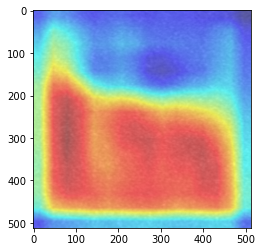

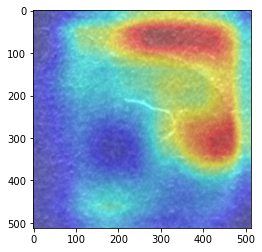

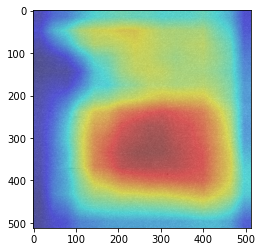

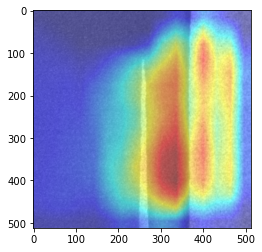

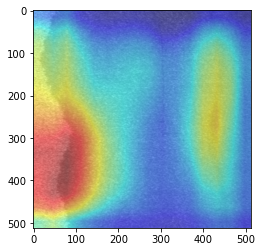

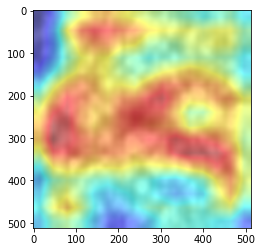

In [12]:
gradcam('Efficientnet', 'Best_Efficientnet_0.995.pth')


The model will be running on cuda:0 device
Load pre-trained model success Best_CoatNet_0.984.pth


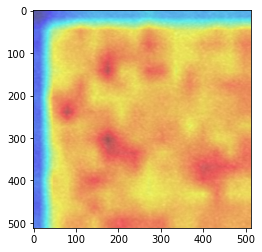

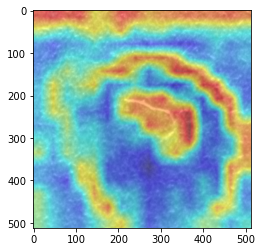

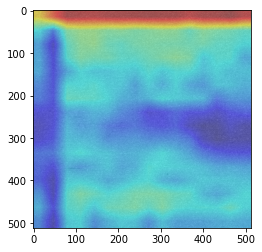

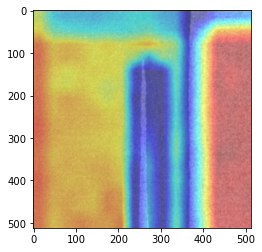

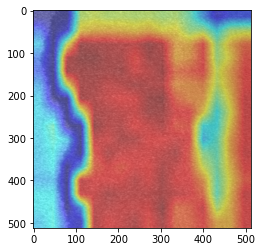

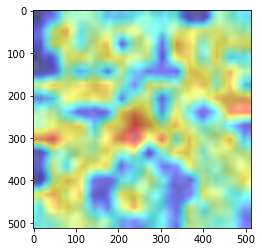

In [58]:
gradcam('CoatNet', 'Best_CoatNet_0.984.pth')
